In this project, we'll build a simple convolutional neural network for CIFAR-10 image classification. Code contained in this project was based on Tensorflow 1.2.1 and python 3.5. 

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import tensorflow as tf

cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 6:
Image - Min Value: 7 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


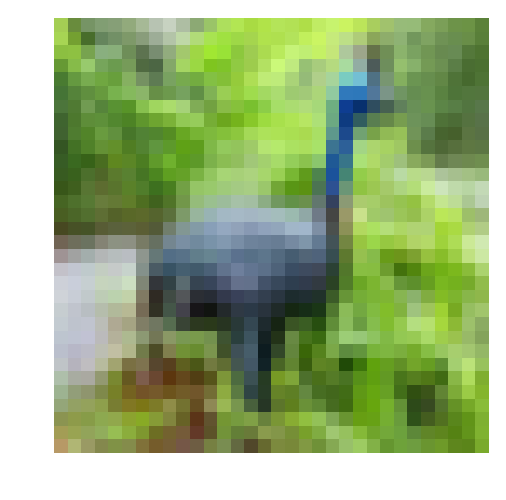

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 6
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

# Preprocess Data

## Normalize

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    """
    return (x - np.mean(x)) / np.std(x)
    # return ( x - x.min() ) / ( x.max() - x.min() )

## One hot encode

In [4]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    smooth_factor = 0.1
    output = np.zeros([len(x), 10])  #+( smooth_factor / 9 )
    for idx, item in enumerate(x):
        output[idx, item] = 1. # - smooth_factor
    return output

This above function is equivalent to tf.one_hot(x, 10), but tensorflow module can not be pickled so we're sticking with the above implementation.

## Preprocess Data
We will randomly shuffle the data, normalize them and save them in binary format.

In [5]:
import tensorflow as tf
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Checkpoint
The above work is all saved so when we're revisiting this notebook we don't have to do those work again. We can start from here.

In [6]:
import pickle
import helper

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))
valid_features = normalize(valid_features)

# Building the network

## Defining input

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    """
    return tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]], "x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    """
    return tf.placeholder(tf.float32, [None, n_classes], "y")


def neural_net_keep_prob_input(n):
    """
    Return a Tensor for keep probability
    """
    return tf.placeholder(tf.float32, None, "keep_prob_"+str(n))


def neural_net_training_flag():
    return tf.placeholder(tf.bool, None, "train_flag")

## Convolution and maxpool layer

In [8]:
def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides, is_train):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    w = tf.get_variable("w", shape=[conv_ksize[0], conv_ksize[1], x_tensor.get_shape().as_list()[3], conv_num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    #b = tf.Variable(tf.truncated_normal([conv_num_outputs],
    #                                  mean=0.0, stddev=0.1, dtype=tf.float32))
    
    wc = tf.nn.conv2d(x_tensor, w, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    # z = tf.nn.bias_add(wc, b)
    z = tf.layers.batch_normalization(wc, training=is_train)
    
    alpha = 0.2
    #return tf.maximum(alpha*z, z)
    
    return tf.nn.relu(z)



## Flatten layer
Implement the flatten function to change the dimension of x_tensor from a 4-D tensor to a 2-D tensor. The output should be the shape (Batch Size, Flattened Image Size). Shortcut option: you can use classes from the TensorFlow Layers or TensorFlow Layers (contrib) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [9]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # reference : https://github.com/tensorflow/tensorflow/issues/7253
    return tf.reshape(x_tensor, [tf.shape(x_tensor)[0], np.prod(x_tensor.get_shape().as_list()[1:])])
    
    # This also works
    #return tf.reshape(x_tensor, [-1, np.prod(x_tensor.shape[1:]).value])

## Fully connected layer

In [10]:
def fully_conn(x_tensor, num_outputs, is_train):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    fc = tf.reshape(x_tensor, [-1, np.prod(x_tensor.get_shape().as_list()[1:])])
    
    w = tf.get_variable("w", shape=[np.prod(x_tensor.get_shape().as_list()[1:]), num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    # b = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1, dtype=tf.float32))
    z = tf.matmul(fc, w)
    z = tf.layers.batch_normalization(z, training=is_train)
    
    alpha = 0.2
    #return tf.maximum(alpha*z, z)
    return tf.nn.relu(z)

## Output layer

In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    w = tf.get_variable("w", shape=[np.prod(x_tensor.get_shape().as_list()[1:]), num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1, dtype=tf.float32))
    return tf.add(tf.matmul(x_tensor, w), b)


## Create the convolutional neural network model

In [12]:
def conv_net(x, keep_prob_1, keep_prob_2, keep_prob_3, keep_prob_4,  train_flag):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    # Convolution and maxpooling layers
    with tf.variable_scope("conv1"):
        conv = conv2d(x, 64, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_1)
    with tf.variable_scope("conv1s"):
        conv = conv2d(conv, 64, (3, 3), (1, 1), train_flag)
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.dropout(conv, keep_prob_1)
    
    with tf.variable_scope("conv2"):
        conv = conv2d(conv, 128, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_2)
    with tf.variable_scope("conv2s"):
        conv = conv2d(conv, 128, (3, 3), (1, 1), train_flag)
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.dropout(conv, keep_prob_2)
    
    with tf.variable_scope("conv3"):
        conv = conv2d(conv, 256, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_3)
    with tf.variable_scope("conv3s"):
        conv = conv2d(conv, 256, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_3)
    with tf.variable_scope("conv3t"):
        conv = conv2d(conv, 256, (3, 3), (1, 1), train_flag)
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.dropout(conv, keep_prob_3)
    
  
    with tf.variable_scope("conv4"):
        conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_4)
    with tf.variable_scope("conv4s"):
        conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_4)
    with tf.variable_scope("conv4t"):
        conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.dropout(conv, keep_prob_4)
    
    with tf.variable_scope("conv5"):
        conv = conv2d(conv, 512, (1, 1), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_4)
    
    #with tf.variable_scope("conv5"):
    #    conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    #conv = tf.nn.dropout(conv, keep_prob_4)
    #with tf.variable_scope("conv5s"):
    #    conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    #conv = tf.nn.dropout(conv, keep_prob_4)
    #with tf.variable_scope("conv5t"):
    #    conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    #conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #conv = tf.nn.dropout(conv, keep_prob_4)
    
    
    # Flatten Layer
    f = flatten(conv)

    # Fully Connected layers
    with tf.variable_scope("fc1"):
        fc = fully_conn(f, 512, train_flag)
        fc = tf.nn.dropout(fc, keep_prob_4)
    with tf.variable_scope("fc2"):
        fc = fully_conn(fc, 512, train_flag)
        fc = tf.nn.dropout(fc, keep_prob_4)
    #with tf.variable_scope("fc3"):
    #    fc = fully_conn(fc, 512, train_flag)
    #    fc = tf.nn.dropout(fc, keep_prob_4)
    
    # Output Layer
    with tf.variable_scope("out"):
        o = output(fc, 10)
    
    # TODO: return output
    return o




## Build the network

In [13]:
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob_1 = neural_net_keep_prob_input(1)
keep_prob_2 = neural_net_keep_prob_input(2)
keep_prob_3 = neural_net_keep_prob_input(3)
keep_prob_4 = neural_net_keep_prob_input(4)
train_flag = neural_net_training_flag()

# Model
logits = conv_net(x, keep_prob_1, keep_prob_2, keep_prob_3, keep_prob_4, train_flag)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

# Collect batch mean and variance for batch normalization
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    #optimizer = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9, use_nesterov=True).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Train network

In [14]:
def train_neural_network(session, optimizer, kp1, kp2, kp3, kp4, feature_batch, label_batch, is_train):
    """
    Optimize the session on a batch of images and labels
    """
    session.run(optimizer, feed_dict={x: feature_batch, 
                                      y: label_batch, 
                                      keep_prob_1: kp1,
                                      keep_prob_2: kp2,
                                      keep_prob_3: kp3,
                                      keep_prob_4: kp4,
                                      train_flag:is_train})

## Print Stats
It's important to evaluate the performance of model once in a while. If effect, we're feeding a small batch of data to the neural network through forward propagation and then caculate the accuracy of prediction. We don't want to do this too often as this slows down the overall process. It's important to keep in mind that since we're actually using the model for prediction but not training it, we need to set keep probability for dropout to 1 so we're not losing any connection between neurons. 

In [15]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    """
    loss = session.run(cost, feed_dict={x: feature_batch, 
                                        y: label_batch, 
                                        keep_prob_1: 1., 
                                        keep_prob_2: 1.,
                                        keep_prob_3: 1.,
                                        keep_prob_4: 1.,
                                        train_flag:False})
    valid_acc = session.run(accuracy, feed_dict={x: valid_features, 
                                                 y: valid_labels, 
                                                 keep_prob_1: 1., 
                                                 keep_prob_2: 1.,
                                                 keep_prob_3: 1.,
                                                 keep_prob_4: 1.,
                                                 train_flag:False})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

## Hyperparameters

In [16]:
epochs = 3200
batch_size = 64
kp1 = 0.8
kp2 = 0.7
kp3 = 0.6
kp4 = 0.5

## Train on a single CIFAR-10 batch

In [17]:
#print('Checking the Training on a Single Batch...')
#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
    
    # Training cycle
#    for epoch in range(epochs):
#        batch_i = 1
#        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
#            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels, True)
#        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
#        print_stats(sess, batch_features, batch_labels, cost, accuracy)

## Fully train the model
Deep structure 11 layers, withFliplr, Gaussian Blur, Crop, and Affine, 200 Epochs : 91.1 %

In [18]:
import helper
import imgaug as ia
from imgaug import augmenters as iaa
sometimes = lambda aug: iaa.Sometimes(0.4, aug)

save_model_path = './image_classification'


print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        index = np.array(range(n_batches)) + 1
        np.random.shuffle(index)
        for batch_i in index : # range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                
                seq = iaa.Sequential([iaa.Fliplr(0.5),
                                      iaa.Flipud(0.2),
                                      sometimes(iaa.Crop(px=2)),
                                      sometimes(iaa.Affine(scale={"X":(0.8,1.2), "y":(0.8,1.2)}, 
                                                           rotate=(-45,45), shear=(-16,16),
                                                           translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                                           cval=(0,255), mode=ia.ALL)),
                                      sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.5)),
                                      sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),
                                      sometimes(iaa.GaussianBlur(sigma=(0, 3.0)))
                                     ], random_order=True)
                batch_features = seq.augment_images(batch_features)
                
                batch_mean = np.mean(batch_features)
                batch_std = np.std(batch_features)
                batch_features = batch_features.astype(np.float32)
                for ii in range(batch_features.shape[0]):
                    
                    batch_features[ii, :, :, :] = (batch_features[ii, :, :, :] - batch_mean) / batch_std                     
                train_neural_network(sess, optimizer, kp1, kp2, kp3, kp4, batch_features, batch_labels, True)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.3148 Validation Accuracy: 0.097000
Epoch  1, CIFAR-10 Batch 3:  Loss:     2.3139 Validation Accuracy: 0.100200
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2042 Validation Accuracy: 0.200200
Epoch  1, CIFAR-10 Batch 4:  Loss:     2.2924 Validation Accuracy: 0.161400
Epoch  1, CIFAR-10 Batch 5:  Loss:     2.3076 Validation Accuracy: 0.228000
Epoch  2, CIFAR-10 Batch 5:  Loss:     2.2043 Validation Accuracy: 0.262800
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.7944 Validation Accuracy: 0.279800
Epoch  2, CIFAR-10 Batch 4:  Loss:     2.0415 Validation Accuracy: 0.291800
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.7401 Validation Accuracy: 0.307600
Epoch  2, CIFAR-10 Batch 2:  Loss:     2.1759 Validation Accuracy: 0.299200
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.6957 Validation Accuracy: 0.342600
Epoch  3, CIFAR-10 Batch 5:  Loss:     1.6139 Validation Accuracy: 0.340200
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.5688 Validation Accuracy: 0.383400


Epoch 22, CIFAR-10 Batch 2:  Loss:     1.0377 Validation Accuracy: 0.762400
Epoch 22, CIFAR-10 Batch 4:  Loss:     0.9075 Validation Accuracy: 0.771200
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.9167 Validation Accuracy: 0.773200
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.7372 Validation Accuracy: 0.782600
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.9801 Validation Accuracy: 0.784200
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.7805 Validation Accuracy: 0.785200
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.7532 Validation Accuracy: 0.774000
Epoch 24, CIFAR-10 Batch 2:  Loss:     1.0078 Validation Accuracy: 0.791600
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.7766 Validation Accuracy: 0.767200
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.8079 Validation Accuracy: 0.778400
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.7387 Validation Accuracy: 0.793800
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.9151 Validation Accuracy: 0.788400
Epoch 25, CIFAR-10 Batch 5:  Loss:     0.7391 Validation Accuracy: 0.792000
Epoch 25, CI

Epoch 44, CIFAR-10 Batch 4:  Loss:     0.9866 Validation Accuracy: 0.827000
Epoch 44, CIFAR-10 Batch 1:  Loss:     1.0157 Validation Accuracy: 0.836800
Epoch 44, CIFAR-10 Batch 3:  Loss:     0.6459 Validation Accuracy: 0.844600
Epoch 44, CIFAR-10 Batch 2:  Loss:     0.8172 Validation Accuracy: 0.833800
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.8599 Validation Accuracy: 0.827200
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.7093 Validation Accuracy: 0.846400
Epoch 45, CIFAR-10 Batch 1:  Loss:     1.0381 Validation Accuracy: 0.832200
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.6303 Validation Accuracy: 0.835800
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.6288 Validation Accuracy: 0.842400
Epoch 46, CIFAR-10 Batch 5:  Loss:     0.5312 Validation Accuracy: 0.841000
Epoch 46, CIFAR-10 Batch 3:  Loss:     1.1950 Validation Accuracy: 0.842600
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.7759 Validation Accuracy: 0.844800
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.7509 Validation Accuracy: 0.843400
Epoch 46, CI

Epoch 65, CIFAR-10 Batch 3:  Loss:     0.4026 Validation Accuracy: 0.859000
Epoch 66, CIFAR-10 Batch 3:  Loss:     0.6597 Validation Accuracy: 0.858400
Epoch 66, CIFAR-10 Batch 5:  Loss:     0.8110 Validation Accuracy: 0.861400
Epoch 66, CIFAR-10 Batch 2:  Loss:     0.5462 Validation Accuracy: 0.857200
Epoch 66, CIFAR-10 Batch 1:  Loss:     0.6665 Validation Accuracy: 0.859400
Epoch 66, CIFAR-10 Batch 4:  Loss:     0.7549 Validation Accuracy: 0.866000
Epoch 67, CIFAR-10 Batch 3:  Loss:     0.8345 Validation Accuracy: 0.857200
Epoch 67, CIFAR-10 Batch 5:  Loss:     0.6534 Validation Accuracy: 0.864800
Epoch 67, CIFAR-10 Batch 1:  Loss:     0.5382 Validation Accuracy: 0.868800
Epoch 67, CIFAR-10 Batch 4:  Loss:     0.4083 Validation Accuracy: 0.863200
Epoch 67, CIFAR-10 Batch 2:  Loss:     0.7105 Validation Accuracy: 0.864000
Epoch 68, CIFAR-10 Batch 2:  Loss:     0.7690 Validation Accuracy: 0.866200
Epoch 68, CIFAR-10 Batch 1:  Loss:     0.5740 Validation Accuracy: 0.865000
Epoch 68, CI

Epoch 87, CIFAR-10 Batch 2:  Loss:     0.3966 Validation Accuracy: 0.875200
Epoch 87, CIFAR-10 Batch 5:  Loss:     0.6129 Validation Accuracy: 0.876200
Epoch 87, CIFAR-10 Batch 4:  Loss:     0.7918 Validation Accuracy: 0.877200
Epoch 88, CIFAR-10 Batch 4:  Loss:     0.6830 Validation Accuracy: 0.870600
Epoch 88, CIFAR-10 Batch 2:  Loss:     0.5230 Validation Accuracy: 0.875000
Epoch 88, CIFAR-10 Batch 3:  Loss:     0.5679 Validation Accuracy: 0.877800
Epoch 88, CIFAR-10 Batch 5:  Loss:     0.5160 Validation Accuracy: 0.873800
Epoch 88, CIFAR-10 Batch 1:  Loss:     0.3266 Validation Accuracy: 0.859400
Epoch 89, CIFAR-10 Batch 1:  Loss:     0.4577 Validation Accuracy: 0.873000
Epoch 89, CIFAR-10 Batch 2:  Loss:     0.7764 Validation Accuracy: 0.877800
Epoch 89, CIFAR-10 Batch 4:  Loss:     0.6954 Validation Accuracy: 0.874000
Epoch 89, CIFAR-10 Batch 5:  Loss:     0.6117 Validation Accuracy: 0.872200
Epoch 89, CIFAR-10 Batch 3:  Loss:     0.5373 Validation Accuracy: 0.870800
Epoch 90, CI

Epoch 108, CIFAR-10 Batch 3:  Loss:     0.8983 Validation Accuracy: 0.880400
Epoch 109, CIFAR-10 Batch 4:  Loss:     0.6413 Validation Accuracy: 0.879800
Epoch 109, CIFAR-10 Batch 5:  Loss:     0.8102 Validation Accuracy: 0.889200
Epoch 109, CIFAR-10 Batch 1:  Loss:     0.3532 Validation Accuracy: 0.881000
Epoch 109, CIFAR-10 Batch 3:  Loss:     0.6235 Validation Accuracy: 0.881800
Epoch 109, CIFAR-10 Batch 2:  Loss:     0.6200 Validation Accuracy: 0.882200
Epoch 110, CIFAR-10 Batch 5:  Loss:     0.5718 Validation Accuracy: 0.883000
Epoch 110, CIFAR-10 Batch 2:  Loss:     0.6413 Validation Accuracy: 0.886200
Epoch 110, CIFAR-10 Batch 4:  Loss:     0.3772 Validation Accuracy: 0.884600
Epoch 110, CIFAR-10 Batch 1:  Loss:     1.1024 Validation Accuracy: 0.885400
Epoch 110, CIFAR-10 Batch 3:  Loss:     0.7585 Validation Accuracy: 0.883200
Epoch 111, CIFAR-10 Batch 1:  Loss:     0.3788 Validation Accuracy: 0.881600
Epoch 111, CIFAR-10 Batch 2:  Loss:     0.6045 Validation Accuracy: 0.878600

Epoch 130, CIFAR-10 Batch 4:  Loss:     0.4020 Validation Accuracy: 0.894000
Epoch 130, CIFAR-10 Batch 1:  Loss:     0.5163 Validation Accuracy: 0.890400
Epoch 130, CIFAR-10 Batch 2:  Loss:     0.7483 Validation Accuracy: 0.886800
Epoch 130, CIFAR-10 Batch 5:  Loss:     0.3483 Validation Accuracy: 0.889200
Epoch 131, CIFAR-10 Batch 1:  Loss:     0.4362 Validation Accuracy: 0.887600
Epoch 131, CIFAR-10 Batch 3:  Loss:     0.5012 Validation Accuracy: 0.891800
Epoch 131, CIFAR-10 Batch 4:  Loss:     0.4152 Validation Accuracy: 0.890000
Epoch 131, CIFAR-10 Batch 2:  Loss:     0.5275 Validation Accuracy: 0.881800
Epoch 131, CIFAR-10 Batch 5:  Loss:     0.6162 Validation Accuracy: 0.885400
Epoch 132, CIFAR-10 Batch 1:  Loss:     0.5039 Validation Accuracy: 0.887000
Epoch 132, CIFAR-10 Batch 5:  Loss:     0.5953 Validation Accuracy: 0.891000
Epoch 132, CIFAR-10 Batch 3:  Loss:     0.3646 Validation Accuracy: 0.886600
Epoch 132, CIFAR-10 Batch 2:  Loss:     0.4684 Validation Accuracy: 0.887800

Epoch 151, CIFAR-10 Batch 1:  Loss:     0.8190 Validation Accuracy: 0.883400
Epoch 151, CIFAR-10 Batch 4:  Loss:     0.5872 Validation Accuracy: 0.890600
Epoch 152, CIFAR-10 Batch 2:  Loss:     0.3603 Validation Accuracy: 0.896200
Epoch 152, CIFAR-10 Batch 1:  Loss:     0.4614 Validation Accuracy: 0.890800
Epoch 152, CIFAR-10 Batch 5:  Loss:     0.4069 Validation Accuracy: 0.898800
Epoch 152, CIFAR-10 Batch 4:  Loss:     0.4078 Validation Accuracy: 0.887200
Epoch 152, CIFAR-10 Batch 3:  Loss:     0.4520 Validation Accuracy: 0.889400
Epoch 153, CIFAR-10 Batch 1:  Loss:     0.5529 Validation Accuracy: 0.894000
Epoch 153, CIFAR-10 Batch 2:  Loss:     0.4941 Validation Accuracy: 0.888800
Epoch 153, CIFAR-10 Batch 3:  Loss:     0.5004 Validation Accuracy: 0.893400
Epoch 153, CIFAR-10 Batch 4:  Loss:     0.4011 Validation Accuracy: 0.892800
Epoch 153, CIFAR-10 Batch 5:  Loss:     0.4878 Validation Accuracy: 0.890800
Epoch 154, CIFAR-10 Batch 4:  Loss:     0.5071 Validation Accuracy: 0.890600

Epoch 173, CIFAR-10 Batch 1:  Loss:     0.6372 Validation Accuracy: 0.892400
Epoch 173, CIFAR-10 Batch 5:  Loss:     0.4103 Validation Accuracy: 0.900200
Epoch 173, CIFAR-10 Batch 2:  Loss:     0.3695 Validation Accuracy: 0.900000
Epoch 173, CIFAR-10 Batch 4:  Loss:     0.4745 Validation Accuracy: 0.899000
Epoch 173, CIFAR-10 Batch 3:  Loss:     0.5614 Validation Accuracy: 0.898600
Epoch 174, CIFAR-10 Batch 5:  Loss:     0.2269 Validation Accuracy: 0.897600
Epoch 174, CIFAR-10 Batch 1:  Loss:     0.5175 Validation Accuracy: 0.896000
Epoch 174, CIFAR-10 Batch 4:  Loss:     0.7183 Validation Accuracy: 0.893200
Epoch 174, CIFAR-10 Batch 3:  Loss:     0.4026 Validation Accuracy: 0.897400
Epoch 174, CIFAR-10 Batch 2:  Loss:     0.2358 Validation Accuracy: 0.894800
Epoch 175, CIFAR-10 Batch 3:  Loss:     0.8655 Validation Accuracy: 0.896600
Epoch 175, CIFAR-10 Batch 4:  Loss:     0.3886 Validation Accuracy: 0.899200
Epoch 175, CIFAR-10 Batch 1:  Loss:     0.7997 Validation Accuracy: 0.896400

Epoch 194, CIFAR-10 Batch 2:  Loss:     0.5449 Validation Accuracy: 0.899600
Epoch 194, CIFAR-10 Batch 4:  Loss:     0.3246 Validation Accuracy: 0.897400
Epoch 194, CIFAR-10 Batch 1:  Loss:     0.5136 Validation Accuracy: 0.901800
Epoch 195, CIFAR-10 Batch 1:  Loss:     0.5739 Validation Accuracy: 0.895400
Epoch 195, CIFAR-10 Batch 2:  Loss:     0.5029 Validation Accuracy: 0.897800
Epoch 195, CIFAR-10 Batch 5:  Loss:     0.5709 Validation Accuracy: 0.901400
Epoch 195, CIFAR-10 Batch 3:  Loss:     0.5022 Validation Accuracy: 0.896400
Epoch 195, CIFAR-10 Batch 4:  Loss:     0.8346 Validation Accuracy: 0.898600
Epoch 196, CIFAR-10 Batch 1:  Loss:     0.3640 Validation Accuracy: 0.892600
Epoch 196, CIFAR-10 Batch 2:  Loss:     0.4167 Validation Accuracy: 0.896600
Epoch 196, CIFAR-10 Batch 4:  Loss:     0.3254 Validation Accuracy: 0.898400
Epoch 196, CIFAR-10 Batch 3:  Loss:     0.4519 Validation Accuracy: 0.899600
Epoch 196, CIFAR-10 Batch 5:  Loss:     0.5351 Validation Accuracy: 0.896000

Epoch 215, CIFAR-10 Batch 4:  Loss:     0.5195 Validation Accuracy: 0.892000
Epoch 216, CIFAR-10 Batch 4:  Loss:     0.5778 Validation Accuracy: 0.898000
Epoch 216, CIFAR-10 Batch 1:  Loss:     0.5035 Validation Accuracy: 0.902600
Epoch 216, CIFAR-10 Batch 5:  Loss:     0.7662 Validation Accuracy: 0.901000
Epoch 216, CIFAR-10 Batch 2:  Loss:     0.4949 Validation Accuracy: 0.903000
Epoch 216, CIFAR-10 Batch 3:  Loss:     0.5566 Validation Accuracy: 0.903800
Epoch 217, CIFAR-10 Batch 3:  Loss:     0.3350 Validation Accuracy: 0.898400
Epoch 217, CIFAR-10 Batch 5:  Loss:     0.5434 Validation Accuracy: 0.901000
Epoch 217, CIFAR-10 Batch 1:  Loss:     0.8226 Validation Accuracy: 0.898400
Epoch 217, CIFAR-10 Batch 2:  Loss:     0.5429 Validation Accuracy: 0.898200
Epoch 217, CIFAR-10 Batch 4:  Loss:     0.3537 Validation Accuracy: 0.899200
Epoch 218, CIFAR-10 Batch 3:  Loss:     0.3089 Validation Accuracy: 0.897400
Epoch 218, CIFAR-10 Batch 2:  Loss:     0.5360 Validation Accuracy: 0.903000

Epoch 237, CIFAR-10 Batch 4:  Loss:     0.5339 Validation Accuracy: 0.902600
Epoch 237, CIFAR-10 Batch 3:  Loss:     0.4579 Validation Accuracy: 0.897400
Epoch 237, CIFAR-10 Batch 2:  Loss:     0.5839 Validation Accuracy: 0.903400
Epoch 237, CIFAR-10 Batch 5:  Loss:     0.3808 Validation Accuracy: 0.904000
Epoch 238, CIFAR-10 Batch 4:  Loss:     0.5178 Validation Accuracy: 0.905000
Epoch 238, CIFAR-10 Batch 1:  Loss:     0.5220 Validation Accuracy: 0.901800
Epoch 238, CIFAR-10 Batch 2:  Loss:     0.4666 Validation Accuracy: 0.902200
Epoch 238, CIFAR-10 Batch 3:  Loss:     0.6174 Validation Accuracy: 0.897200
Epoch 238, CIFAR-10 Batch 5:  Loss:     0.3254 Validation Accuracy: 0.903800
Epoch 239, CIFAR-10 Batch 2:  Loss:     0.5684 Validation Accuracy: 0.904600
Epoch 239, CIFAR-10 Batch 1:  Loss:     0.6190 Validation Accuracy: 0.899400
Epoch 239, CIFAR-10 Batch 3:  Loss:     0.5793 Validation Accuracy: 0.904000
Epoch 239, CIFAR-10 Batch 5:  Loss:     0.6088 Validation Accuracy: 0.907200

Epoch 258, CIFAR-10 Batch 2:  Loss:     0.4987 Validation Accuracy: 0.901600
Epoch 258, CIFAR-10 Batch 5:  Loss:     0.4977 Validation Accuracy: 0.907200
Epoch 259, CIFAR-10 Batch 1:  Loss:     0.8790 Validation Accuracy: 0.902800
Epoch 259, CIFAR-10 Batch 3:  Loss:     0.3219 Validation Accuracy: 0.902400
Epoch 259, CIFAR-10 Batch 2:  Loss:     0.7448 Validation Accuracy: 0.905800
Epoch 259, CIFAR-10 Batch 5:  Loss:     0.6190 Validation Accuracy: 0.900600
Epoch 259, CIFAR-10 Batch 4:  Loss:     0.3393 Validation Accuracy: 0.905200
Epoch 260, CIFAR-10 Batch 3:  Loss:     0.4287 Validation Accuracy: 0.902600
Epoch 260, CIFAR-10 Batch 4:  Loss:     0.5049 Validation Accuracy: 0.900400
Epoch 260, CIFAR-10 Batch 2:  Loss:     0.3736 Validation Accuracy: 0.901200
Epoch 260, CIFAR-10 Batch 5:  Loss:     0.3870 Validation Accuracy: 0.907000
Epoch 260, CIFAR-10 Batch 1:  Loss:     0.5759 Validation Accuracy: 0.903800
Epoch 261, CIFAR-10 Batch 2:  Loss:     0.3915 Validation Accuracy: 0.909000

Epoch 280, CIFAR-10 Batch 4:  Loss:     0.6107 Validation Accuracy: 0.906200
Epoch 280, CIFAR-10 Batch 2:  Loss:     0.4878 Validation Accuracy: 0.901200
Epoch 280, CIFAR-10 Batch 5:  Loss:     0.6696 Validation Accuracy: 0.909600
Epoch 280, CIFAR-10 Batch 1:  Loss:     0.2241 Validation Accuracy: 0.909000
Epoch 280, CIFAR-10 Batch 3:  Loss:     0.5378 Validation Accuracy: 0.902600
Epoch 281, CIFAR-10 Batch 3:  Loss:     0.6682 Validation Accuracy: 0.904000
Epoch 281, CIFAR-10 Batch 4:  Loss:     0.7725 Validation Accuracy: 0.909000
Epoch 281, CIFAR-10 Batch 5:  Loss:     0.3525 Validation Accuracy: 0.908800
Epoch 281, CIFAR-10 Batch 2:  Loss:     0.6723 Validation Accuracy: 0.908000
Epoch 281, CIFAR-10 Batch 1:  Loss:     0.7424 Validation Accuracy: 0.904400
Epoch 282, CIFAR-10 Batch 5:  Loss:     0.4101 Validation Accuracy: 0.904600
Epoch 282, CIFAR-10 Batch 1:  Loss:     0.4948 Validation Accuracy: 0.899600
Epoch 282, CIFAR-10 Batch 4:  Loss:     0.6180 Validation Accuracy: 0.907000

Epoch 301, CIFAR-10 Batch 4:  Loss:     0.7216 Validation Accuracy: 0.911000
Epoch 301, CIFAR-10 Batch 3:  Loss:     0.2767 Validation Accuracy: 0.909800
Epoch 301, CIFAR-10 Batch 1:  Loss:     0.4473 Validation Accuracy: 0.910200
Epoch 302, CIFAR-10 Batch 3:  Loss:     0.4113 Validation Accuracy: 0.911400
Epoch 302, CIFAR-10 Batch 5:  Loss:     0.4007 Validation Accuracy: 0.909200
Epoch 302, CIFAR-10 Batch 4:  Loss:     0.8312 Validation Accuracy: 0.907800
Epoch 302, CIFAR-10 Batch 1:  Loss:     0.6038 Validation Accuracy: 0.911200
Epoch 302, CIFAR-10 Batch 2:  Loss:     0.6031 Validation Accuracy: 0.908200
Epoch 303, CIFAR-10 Batch 1:  Loss:     0.4600 Validation Accuracy: 0.911400
Epoch 303, CIFAR-10 Batch 3:  Loss:     0.4839 Validation Accuracy: 0.908600
Epoch 303, CIFAR-10 Batch 4:  Loss:     0.2914 Validation Accuracy: 0.905400
Epoch 303, CIFAR-10 Batch 2:  Loss:     0.4191 Validation Accuracy: 0.909400
Epoch 303, CIFAR-10 Batch 5:  Loss:     0.4459 Validation Accuracy: 0.912000

Epoch 322, CIFAR-10 Batch 5:  Loss:     0.3779 Validation Accuracy: 0.911200
Epoch 323, CIFAR-10 Batch 1:  Loss:     0.3062 Validation Accuracy: 0.906600
Epoch 323, CIFAR-10 Batch 3:  Loss:     0.2462 Validation Accuracy: 0.907600
Epoch 323, CIFAR-10 Batch 4:  Loss:     0.2632 Validation Accuracy: 0.908600
Epoch 323, CIFAR-10 Batch 2:  Loss:     0.2769 Validation Accuracy: 0.910400
Epoch 323, CIFAR-10 Batch 5:  Loss:     0.4583 Validation Accuracy: 0.905200
Epoch 324, CIFAR-10 Batch 3:  Loss:     0.5512 Validation Accuracy: 0.910400
Epoch 324, CIFAR-10 Batch 4:  Loss:     0.6556 Validation Accuracy: 0.909800
Epoch 324, CIFAR-10 Batch 5:  Loss:     0.3934 Validation Accuracy: 0.912400
Epoch 324, CIFAR-10 Batch 1:  Loss:     0.1654 Validation Accuracy: 0.906000
Epoch 324, CIFAR-10 Batch 2:  Loss:     0.4369 Validation Accuracy: 0.906600
Epoch 325, CIFAR-10 Batch 4:  Loss:     0.3850 Validation Accuracy: 0.908400
Epoch 325, CIFAR-10 Batch 3:  Loss:     0.2998 Validation Accuracy: 0.908000

Epoch 344, CIFAR-10 Batch 1:  Loss:     0.3979 Validation Accuracy: 0.909600
Epoch 344, CIFAR-10 Batch 4:  Loss:     0.3421 Validation Accuracy: 0.913800
Epoch 344, CIFAR-10 Batch 2:  Loss:     0.3849 Validation Accuracy: 0.907200
Epoch 344, CIFAR-10 Batch 5:  Loss:     0.5833 Validation Accuracy: 0.910400
Epoch 345, CIFAR-10 Batch 3:  Loss:     0.3472 Validation Accuracy: 0.914200
Epoch 345, CIFAR-10 Batch 2:  Loss:     0.5656 Validation Accuracy: 0.909200
Epoch 345, CIFAR-10 Batch 5:  Loss:     0.5379 Validation Accuracy: 0.907400
Epoch 345, CIFAR-10 Batch 1:  Loss:     0.3530 Validation Accuracy: 0.911400
Epoch 345, CIFAR-10 Batch 4:  Loss:     0.4139 Validation Accuracy: 0.910600
Epoch 346, CIFAR-10 Batch 1:  Loss:     0.4863 Validation Accuracy: 0.913200
Epoch 346, CIFAR-10 Batch 2:  Loss:     0.5913 Validation Accuracy: 0.905800
Epoch 346, CIFAR-10 Batch 3:  Loss:     0.5366 Validation Accuracy: 0.910200
Epoch 346, CIFAR-10 Batch 4:  Loss:     0.5712 Validation Accuracy: 0.913000

Epoch 365, CIFAR-10 Batch 4:  Loss:     0.5106 Validation Accuracy: 0.914600
Epoch 365, CIFAR-10 Batch 5:  Loss:     0.6417 Validation Accuracy: 0.909600
Epoch 366, CIFAR-10 Batch 3:  Loss:     0.4711 Validation Accuracy: 0.912200
Epoch 366, CIFAR-10 Batch 1:  Loss:     0.4185 Validation Accuracy: 0.914000
Epoch 366, CIFAR-10 Batch 2:  Loss:     0.7284 Validation Accuracy: 0.913600
Epoch 366, CIFAR-10 Batch 4:  Loss:     0.5416 Validation Accuracy: 0.913000
Epoch 366, CIFAR-10 Batch 5:  Loss:     0.5042 Validation Accuracy: 0.913000
Epoch 367, CIFAR-10 Batch 3:  Loss:     0.5439 Validation Accuracy: 0.908000
Epoch 367, CIFAR-10 Batch 1:  Loss:     0.4056 Validation Accuracy: 0.909000
Epoch 367, CIFAR-10 Batch 5:  Loss:     0.3573 Validation Accuracy: 0.911600
Epoch 367, CIFAR-10 Batch 2:  Loss:     0.3399 Validation Accuracy: 0.910000
Epoch 367, CIFAR-10 Batch 4:  Loss:     0.2682 Validation Accuracy: 0.913400
Epoch 368, CIFAR-10 Batch 1:  Loss:     0.2603 Validation Accuracy: 0.915400

Epoch 387, CIFAR-10 Batch 5:  Loss:     0.6508 Validation Accuracy: 0.911200
Epoch 387, CIFAR-10 Batch 2:  Loss:     0.2836 Validation Accuracy: 0.912400
Epoch 387, CIFAR-10 Batch 1:  Loss:     0.4579 Validation Accuracy: 0.910800
Epoch 387, CIFAR-10 Batch 4:  Loss:     0.6239 Validation Accuracy: 0.907800
Epoch 387, CIFAR-10 Batch 3:  Loss:     0.5379 Validation Accuracy: 0.909400
Epoch 388, CIFAR-10 Batch 4:  Loss:     0.5024 Validation Accuracy: 0.913200
Epoch 388, CIFAR-10 Batch 1:  Loss:     0.4014 Validation Accuracy: 0.911600
Epoch 388, CIFAR-10 Batch 2:  Loss:     0.2988 Validation Accuracy: 0.913400
Epoch 388, CIFAR-10 Batch 5:  Loss:     0.2384 Validation Accuracy: 0.913800
Epoch 388, CIFAR-10 Batch 3:  Loss:     0.4886 Validation Accuracy: 0.914800
Epoch 389, CIFAR-10 Batch 2:  Loss:     0.4031 Validation Accuracy: 0.913200
Epoch 389, CIFAR-10 Batch 3:  Loss:     0.3103 Validation Accuracy: 0.910800
Epoch 389, CIFAR-10 Batch 4:  Loss:     0.4447 Validation Accuracy: 0.908600

Epoch 408, CIFAR-10 Batch 1:  Loss:     0.3645 Validation Accuracy: 0.915400
Epoch 408, CIFAR-10 Batch 4:  Loss:     0.3394 Validation Accuracy: 0.917000
Epoch 408, CIFAR-10 Batch 2:  Loss:     0.4589 Validation Accuracy: 0.913200
Epoch 409, CIFAR-10 Batch 5:  Loss:     0.3659 Validation Accuracy: 0.916600
Epoch 409, CIFAR-10 Batch 3:  Loss:     0.5119 Validation Accuracy: 0.911200
Epoch 409, CIFAR-10 Batch 2:  Loss:     0.8989 Validation Accuracy: 0.913200
Epoch 409, CIFAR-10 Batch 1:  Loss:     0.4337 Validation Accuracy: 0.910400
Epoch 409, CIFAR-10 Batch 4:  Loss:     0.2514 Validation Accuracy: 0.914000
Epoch 410, CIFAR-10 Batch 1:  Loss:     0.3905 Validation Accuracy: 0.911600
Epoch 410, CIFAR-10 Batch 3:  Loss:     0.2110 Validation Accuracy: 0.913400
Epoch 410, CIFAR-10 Batch 4:  Loss:     0.6382 Validation Accuracy: 0.911600
Epoch 410, CIFAR-10 Batch 5:  Loss:     0.4718 Validation Accuracy: 0.911600
Epoch 410, CIFAR-10 Batch 2:  Loss:     0.4370 Validation Accuracy: 0.911200

Epoch 429, CIFAR-10 Batch 3:  Loss:     0.5256 Validation Accuracy: 0.911600
Epoch 430, CIFAR-10 Batch 3:  Loss:     0.4340 Validation Accuracy: 0.914600
Epoch 430, CIFAR-10 Batch 4:  Loss:     0.4351 Validation Accuracy: 0.917600
Epoch 430, CIFAR-10 Batch 2:  Loss:     0.7633 Validation Accuracy: 0.914200
Epoch 430, CIFAR-10 Batch 5:  Loss:     0.5686 Validation Accuracy: 0.911600
Epoch 430, CIFAR-10 Batch 1:  Loss:     0.5097 Validation Accuracy: 0.913400
Epoch 431, CIFAR-10 Batch 2:  Loss:     0.3632 Validation Accuracy: 0.913600
Epoch 431, CIFAR-10 Batch 5:  Loss:     0.3472 Validation Accuracy: 0.914600
Epoch 431, CIFAR-10 Batch 4:  Loss:     0.5674 Validation Accuracy: 0.912600
Epoch 431, CIFAR-10 Batch 3:  Loss:     0.3990 Validation Accuracy: 0.914400
Epoch 431, CIFAR-10 Batch 1:  Loss:     0.3949 Validation Accuracy: 0.912400
Epoch 432, CIFAR-10 Batch 3:  Loss:     0.2885 Validation Accuracy: 0.913000
Epoch 432, CIFAR-10 Batch 5:  Loss:     0.4383 Validation Accuracy: 0.914800

Epoch 451, CIFAR-10 Batch 4:  Loss:     0.3439 Validation Accuracy: 0.916400
Epoch 451, CIFAR-10 Batch 2:  Loss:     0.4153 Validation Accuracy: 0.916000
Epoch 451, CIFAR-10 Batch 5:  Loss:     0.3501 Validation Accuracy: 0.917000
Epoch 451, CIFAR-10 Batch 1:  Loss:     0.3387 Validation Accuracy: 0.911400
Epoch 452, CIFAR-10 Batch 4:  Loss:     0.2454 Validation Accuracy: 0.917200
Epoch 452, CIFAR-10 Batch 2:  Loss:     0.3337 Validation Accuracy: 0.919600
Epoch 452, CIFAR-10 Batch 5:  Loss:     0.2985 Validation Accuracy: 0.914000
Epoch 452, CIFAR-10 Batch 3:  Loss:     0.3555 Validation Accuracy: 0.916200
Epoch 452, CIFAR-10 Batch 1:  Loss:     0.2792 Validation Accuracy: 0.916600
Epoch 453, CIFAR-10 Batch 5:  Loss:     0.3884 Validation Accuracy: 0.914200
Epoch 453, CIFAR-10 Batch 1:  Loss:     0.4376 Validation Accuracy: 0.914600
Epoch 453, CIFAR-10 Batch 4:  Loss:     0.6768 Validation Accuracy: 0.913200
Epoch 453, CIFAR-10 Batch 3:  Loss:     0.2958 Validation Accuracy: 0.916600

Epoch 472, CIFAR-10 Batch 1:  Loss:     0.4731 Validation Accuracy: 0.913600
Epoch 472, CIFAR-10 Batch 4:  Loss:     0.5623 Validation Accuracy: 0.910000
Epoch 473, CIFAR-10 Batch 4:  Loss:     0.1835 Validation Accuracy: 0.914800
Epoch 473, CIFAR-10 Batch 1:  Loss:     0.2214 Validation Accuracy: 0.913600
Epoch 473, CIFAR-10 Batch 5:  Loss:     0.1790 Validation Accuracy: 0.917000
Epoch 473, CIFAR-10 Batch 2:  Loss:     0.7446 Validation Accuracy: 0.910000
Epoch 473, CIFAR-10 Batch 3:  Loss:     0.3176 Validation Accuracy: 0.914000
Epoch 474, CIFAR-10 Batch 5:  Loss:     0.4491 Validation Accuracy: 0.911400
Epoch 474, CIFAR-10 Batch 4:  Loss:     0.2196 Validation Accuracy: 0.912000
Epoch 474, CIFAR-10 Batch 3:  Loss:     0.2290 Validation Accuracy: 0.914400
Epoch 474, CIFAR-10 Batch 2:  Loss:     0.5094 Validation Accuracy: 0.913600
Epoch 474, CIFAR-10 Batch 1:  Loss:     0.3285 Validation Accuracy: 0.915200
Epoch 475, CIFAR-10 Batch 5:  Loss:     0.2734 Validation Accuracy: 0.919200

Epoch 494, CIFAR-10 Batch 5:  Loss:     0.6162 Validation Accuracy: 0.917400
Epoch 494, CIFAR-10 Batch 4:  Loss:     0.2914 Validation Accuracy: 0.918200
Epoch 494, CIFAR-10 Batch 1:  Loss:     0.2290 Validation Accuracy: 0.912400
Epoch 494, CIFAR-10 Batch 2:  Loss:     0.3610 Validation Accuracy: 0.918600
Epoch 494, CIFAR-10 Batch 3:  Loss:     0.2269 Validation Accuracy: 0.916400
Epoch 495, CIFAR-10 Batch 5:  Loss:     0.8033 Validation Accuracy: 0.916600
Epoch 495, CIFAR-10 Batch 4:  Loss:     0.4047 Validation Accuracy: 0.918400
Epoch 495, CIFAR-10 Batch 1:  Loss:     0.3160 Validation Accuracy: 0.915200
Epoch 495, CIFAR-10 Batch 3:  Loss:     0.4552 Validation Accuracy: 0.917000
Epoch 495, CIFAR-10 Batch 2:  Loss:     0.2334 Validation Accuracy: 0.913200
Epoch 496, CIFAR-10 Batch 1:  Loss:     0.1493 Validation Accuracy: 0.914200
Epoch 496, CIFAR-10 Batch 2:  Loss:     0.6670 Validation Accuracy: 0.920200
Epoch 496, CIFAR-10 Batch 5:  Loss:     0.3233 Validation Accuracy: 0.916800

Epoch 515, CIFAR-10 Batch 4:  Loss:     0.3543 Validation Accuracy: 0.918000
Epoch 515, CIFAR-10 Batch 5:  Loss:     0.3589 Validation Accuracy: 0.916800
Epoch 515, CIFAR-10 Batch 3:  Loss:     0.2313 Validation Accuracy: 0.912200
Epoch 516, CIFAR-10 Batch 3:  Loss:     0.3169 Validation Accuracy: 0.913600
Epoch 516, CIFAR-10 Batch 1:  Loss:     0.5010 Validation Accuracy: 0.914800
Epoch 516, CIFAR-10 Batch 5:  Loss:     0.4138 Validation Accuracy: 0.910600
Epoch 516, CIFAR-10 Batch 4:  Loss:     0.4513 Validation Accuracy: 0.918200
Epoch 516, CIFAR-10 Batch 2:  Loss:     0.4931 Validation Accuracy: 0.919800
Epoch 517, CIFAR-10 Batch 5:  Loss:     0.5657 Validation Accuracy: 0.918400
Epoch 517, CIFAR-10 Batch 2:  Loss:     0.6796 Validation Accuracy: 0.917800
Epoch 517, CIFAR-10 Batch 1:  Loss:     0.1909 Validation Accuracy: 0.915600
Epoch 517, CIFAR-10 Batch 3:  Loss:     0.2564 Validation Accuracy: 0.918400
Epoch 517, CIFAR-10 Batch 4:  Loss:     0.3160 Validation Accuracy: 0.918600

Epoch 536, CIFAR-10 Batch 1:  Loss:     0.1826 Validation Accuracy: 0.916200
Epoch 537, CIFAR-10 Batch 3:  Loss:     0.1654 Validation Accuracy: 0.916200
Epoch 537, CIFAR-10 Batch 2:  Loss:     0.3421 Validation Accuracy: 0.918000
Epoch 537, CIFAR-10 Batch 1:  Loss:     0.4670 Validation Accuracy: 0.916400
Epoch 537, CIFAR-10 Batch 4:  Loss:     0.4008 Validation Accuracy: 0.914200
Epoch 537, CIFAR-10 Batch 5:  Loss:     0.3549 Validation Accuracy: 0.910800
Epoch 538, CIFAR-10 Batch 4:  Loss:     0.3523 Validation Accuracy: 0.912400
Epoch 538, CIFAR-10 Batch 3:  Loss:     0.5513 Validation Accuracy: 0.920400
Epoch 538, CIFAR-10 Batch 2:  Loss:     0.3344 Validation Accuracy: 0.918200
Epoch 538, CIFAR-10 Batch 1:  Loss:     0.2014 Validation Accuracy: 0.916600
Epoch 538, CIFAR-10 Batch 5:  Loss:     0.3088 Validation Accuracy: 0.916600
Epoch 539, CIFAR-10 Batch 1:  Loss:     0.4767 Validation Accuracy: 0.916600
Epoch 539, CIFAR-10 Batch 4:  Loss:     0.4360 Validation Accuracy: 0.915800

Epoch 558, CIFAR-10 Batch 3:  Loss:     0.3036 Validation Accuracy: 0.916400
Epoch 558, CIFAR-10 Batch 1:  Loss:     0.5588 Validation Accuracy: 0.915600
Epoch 558, CIFAR-10 Batch 2:  Loss:     0.1109 Validation Accuracy: 0.920000
Epoch 558, CIFAR-10 Batch 5:  Loss:     0.3620 Validation Accuracy: 0.916800
Epoch 559, CIFAR-10 Batch 4:  Loss:     0.3827 Validation Accuracy: 0.919600
Epoch 559, CIFAR-10 Batch 3:  Loss:     0.3082 Validation Accuracy: 0.919000
Epoch 559, CIFAR-10 Batch 2:  Loss:     0.4456 Validation Accuracy: 0.917600
Epoch 559, CIFAR-10 Batch 1:  Loss:     0.3618 Validation Accuracy: 0.918800
Epoch 559, CIFAR-10 Batch 5:  Loss:     0.3311 Validation Accuracy: 0.921400
Epoch 560, CIFAR-10 Batch 5:  Loss:     0.3017 Validation Accuracy: 0.920000
Epoch 560, CIFAR-10 Batch 2:  Loss:     0.1882 Validation Accuracy: 0.920800
Epoch 560, CIFAR-10 Batch 4:  Loss:     0.4903 Validation Accuracy: 0.920400
Epoch 560, CIFAR-10 Batch 3:  Loss:     0.3657 Validation Accuracy: 0.914000

Epoch 579, CIFAR-10 Batch 4:  Loss:     0.3300 Validation Accuracy: 0.919600
Epoch 579, CIFAR-10 Batch 3:  Loss:     0.2946 Validation Accuracy: 0.918800
Epoch 580, CIFAR-10 Batch 4:  Loss:     0.3854 Validation Accuracy: 0.916200
Epoch 580, CIFAR-10 Batch 1:  Loss:     0.2522 Validation Accuracy: 0.920200
Epoch 580, CIFAR-10 Batch 3:  Loss:     0.1232 Validation Accuracy: 0.918800
Epoch 580, CIFAR-10 Batch 5:  Loss:     0.4853 Validation Accuracy: 0.917800
Epoch 580, CIFAR-10 Batch 2:  Loss:     0.2728 Validation Accuracy: 0.917000
Epoch 581, CIFAR-10 Batch 2:  Loss:     0.3379 Validation Accuracy: 0.916400
Epoch 581, CIFAR-10 Batch 5:  Loss:     0.3695 Validation Accuracy: 0.916200
Epoch 581, CIFAR-10 Batch 4:  Loss:     0.4393 Validation Accuracy: 0.916800
Epoch 581, CIFAR-10 Batch 1:  Loss:     0.3131 Validation Accuracy: 0.918200
Epoch 581, CIFAR-10 Batch 3:  Loss:     0.2567 Validation Accuracy: 0.916400
Epoch 582, CIFAR-10 Batch 2:  Loss:     0.6312 Validation Accuracy: 0.918200

Epoch 601, CIFAR-10 Batch 2:  Loss:     0.3513 Validation Accuracy: 0.917200
Epoch 601, CIFAR-10 Batch 3:  Loss:     0.2529 Validation Accuracy: 0.917200
Epoch 601, CIFAR-10 Batch 5:  Loss:     0.2857 Validation Accuracy: 0.918400
Epoch 601, CIFAR-10 Batch 1:  Loss:     0.2443 Validation Accuracy: 0.918800
Epoch 601, CIFAR-10 Batch 4:  Loss:     0.5259 Validation Accuracy: 0.914600
Epoch 602, CIFAR-10 Batch 4:  Loss:     0.3599 Validation Accuracy: 0.918000
Epoch 602, CIFAR-10 Batch 1:  Loss:     0.5661 Validation Accuracy: 0.917800
Epoch 602, CIFAR-10 Batch 3:  Loss:     0.4657 Validation Accuracy: 0.913200
Epoch 602, CIFAR-10 Batch 5:  Loss:     0.2528 Validation Accuracy: 0.918000
Epoch 602, CIFAR-10 Batch 2:  Loss:     0.3556 Validation Accuracy: 0.919200
Epoch 603, CIFAR-10 Batch 2:  Loss:     0.3812 Validation Accuracy: 0.919800
Epoch 603, CIFAR-10 Batch 4:  Loss:     0.3265 Validation Accuracy: 0.914000
Epoch 603, CIFAR-10 Batch 3:  Loss:     0.3445 Validation Accuracy: 0.918600

Epoch 622, CIFAR-10 Batch 5:  Loss:     0.3419 Validation Accuracy: 0.919400
Epoch 622, CIFAR-10 Batch 3:  Loss:     0.4023 Validation Accuracy: 0.919200
Epoch 622, CIFAR-10 Batch 4:  Loss:     0.3422 Validation Accuracy: 0.917800
Epoch 623, CIFAR-10 Batch 4:  Loss:     0.2023 Validation Accuracy: 0.918000
Epoch 623, CIFAR-10 Batch 2:  Loss:     0.3114 Validation Accuracy: 0.914400
Epoch 623, CIFAR-10 Batch 5:  Loss:     0.4536 Validation Accuracy: 0.918400
Epoch 623, CIFAR-10 Batch 1:  Loss:     0.2192 Validation Accuracy: 0.915600
Epoch 623, CIFAR-10 Batch 3:  Loss:     0.2410 Validation Accuracy: 0.916200
Epoch 624, CIFAR-10 Batch 3:  Loss:     0.3897 Validation Accuracy: 0.916200
Epoch 624, CIFAR-10 Batch 5:  Loss:     0.4741 Validation Accuracy: 0.916400
Epoch 624, CIFAR-10 Batch 1:  Loss:     0.3019 Validation Accuracy: 0.917400
Epoch 624, CIFAR-10 Batch 4:  Loss:     0.6211 Validation Accuracy: 0.917400
Epoch 624, CIFAR-10 Batch 2:  Loss:     0.2257 Validation Accuracy: 0.915800

Epoch 643, CIFAR-10 Batch 3:  Loss:     0.4477 Validation Accuracy: 0.922400
Epoch 644, CIFAR-10 Batch 5:  Loss:     0.7003 Validation Accuracy: 0.922200
Epoch 644, CIFAR-10 Batch 4:  Loss:     0.1929 Validation Accuracy: 0.921200
Epoch 644, CIFAR-10 Batch 2:  Loss:     0.2939 Validation Accuracy: 0.919000
Epoch 644, CIFAR-10 Batch 1:  Loss:     0.3360 Validation Accuracy: 0.920000
Epoch 644, CIFAR-10 Batch 3:  Loss:     0.5101 Validation Accuracy: 0.919200
Epoch 645, CIFAR-10 Batch 3:  Loss:     0.2262 Validation Accuracy: 0.916200
Epoch 645, CIFAR-10 Batch 5:  Loss:     0.3005 Validation Accuracy: 0.921000
Epoch 645, CIFAR-10 Batch 1:  Loss:     0.2037 Validation Accuracy: 0.922600
Epoch 645, CIFAR-10 Batch 4:  Loss:     0.3870 Validation Accuracy: 0.918400
Epoch 645, CIFAR-10 Batch 2:  Loss:     0.3045 Validation Accuracy: 0.922600
Epoch 646, CIFAR-10 Batch 3:  Loss:     0.1944 Validation Accuracy: 0.920600
Epoch 646, CIFAR-10 Batch 1:  Loss:     0.3765 Validation Accuracy: 0.914800

Epoch 665, CIFAR-10 Batch 3:  Loss:     0.6982 Validation Accuracy: 0.919000
Epoch 665, CIFAR-10 Batch 1:  Loss:     0.4075 Validation Accuracy: 0.919200
Epoch 665, CIFAR-10 Batch 5:  Loss:     0.6010 Validation Accuracy: 0.914000
Epoch 665, CIFAR-10 Batch 4:  Loss:     0.4371 Validation Accuracy: 0.920800
Epoch 666, CIFAR-10 Batch 3:  Loss:     0.4659 Validation Accuracy: 0.919000
Epoch 666, CIFAR-10 Batch 2:  Loss:     0.3942 Validation Accuracy: 0.919800
Epoch 666, CIFAR-10 Batch 1:  Loss:     0.2449 Validation Accuracy: 0.921000
Epoch 666, CIFAR-10 Batch 5:  Loss:     0.8078 Validation Accuracy: 0.917200
Epoch 666, CIFAR-10 Batch 4:  Loss:     0.4188 Validation Accuracy: 0.918600
Epoch 667, CIFAR-10 Batch 1:  Loss:     0.1962 Validation Accuracy: 0.914800
Epoch 667, CIFAR-10 Batch 5:  Loss:     0.4574 Validation Accuracy: 0.920400
Epoch 667, CIFAR-10 Batch 3:  Loss:     0.6309 Validation Accuracy: 0.918800
Epoch 667, CIFAR-10 Batch 2:  Loss:     0.3458 Validation Accuracy: 0.920800

Epoch 686, CIFAR-10 Batch 2:  Loss:     0.3848 Validation Accuracy: 0.920600
Epoch 686, CIFAR-10 Batch 1:  Loss:     0.4317 Validation Accuracy: 0.920200
Epoch 687, CIFAR-10 Batch 5:  Loss:     0.3335 Validation Accuracy: 0.924000
Epoch 687, CIFAR-10 Batch 2:  Loss:     0.6404 Validation Accuracy: 0.920400
Epoch 687, CIFAR-10 Batch 4:  Loss:     0.3065 Validation Accuracy: 0.922000
Epoch 687, CIFAR-10 Batch 1:  Loss:     0.2097 Validation Accuracy: 0.920400
Epoch 687, CIFAR-10 Batch 3:  Loss:     0.4606 Validation Accuracy: 0.919600
Epoch 688, CIFAR-10 Batch 2:  Loss:     0.5849 Validation Accuracy: 0.922400
Epoch 688, CIFAR-10 Batch 5:  Loss:     0.3550 Validation Accuracy: 0.922200
Epoch 688, CIFAR-10 Batch 3:  Loss:     0.3892 Validation Accuracy: 0.918600
Epoch 688, CIFAR-10 Batch 1:  Loss:     0.4249 Validation Accuracy: 0.919400
Epoch 688, CIFAR-10 Batch 4:  Loss:     0.8390 Validation Accuracy: 0.920600
Epoch 689, CIFAR-10 Batch 1:  Loss:     0.1593 Validation Accuracy: 0.921800

Epoch 708, CIFAR-10 Batch 5:  Loss:     0.2662 Validation Accuracy: 0.920000
Epoch 708, CIFAR-10 Batch 2:  Loss:     0.3218 Validation Accuracy: 0.920000
Epoch 708, CIFAR-10 Batch 4:  Loss:     0.2941 Validation Accuracy: 0.919800
Epoch 708, CIFAR-10 Batch 3:  Loss:     0.4521 Validation Accuracy: 0.917400
Epoch 708, CIFAR-10 Batch 1:  Loss:     0.5239 Validation Accuracy: 0.920200
Epoch 709, CIFAR-10 Batch 2:  Loss:     0.3774 Validation Accuracy: 0.922600
Epoch 709, CIFAR-10 Batch 4:  Loss:     0.1613 Validation Accuracy: 0.920200
Epoch 709, CIFAR-10 Batch 5:  Loss:     0.2369 Validation Accuracy: 0.921800
Epoch 709, CIFAR-10 Batch 3:  Loss:     0.4276 Validation Accuracy: 0.918400
Epoch 709, CIFAR-10 Batch 1:  Loss:     0.4214 Validation Accuracy: 0.922400
Epoch 710, CIFAR-10 Batch 2:  Loss:     0.3881 Validation Accuracy: 0.920600
Epoch 710, CIFAR-10 Batch 5:  Loss:     0.1765 Validation Accuracy: 0.920200
Epoch 710, CIFAR-10 Batch 3:  Loss:     0.2946 Validation Accuracy: 0.920000

Epoch 729, CIFAR-10 Batch 4:  Loss:     0.1431 Validation Accuracy: 0.919200
Epoch 729, CIFAR-10 Batch 1:  Loss:     0.2711 Validation Accuracy: 0.919000
Epoch 729, CIFAR-10 Batch 5:  Loss:     0.2837 Validation Accuracy: 0.920200
Epoch 730, CIFAR-10 Batch 3:  Loss:     0.4397 Validation Accuracy: 0.916800
Epoch 730, CIFAR-10 Batch 5:  Loss:     0.8999 Validation Accuracy: 0.917600
Epoch 730, CIFAR-10 Batch 2:  Loss:     0.4039 Validation Accuracy: 0.921600
Epoch 730, CIFAR-10 Batch 4:  Loss:     0.3498 Validation Accuracy: 0.921800
Epoch 730, CIFAR-10 Batch 1:  Loss:     0.3885 Validation Accuracy: 0.922200
Epoch 731, CIFAR-10 Batch 1:  Loss:     0.2600 Validation Accuracy: 0.918400
Epoch 731, CIFAR-10 Batch 3:  Loss:     0.4311 Validation Accuracy: 0.922200
Epoch 731, CIFAR-10 Batch 5:  Loss:     0.5616 Validation Accuracy: 0.921200
Epoch 731, CIFAR-10 Batch 2:  Loss:     0.3732 Validation Accuracy: 0.922600
Epoch 731, CIFAR-10 Batch 4:  Loss:     0.3096 Validation Accuracy: 0.922400

Epoch 750, CIFAR-10 Batch 1:  Loss:     0.3074 Validation Accuracy: 0.918000
Epoch 751, CIFAR-10 Batch 3:  Loss:     0.1489 Validation Accuracy: 0.922400
Epoch 751, CIFAR-10 Batch 1:  Loss:     0.4896 Validation Accuracy: 0.917400
Epoch 751, CIFAR-10 Batch 5:  Loss:     0.2894 Validation Accuracy: 0.920400
Epoch 751, CIFAR-10 Batch 2:  Loss:     0.3106 Validation Accuracy: 0.922600
Epoch 751, CIFAR-10 Batch 4:  Loss:     0.5560 Validation Accuracy: 0.920800
Epoch 752, CIFAR-10 Batch 4:  Loss:     0.3871 Validation Accuracy: 0.922200
Epoch 752, CIFAR-10 Batch 2:  Loss:     0.2777 Validation Accuracy: 0.921400
Epoch 752, CIFAR-10 Batch 1:  Loss:     0.3690 Validation Accuracy: 0.920400
Epoch 752, CIFAR-10 Batch 3:  Loss:     0.2336 Validation Accuracy: 0.920400
Epoch 752, CIFAR-10 Batch 5:  Loss:     0.3566 Validation Accuracy: 0.922200
Epoch 753, CIFAR-10 Batch 3:  Loss:     0.4571 Validation Accuracy: 0.923600
Epoch 753, CIFAR-10 Batch 2:  Loss:     0.3189 Validation Accuracy: 0.920400

Epoch 772, CIFAR-10 Batch 4:  Loss:     0.2273 Validation Accuracy: 0.921000
Epoch 772, CIFAR-10 Batch 1:  Loss:     0.5686 Validation Accuracy: 0.916200
Epoch 772, CIFAR-10 Batch 3:  Loss:     0.3802 Validation Accuracy: 0.917800
Epoch 772, CIFAR-10 Batch 2:  Loss:     0.2176 Validation Accuracy: 0.918200
Epoch 773, CIFAR-10 Batch 4:  Loss:     0.2081 Validation Accuracy: 0.920600
Epoch 773, CIFAR-10 Batch 1:  Loss:     0.2494 Validation Accuracy: 0.920600
Epoch 773, CIFAR-10 Batch 5:  Loss:     0.2578 Validation Accuracy: 0.923000
Epoch 773, CIFAR-10 Batch 2:  Loss:     0.3391 Validation Accuracy: 0.921600
Epoch 773, CIFAR-10 Batch 3:  Loss:     0.3581 Validation Accuracy: 0.920000
Epoch 774, CIFAR-10 Batch 2:  Loss:     0.4090 Validation Accuracy: 0.922800
Epoch 774, CIFAR-10 Batch 5:  Loss:     0.1651 Validation Accuracy: 0.921000
Epoch 774, CIFAR-10 Batch 3:  Loss:     0.2048 Validation Accuracy: 0.921400
Epoch 774, CIFAR-10 Batch 1:  Loss:     0.3356 Validation Accuracy: 0.921000

Epoch 793, CIFAR-10 Batch 4:  Loss:     0.3177 Validation Accuracy: 0.925800
Epoch 793, CIFAR-10 Batch 5:  Loss:     0.1177 Validation Accuracy: 0.925000
Epoch 794, CIFAR-10 Batch 5:  Loss:     0.4339 Validation Accuracy: 0.923000
Epoch 794, CIFAR-10 Batch 4:  Loss:     0.5404 Validation Accuracy: 0.925200
Epoch 794, CIFAR-10 Batch 1:  Loss:     0.4183 Validation Accuracy: 0.921600
Epoch 794, CIFAR-10 Batch 3:  Loss:     0.2041 Validation Accuracy: 0.922200
Epoch 794, CIFAR-10 Batch 2:  Loss:     0.3871 Validation Accuracy: 0.928400
Epoch 795, CIFAR-10 Batch 5:  Loss:     0.1484 Validation Accuracy: 0.926600
Epoch 795, CIFAR-10 Batch 2:  Loss:     0.2665 Validation Accuracy: 0.924200
Epoch 795, CIFAR-10 Batch 4:  Loss:     0.4570 Validation Accuracy: 0.924000
Epoch 795, CIFAR-10 Batch 3:  Loss:     0.5354 Validation Accuracy: 0.923000
Epoch 795, CIFAR-10 Batch 1:  Loss:     0.5650 Validation Accuracy: 0.924400
Epoch 796, CIFAR-10 Batch 4:  Loss:     0.2232 Validation Accuracy: 0.921400

Epoch 815, CIFAR-10 Batch 3:  Loss:     0.2195 Validation Accuracy: 0.923000
Epoch 815, CIFAR-10 Batch 5:  Loss:     0.6318 Validation Accuracy: 0.924200
Epoch 815, CIFAR-10 Batch 4:  Loss:     0.2414 Validation Accuracy: 0.924800
Epoch 815, CIFAR-10 Batch 2:  Loss:     0.4068 Validation Accuracy: 0.926200
Epoch 815, CIFAR-10 Batch 1:  Loss:     0.2716 Validation Accuracy: 0.924000
Epoch 816, CIFAR-10 Batch 5:  Loss:     0.4560 Validation Accuracy: 0.924000
Epoch 816, CIFAR-10 Batch 3:  Loss:     0.2333 Validation Accuracy: 0.921600
Epoch 816, CIFAR-10 Batch 4:  Loss:     0.2296 Validation Accuracy: 0.924400
Epoch 816, CIFAR-10 Batch 2:  Loss:     0.3776 Validation Accuracy: 0.922800
Epoch 816, CIFAR-10 Batch 1:  Loss:     0.5154 Validation Accuracy: 0.922600
Epoch 817, CIFAR-10 Batch 3:  Loss:     0.2336 Validation Accuracy: 0.920200
Epoch 817, CIFAR-10 Batch 1:  Loss:     0.2018 Validation Accuracy: 0.925400
Epoch 817, CIFAR-10 Batch 2:  Loss:     0.3711 Validation Accuracy: 0.921000

Epoch 836, CIFAR-10 Batch 3:  Loss:     0.2203 Validation Accuracy: 0.920000
Epoch 836, CIFAR-10 Batch 1:  Loss:     0.1359 Validation Accuracy: 0.921400
Epoch 836, CIFAR-10 Batch 4:  Loss:     0.1954 Validation Accuracy: 0.922800
Epoch 837, CIFAR-10 Batch 1:  Loss:     0.4256 Validation Accuracy: 0.921200
Epoch 837, CIFAR-10 Batch 3:  Loss:     0.1988 Validation Accuracy: 0.923200
Epoch 837, CIFAR-10 Batch 4:  Loss:     0.4964 Validation Accuracy: 0.924800
Epoch 837, CIFAR-10 Batch 5:  Loss:     0.2804 Validation Accuracy: 0.923800
Epoch 837, CIFAR-10 Batch 2:  Loss:     0.3990 Validation Accuracy: 0.924400
Epoch 838, CIFAR-10 Batch 1:  Loss:     0.2981 Validation Accuracy: 0.921600
Epoch 838, CIFAR-10 Batch 2:  Loss:     0.4093 Validation Accuracy: 0.923000
Epoch 838, CIFAR-10 Batch 4:  Loss:     0.1565 Validation Accuracy: 0.922200
Epoch 838, CIFAR-10 Batch 3:  Loss:     0.3450 Validation Accuracy: 0.923200
Epoch 838, CIFAR-10 Batch 5:  Loss:     0.4974 Validation Accuracy: 0.922600

Epoch 857, CIFAR-10 Batch 4:  Loss:     0.1698 Validation Accuracy: 0.922800
Epoch 858, CIFAR-10 Batch 1:  Loss:     0.6119 Validation Accuracy: 0.922800
Epoch 858, CIFAR-10 Batch 3:  Loss:     0.4826 Validation Accuracy: 0.923200
Epoch 858, CIFAR-10 Batch 5:  Loss:     0.2030 Validation Accuracy: 0.920800
Epoch 858, CIFAR-10 Batch 4:  Loss:     0.2603 Validation Accuracy: 0.922200
Epoch 858, CIFAR-10 Batch 2:  Loss:     0.5328 Validation Accuracy: 0.919200
Epoch 859, CIFAR-10 Batch 4:  Loss:     0.3292 Validation Accuracy: 0.919600
Epoch 859, CIFAR-10 Batch 3:  Loss:     0.3738 Validation Accuracy: 0.924000
Epoch 859, CIFAR-10 Batch 2:  Loss:     0.1301 Validation Accuracy: 0.922200
Epoch 859, CIFAR-10 Batch 1:  Loss:     0.2607 Validation Accuracy: 0.924800
Epoch 859, CIFAR-10 Batch 5:  Loss:     0.2344 Validation Accuracy: 0.924600
Epoch 860, CIFAR-10 Batch 3:  Loss:     0.3352 Validation Accuracy: 0.925800
Epoch 860, CIFAR-10 Batch 4:  Loss:     0.1718 Validation Accuracy: 0.921600

Epoch 879, CIFAR-10 Batch 2:  Loss:     0.3978 Validation Accuracy: 0.926600
Epoch 879, CIFAR-10 Batch 5:  Loss:     0.1642 Validation Accuracy: 0.924000
Epoch 879, CIFAR-10 Batch 4:  Loss:     0.2824 Validation Accuracy: 0.920400
Epoch 879, CIFAR-10 Batch 1:  Loss:     0.3082 Validation Accuracy: 0.922200
Epoch 880, CIFAR-10 Batch 1:  Loss:     0.4695 Validation Accuracy: 0.923200
Epoch 880, CIFAR-10 Batch 4:  Loss:     0.3216 Validation Accuracy: 0.924600
Epoch 880, CIFAR-10 Batch 5:  Loss:     0.3782 Validation Accuracy: 0.925600
Epoch 880, CIFAR-10 Batch 2:  Loss:     0.0461 Validation Accuracy: 0.923000
Epoch 880, CIFAR-10 Batch 3:  Loss:     0.1969 Validation Accuracy: 0.922200
Epoch 881, CIFAR-10 Batch 4:  Loss:     0.1753 Validation Accuracy: 0.922600
Epoch 881, CIFAR-10 Batch 5:  Loss:     0.3153 Validation Accuracy: 0.923800
Epoch 881, CIFAR-10 Batch 1:  Loss:     0.2227 Validation Accuracy: 0.924000
Epoch 881, CIFAR-10 Batch 2:  Loss:     0.3729 Validation Accuracy: 0.920800

Epoch 900, CIFAR-10 Batch 1:  Loss:     0.2238 Validation Accuracy: 0.921000
Epoch 900, CIFAR-10 Batch 2:  Loss:     0.4213 Validation Accuracy: 0.917400
Epoch 901, CIFAR-10 Batch 1:  Loss:     0.4606 Validation Accuracy: 0.920400
Epoch 901, CIFAR-10 Batch 3:  Loss:     0.2095 Validation Accuracy: 0.920000
Epoch 901, CIFAR-10 Batch 5:  Loss:     0.1679 Validation Accuracy: 0.922200
Epoch 901, CIFAR-10 Batch 4:  Loss:     0.1490 Validation Accuracy: 0.921800
Epoch 901, CIFAR-10 Batch 2:  Loss:     0.3580 Validation Accuracy: 0.919200
Epoch 902, CIFAR-10 Batch 3:  Loss:     0.4873 Validation Accuracy: 0.921400
Epoch 902, CIFAR-10 Batch 4:  Loss:     0.3217 Validation Accuracy: 0.923400
Epoch 902, CIFAR-10 Batch 5:  Loss:     0.3440 Validation Accuracy: 0.922800
Epoch 902, CIFAR-10 Batch 1:  Loss:     0.4401 Validation Accuracy: 0.922200
Epoch 902, CIFAR-10 Batch 2:  Loss:     0.2025 Validation Accuracy: 0.926000
Epoch 903, CIFAR-10 Batch 5:  Loss:     0.3133 Validation Accuracy: 0.926600

Epoch 922, CIFAR-10 Batch 4:  Loss:     0.4361 Validation Accuracy: 0.924000
Epoch 922, CIFAR-10 Batch 1:  Loss:     0.4009 Validation Accuracy: 0.923000
Epoch 922, CIFAR-10 Batch 2:  Loss:     0.4066 Validation Accuracy: 0.926200
Epoch 922, CIFAR-10 Batch 3:  Loss:     0.2597 Validation Accuracy: 0.925200
Epoch 922, CIFAR-10 Batch 5:  Loss:     0.5611 Validation Accuracy: 0.923600
Epoch 923, CIFAR-10 Batch 5:  Loss:     0.6190 Validation Accuracy: 0.924800
Epoch 923, CIFAR-10 Batch 3:  Loss:     0.1947 Validation Accuracy: 0.925800
Epoch 923, CIFAR-10 Batch 2:  Loss:     0.3105 Validation Accuracy: 0.926000
Epoch 923, CIFAR-10 Batch 4:  Loss:     0.2251 Validation Accuracy: 0.923200
Epoch 923, CIFAR-10 Batch 1:  Loss:     0.2670 Validation Accuracy: 0.923800
Epoch 924, CIFAR-10 Batch 1:  Loss:     0.4543 Validation Accuracy: 0.925800
Epoch 924, CIFAR-10 Batch 3:  Loss:     0.4015 Validation Accuracy: 0.926600
Epoch 924, CIFAR-10 Batch 4:  Loss:     0.1740 Validation Accuracy: 0.924000

Epoch 943, CIFAR-10 Batch 2:  Loss:     0.5249 Validation Accuracy: 0.922600
Epoch 943, CIFAR-10 Batch 4:  Loss:     0.4416 Validation Accuracy: 0.930600
Epoch 943, CIFAR-10 Batch 3:  Loss:     0.3726 Validation Accuracy: 0.924600
Epoch 944, CIFAR-10 Batch 5:  Loss:     0.3859 Validation Accuracy: 0.924000
Epoch 944, CIFAR-10 Batch 1:  Loss:     0.4696 Validation Accuracy: 0.925000
Epoch 944, CIFAR-10 Batch 4:  Loss:     0.2062 Validation Accuracy: 0.921800
Epoch 944, CIFAR-10 Batch 2:  Loss:     0.1740 Validation Accuracy: 0.924000
Epoch 944, CIFAR-10 Batch 3:  Loss:     0.3773 Validation Accuracy: 0.925800
Epoch 945, CIFAR-10 Batch 4:  Loss:     0.3767 Validation Accuracy: 0.926000
Epoch 945, CIFAR-10 Batch 5:  Loss:     0.1885 Validation Accuracy: 0.924800
Epoch 945, CIFAR-10 Batch 1:  Loss:     0.4911 Validation Accuracy: 0.924600
Epoch 945, CIFAR-10 Batch 3:  Loss:     0.4699 Validation Accuracy: 0.927600
Epoch 945, CIFAR-10 Batch 2:  Loss:     0.3670 Validation Accuracy: 0.925400

Epoch 964, CIFAR-10 Batch 2:  Loss:     0.6949 Validation Accuracy: 0.923600
Epoch 965, CIFAR-10 Batch 5:  Loss:     0.3345 Validation Accuracy: 0.923600
Epoch 965, CIFAR-10 Batch 2:  Loss:     0.1516 Validation Accuracy: 0.927000
Epoch 965, CIFAR-10 Batch 4:  Loss:     0.2580 Validation Accuracy: 0.922800
Epoch 965, CIFAR-10 Batch 1:  Loss:     0.4031 Validation Accuracy: 0.925800
Epoch 965, CIFAR-10 Batch 3:  Loss:     0.1690 Validation Accuracy: 0.925400
Epoch 966, CIFAR-10 Batch 1:  Loss:     0.1769 Validation Accuracy: 0.924000
Epoch 966, CIFAR-10 Batch 4:  Loss:     0.1522 Validation Accuracy: 0.926000
Epoch 966, CIFAR-10 Batch 2:  Loss:     0.1871 Validation Accuracy: 0.924600
Epoch 966, CIFAR-10 Batch 5:  Loss:     0.2786 Validation Accuracy: 0.925200
Epoch 966, CIFAR-10 Batch 3:  Loss:     0.2447 Validation Accuracy: 0.923000
Epoch 967, CIFAR-10 Batch 3:  Loss:     0.5685 Validation Accuracy: 0.923000
Epoch 967, CIFAR-10 Batch 2:  Loss:     0.2776 Validation Accuracy: 0.922400

Epoch 986, CIFAR-10 Batch 5:  Loss:     0.4686 Validation Accuracy: 0.926000
Epoch 986, CIFAR-10 Batch 3:  Loss:     0.4319 Validation Accuracy: 0.921800
Epoch 986, CIFAR-10 Batch 1:  Loss:     0.1999 Validation Accuracy: 0.922800
Epoch 986, CIFAR-10 Batch 2:  Loss:     0.4767 Validation Accuracy: 0.924800
Epoch 987, CIFAR-10 Batch 5:  Loss:     0.5992 Validation Accuracy: 0.924000
Epoch 987, CIFAR-10 Batch 1:  Loss:     0.2896 Validation Accuracy: 0.926400
Epoch 987, CIFAR-10 Batch 3:  Loss:     0.1884 Validation Accuracy: 0.928400
Epoch 987, CIFAR-10 Batch 2:  Loss:     0.3489 Validation Accuracy: 0.927600
Epoch 987, CIFAR-10 Batch 4:  Loss:     0.3895 Validation Accuracy: 0.927600
Epoch 988, CIFAR-10 Batch 2:  Loss:     0.6753 Validation Accuracy: 0.925200
Epoch 988, CIFAR-10 Batch 1:  Loss:     0.5554 Validation Accuracy: 0.924800
Epoch 988, CIFAR-10 Batch 4:  Loss:     0.3443 Validation Accuracy: 0.922000
Epoch 988, CIFAR-10 Batch 3:  Loss:     0.5023 Validation Accuracy: 0.922200

Epoch 1007, CIFAR-10 Batch 3:  Loss:     0.3783 Validation Accuracy: 0.924400
Epoch 1007, CIFAR-10 Batch 2:  Loss:     0.3846 Validation Accuracy: 0.924800
Epoch 1007, CIFAR-10 Batch 5:  Loss:     0.2940 Validation Accuracy: 0.923800
Epoch 1008, CIFAR-10 Batch 3:  Loss:     0.6072 Validation Accuracy: 0.922000
Epoch 1008, CIFAR-10 Batch 5:  Loss:     0.1453 Validation Accuracy: 0.924000
Epoch 1008, CIFAR-10 Batch 1:  Loss:     0.2861 Validation Accuracy: 0.924800
Epoch 1008, CIFAR-10 Batch 4:  Loss:     0.5870 Validation Accuracy: 0.925400
Epoch 1008, CIFAR-10 Batch 2:  Loss:     0.1486 Validation Accuracy: 0.925800
Epoch 1009, CIFAR-10 Batch 5:  Loss:     0.5035 Validation Accuracy: 0.922800
Epoch 1009, CIFAR-10 Batch 4:  Loss:     0.2829 Validation Accuracy: 0.925800
Epoch 1009, CIFAR-10 Batch 3:  Loss:     0.3944 Validation Accuracy: 0.925600
Epoch 1009, CIFAR-10 Batch 1:  Loss:     0.2305 Validation Accuracy: 0.924800
Epoch 1009, CIFAR-10 Batch 2:  Loss:     0.4076 Validation Accur

Epoch 1028, CIFAR-10 Batch 4:  Loss:     0.3067 Validation Accuracy: 0.927000
Epoch 1028, CIFAR-10 Batch 1:  Loss:     0.2763 Validation Accuracy: 0.925000
Epoch 1028, CIFAR-10 Batch 3:  Loss:     0.2953 Validation Accuracy: 0.925800
Epoch 1029, CIFAR-10 Batch 3:  Loss:     0.2784 Validation Accuracy: 0.926000
Epoch 1029, CIFAR-10 Batch 1:  Loss:     0.2807 Validation Accuracy: 0.924800
Epoch 1029, CIFAR-10 Batch 5:  Loss:     0.4228 Validation Accuracy: 0.926200
Epoch 1029, CIFAR-10 Batch 2:  Loss:     0.3371 Validation Accuracy: 0.925400
Epoch 1029, CIFAR-10 Batch 4:  Loss:     0.2455 Validation Accuracy: 0.926400
Epoch 1030, CIFAR-10 Batch 2:  Loss:     0.3950 Validation Accuracy: 0.925600
Epoch 1030, CIFAR-10 Batch 5:  Loss:     0.4236 Validation Accuracy: 0.923800
Epoch 1030, CIFAR-10 Batch 1:  Loss:     0.2931 Validation Accuracy: 0.924400
Epoch 1030, CIFAR-10 Batch 3:  Loss:     0.8193 Validation Accuracy: 0.927400
Epoch 1030, CIFAR-10 Batch 4:  Loss:     0.4018 Validation Accur

Epoch 1049, CIFAR-10 Batch 5:  Loss:     0.2169 Validation Accuracy: 0.925800
Epoch 1049, CIFAR-10 Batch 1:  Loss:     0.2025 Validation Accuracy: 0.924800
Epoch 1049, CIFAR-10 Batch 4:  Loss:     0.2812 Validation Accuracy: 0.927600
Epoch 1050, CIFAR-10 Batch 2:  Loss:     0.5174 Validation Accuracy: 0.926000
Epoch 1050, CIFAR-10 Batch 5:  Loss:     0.3974 Validation Accuracy: 0.927800
Epoch 1050, CIFAR-10 Batch 4:  Loss:     0.3182 Validation Accuracy: 0.926200
Epoch 1050, CIFAR-10 Batch 3:  Loss:     0.1180 Validation Accuracy: 0.923600
Epoch 1050, CIFAR-10 Batch 1:  Loss:     0.4673 Validation Accuracy: 0.926200
Epoch 1051, CIFAR-10 Batch 5:  Loss:     0.6918 Validation Accuracy: 0.924800
Epoch 1051, CIFAR-10 Batch 3:  Loss:     0.4100 Validation Accuracy: 0.925000
Epoch 1051, CIFAR-10 Batch 1:  Loss:     0.2926 Validation Accuracy: 0.923200
Epoch 1051, CIFAR-10 Batch 2:  Loss:     0.1222 Validation Accuracy: 0.925600
Epoch 1051, CIFAR-10 Batch 4:  Loss:     0.2834 Validation Accur

Epoch 1070, CIFAR-10 Batch 2:  Loss:     0.3058 Validation Accuracy: 0.927000
Epoch 1070, CIFAR-10 Batch 4:  Loss:     0.2959 Validation Accuracy: 0.926000
Epoch 1070, CIFAR-10 Batch 1:  Loss:     0.3665 Validation Accuracy: 0.924600
Epoch 1071, CIFAR-10 Batch 2:  Loss:     0.5108 Validation Accuracy: 0.920400
Epoch 1071, CIFAR-10 Batch 1:  Loss:     0.2337 Validation Accuracy: 0.921400
Epoch 1071, CIFAR-10 Batch 4:  Loss:     0.1783 Validation Accuracy: 0.926600
Epoch 1071, CIFAR-10 Batch 5:  Loss:     0.4198 Validation Accuracy: 0.928200
Epoch 1071, CIFAR-10 Batch 3:  Loss:     0.3610 Validation Accuracy: 0.927400
Epoch 1072, CIFAR-10 Batch 3:  Loss:     0.4144 Validation Accuracy: 0.926800
Epoch 1072, CIFAR-10 Batch 5:  Loss:     0.4372 Validation Accuracy: 0.925800
Epoch 1072, CIFAR-10 Batch 1:  Loss:     0.2821 Validation Accuracy: 0.925600
Epoch 1072, CIFAR-10 Batch 4:  Loss:     0.1352 Validation Accuracy: 0.926000
Epoch 1072, CIFAR-10 Batch 2:  Loss:     0.3945 Validation Accur

Epoch 1091, CIFAR-10 Batch 2:  Loss:     0.2670 Validation Accuracy: 0.928200
Epoch 1091, CIFAR-10 Batch 3:  Loss:     0.2419 Validation Accuracy: 0.926000
Epoch 1091, CIFAR-10 Batch 5:  Loss:     0.2758 Validation Accuracy: 0.928000
Epoch 1092, CIFAR-10 Batch 5:  Loss:     0.1962 Validation Accuracy: 0.925200
Epoch 1092, CIFAR-10 Batch 4:  Loss:     0.2738 Validation Accuracy: 0.929000
Epoch 1092, CIFAR-10 Batch 2:  Loss:     0.1916 Validation Accuracy: 0.926200
Epoch 1092, CIFAR-10 Batch 3:  Loss:     0.5349 Validation Accuracy: 0.926400
Epoch 1092, CIFAR-10 Batch 1:  Loss:     0.2235 Validation Accuracy: 0.926400
Epoch 1093, CIFAR-10 Batch 3:  Loss:     0.2764 Validation Accuracy: 0.925200
Epoch 1093, CIFAR-10 Batch 4:  Loss:     0.5335 Validation Accuracy: 0.925600
Epoch 1093, CIFAR-10 Batch 1:  Loss:     0.4819 Validation Accuracy: 0.926000
Epoch 1093, CIFAR-10 Batch 5:  Loss:     0.1724 Validation Accuracy: 0.926400
Epoch 1093, CIFAR-10 Batch 2:  Loss:     0.3257 Validation Accur

Epoch 1112, CIFAR-10 Batch 1:  Loss:     0.3043 Validation Accuracy: 0.924600
Epoch 1112, CIFAR-10 Batch 3:  Loss:     0.4601 Validation Accuracy: 0.927600
Epoch 1112, CIFAR-10 Batch 2:  Loss:     0.4205 Validation Accuracy: 0.927000
Epoch 1113, CIFAR-10 Batch 2:  Loss:     0.1888 Validation Accuracy: 0.923400
Epoch 1113, CIFAR-10 Batch 3:  Loss:     0.2413 Validation Accuracy: 0.926200
Epoch 1113, CIFAR-10 Batch 4:  Loss:     0.4447 Validation Accuracy: 0.924800
Epoch 1113, CIFAR-10 Batch 1:  Loss:     0.3303 Validation Accuracy: 0.926800
Epoch 1113, CIFAR-10 Batch 5:  Loss:     0.3461 Validation Accuracy: 0.924400
Epoch 1114, CIFAR-10 Batch 2:  Loss:     0.2311 Validation Accuracy: 0.925200
Epoch 1114, CIFAR-10 Batch 1:  Loss:     0.3919 Validation Accuracy: 0.925000
Epoch 1114, CIFAR-10 Batch 3:  Loss:     0.1916 Validation Accuracy: 0.925800
Epoch 1114, CIFAR-10 Batch 5:  Loss:     0.5269 Validation Accuracy: 0.925400
Epoch 1114, CIFAR-10 Batch 4:  Loss:     0.2284 Validation Accur

Epoch 1133, CIFAR-10 Batch 1:  Loss:     0.3666 Validation Accuracy: 0.920600
Epoch 1133, CIFAR-10 Batch 3:  Loss:     0.3166 Validation Accuracy: 0.922800
Epoch 1133, CIFAR-10 Batch 4:  Loss:     0.1660 Validation Accuracy: 0.926200
Epoch 1134, CIFAR-10 Batch 5:  Loss:     0.3776 Validation Accuracy: 0.926800
Epoch 1134, CIFAR-10 Batch 3:  Loss:     0.6103 Validation Accuracy: 0.923600
Epoch 1134, CIFAR-10 Batch 1:  Loss:     0.2792 Validation Accuracy: 0.922400
Epoch 1134, CIFAR-10 Batch 4:  Loss:     0.5689 Validation Accuracy: 0.924200
Epoch 1134, CIFAR-10 Batch 2:  Loss:     0.4186 Validation Accuracy: 0.925400
Epoch 1135, CIFAR-10 Batch 1:  Loss:     0.1707 Validation Accuracy: 0.925400
Epoch 1135, CIFAR-10 Batch 4:  Loss:     0.3208 Validation Accuracy: 0.922400
Epoch 1135, CIFAR-10 Batch 3:  Loss:     0.4150 Validation Accuracy: 0.920400
Epoch 1135, CIFAR-10 Batch 5:  Loss:     0.3084 Validation Accuracy: 0.922400
Epoch 1135, CIFAR-10 Batch 2:  Loss:     0.2776 Validation Accur

Epoch 1154, CIFAR-10 Batch 4:  Loss:     0.3387 Validation Accuracy: 0.927600
Epoch 1154, CIFAR-10 Batch 3:  Loss:     0.2044 Validation Accuracy: 0.927000
Epoch 1154, CIFAR-10 Batch 2:  Loss:     0.4990 Validation Accuracy: 0.927200
Epoch 1155, CIFAR-10 Batch 1:  Loss:     0.3309 Validation Accuracy: 0.924800
Epoch 1155, CIFAR-10 Batch 4:  Loss:     0.5226 Validation Accuracy: 0.923600
Epoch 1155, CIFAR-10 Batch 5:  Loss:     0.6571 Validation Accuracy: 0.923800
Epoch 1155, CIFAR-10 Batch 3:  Loss:     0.1907 Validation Accuracy: 0.921600
Epoch 1155, CIFAR-10 Batch 2:  Loss:     0.5305 Validation Accuracy: 0.922800
Epoch 1156, CIFAR-10 Batch 3:  Loss:     0.4093 Validation Accuracy: 0.921600
Epoch 1156, CIFAR-10 Batch 2:  Loss:     0.1817 Validation Accuracy: 0.922800
Epoch 1156, CIFAR-10 Batch 5:  Loss:     0.4298 Validation Accuracy: 0.926600
Epoch 1156, CIFAR-10 Batch 1:  Loss:     0.5123 Validation Accuracy: 0.923600
Epoch 1156, CIFAR-10 Batch 4:  Loss:     0.3460 Validation Accur

Epoch 1175, CIFAR-10 Batch 5:  Loss:     0.0343 Validation Accuracy: 0.924200
Epoch 1175, CIFAR-10 Batch 2:  Loss:     0.3405 Validation Accuracy: 0.924600
Epoch 1175, CIFAR-10 Batch 4:  Loss:     0.4075 Validation Accuracy: 0.924200
Epoch 1176, CIFAR-10 Batch 1:  Loss:     0.2464 Validation Accuracy: 0.925000
Epoch 1176, CIFAR-10 Batch 3:  Loss:     0.2678 Validation Accuracy: 0.927000
Epoch 1176, CIFAR-10 Batch 4:  Loss:     0.4221 Validation Accuracy: 0.927000
Epoch 1176, CIFAR-10 Batch 5:  Loss:     0.1826 Validation Accuracy: 0.927200
Epoch 1176, CIFAR-10 Batch 2:  Loss:     0.2059 Validation Accuracy: 0.926600
Epoch 1177, CIFAR-10 Batch 1:  Loss:     0.3619 Validation Accuracy: 0.927600
Epoch 1177, CIFAR-10 Batch 5:  Loss:     0.2062 Validation Accuracy: 0.925800
Epoch 1177, CIFAR-10 Batch 2:  Loss:     0.2503 Validation Accuracy: 0.926200
Epoch 1177, CIFAR-10 Batch 3:  Loss:     0.5244 Validation Accuracy: 0.924600
Epoch 1177, CIFAR-10 Batch 4:  Loss:     0.7244 Validation Accur

Epoch 1196, CIFAR-10 Batch 4:  Loss:     0.2145 Validation Accuracy: 0.925400
Epoch 1196, CIFAR-10 Batch 5:  Loss:     0.3097 Validation Accuracy: 0.926200
Epoch 1196, CIFAR-10 Batch 3:  Loss:     0.4184 Validation Accuracy: 0.925600
Epoch 1197, CIFAR-10 Batch 5:  Loss:     0.4665 Validation Accuracy: 0.925200
Epoch 1197, CIFAR-10 Batch 2:  Loss:     0.2116 Validation Accuracy: 0.923400
Epoch 1197, CIFAR-10 Batch 1:  Loss:     0.1917 Validation Accuracy: 0.925000
Epoch 1197, CIFAR-10 Batch 3:  Loss:     0.1724 Validation Accuracy: 0.926000
Epoch 1197, CIFAR-10 Batch 4:  Loss:     0.1999 Validation Accuracy: 0.926000
Epoch 1198, CIFAR-10 Batch 3:  Loss:     0.3632 Validation Accuracy: 0.924400
Epoch 1198, CIFAR-10 Batch 1:  Loss:     0.5350 Validation Accuracy: 0.922400
Epoch 1198, CIFAR-10 Batch 2:  Loss:     0.2602 Validation Accuracy: 0.925200
Epoch 1198, CIFAR-10 Batch 5:  Loss:     0.4263 Validation Accuracy: 0.926200
Epoch 1198, CIFAR-10 Batch 4:  Loss:     0.4981 Validation Accur

Epoch 1217, CIFAR-10 Batch 2:  Loss:     0.2056 Validation Accuracy: 0.923200
Epoch 1217, CIFAR-10 Batch 1:  Loss:     0.2291 Validation Accuracy: 0.926400
Epoch 1217, CIFAR-10 Batch 5:  Loss:     0.1875 Validation Accuracy: 0.928200
Epoch 1218, CIFAR-10 Batch 5:  Loss:     0.0906 Validation Accuracy: 0.923600
Epoch 1218, CIFAR-10 Batch 3:  Loss:     0.5291 Validation Accuracy: 0.927400
Epoch 1218, CIFAR-10 Batch 2:  Loss:     0.2760 Validation Accuracy: 0.929000
Epoch 1218, CIFAR-10 Batch 4:  Loss:     0.2067 Validation Accuracy: 0.925600
Epoch 1218, CIFAR-10 Batch 1:  Loss:     0.3503 Validation Accuracy: 0.927200
Epoch 1219, CIFAR-10 Batch 4:  Loss:     0.2703 Validation Accuracy: 0.924200
Epoch 1219, CIFAR-10 Batch 3:  Loss:     0.3861 Validation Accuracy: 0.926000
Epoch 1219, CIFAR-10 Batch 5:  Loss:     0.2807 Validation Accuracy: 0.926200
Epoch 1219, CIFAR-10 Batch 1:  Loss:     0.2711 Validation Accuracy: 0.925400
Epoch 1219, CIFAR-10 Batch 2:  Loss:     0.3092 Validation Accur

Epoch 1238, CIFAR-10 Batch 5:  Loss:     0.3833 Validation Accuracy: 0.926200
Epoch 1238, CIFAR-10 Batch 4:  Loss:     0.4654 Validation Accuracy: 0.926200
Epoch 1238, CIFAR-10 Batch 1:  Loss:     0.2377 Validation Accuracy: 0.925200
Epoch 1239, CIFAR-10 Batch 5:  Loss:     0.4372 Validation Accuracy: 0.928200
Epoch 1239, CIFAR-10 Batch 4:  Loss:     0.4553 Validation Accuracy: 0.926200
Epoch 1239, CIFAR-10 Batch 1:  Loss:     0.3924 Validation Accuracy: 0.923800
Epoch 1239, CIFAR-10 Batch 3:  Loss:     0.1409 Validation Accuracy: 0.923800
Epoch 1239, CIFAR-10 Batch 2:  Loss:     0.3505 Validation Accuracy: 0.926200
Epoch 1240, CIFAR-10 Batch 2:  Loss:     0.5030 Validation Accuracy: 0.927600
Epoch 1240, CIFAR-10 Batch 3:  Loss:     0.2115 Validation Accuracy: 0.924400
Epoch 1240, CIFAR-10 Batch 5:  Loss:     0.2359 Validation Accuracy: 0.923600
Epoch 1240, CIFAR-10 Batch 1:  Loss:     0.2798 Validation Accuracy: 0.925600
Epoch 1240, CIFAR-10 Batch 4:  Loss:     0.1032 Validation Accur

Epoch 1259, CIFAR-10 Batch 5:  Loss:     0.2965 Validation Accuracy: 0.927000
Epoch 1259, CIFAR-10 Batch 4:  Loss:     0.4615 Validation Accuracy: 0.923400
Epoch 1259, CIFAR-10 Batch 2:  Loss:     0.1395 Validation Accuracy: 0.927000
Epoch 1260, CIFAR-10 Batch 5:  Loss:     0.1940 Validation Accuracy: 0.927600
Epoch 1260, CIFAR-10 Batch 3:  Loss:     0.2436 Validation Accuracy: 0.925400
Epoch 1260, CIFAR-10 Batch 4:  Loss:     0.3849 Validation Accuracy: 0.926800
Epoch 1260, CIFAR-10 Batch 1:  Loss:     0.2476 Validation Accuracy: 0.926400
Epoch 1260, CIFAR-10 Batch 2:  Loss:     0.2544 Validation Accuracy: 0.925800
Epoch 1261, CIFAR-10 Batch 5:  Loss:     0.4317 Validation Accuracy: 0.927800
Epoch 1261, CIFAR-10 Batch 2:  Loss:     0.4190 Validation Accuracy: 0.926800
Epoch 1261, CIFAR-10 Batch 3:  Loss:     0.1836 Validation Accuracy: 0.924000
Epoch 1261, CIFAR-10 Batch 4:  Loss:     0.4973 Validation Accuracy: 0.926800
Epoch 1261, CIFAR-10 Batch 1:  Loss:     0.3678 Validation Accur

Epoch 1280, CIFAR-10 Batch 2:  Loss:     0.2187 Validation Accuracy: 0.925800
Epoch 1280, CIFAR-10 Batch 5:  Loss:     0.3416 Validation Accuracy: 0.924400
Epoch 1280, CIFAR-10 Batch 3:  Loss:     0.4194 Validation Accuracy: 0.924000
Epoch 1281, CIFAR-10 Batch 2:  Loss:     0.4936 Validation Accuracy: 0.926000
Epoch 1281, CIFAR-10 Batch 3:  Loss:     0.4784 Validation Accuracy: 0.926600
Epoch 1281, CIFAR-10 Batch 5:  Loss:     0.1454 Validation Accuracy: 0.929000
Epoch 1281, CIFAR-10 Batch 1:  Loss:     0.1987 Validation Accuracy: 0.926000
Epoch 1281, CIFAR-10 Batch 4:  Loss:     0.2899 Validation Accuracy: 0.926000
Epoch 1282, CIFAR-10 Batch 4:  Loss:     0.3238 Validation Accuracy: 0.922200
Epoch 1282, CIFAR-10 Batch 5:  Loss:     0.4791 Validation Accuracy: 0.923800
Epoch 1282, CIFAR-10 Batch 2:  Loss:     0.3730 Validation Accuracy: 0.925000
Epoch 1282, CIFAR-10 Batch 1:  Loss:     0.1890 Validation Accuracy: 0.925600
Epoch 1282, CIFAR-10 Batch 3:  Loss:     0.4814 Validation Accur

Epoch 1301, CIFAR-10 Batch 5:  Loss:     0.2554 Validation Accuracy: 0.926200
Epoch 1301, CIFAR-10 Batch 1:  Loss:     0.2196 Validation Accuracy: 0.925600
Epoch 1301, CIFAR-10 Batch 2:  Loss:     0.3251 Validation Accuracy: 0.924200
Epoch 1302, CIFAR-10 Batch 4:  Loss:     0.3637 Validation Accuracy: 0.927000
Epoch 1302, CIFAR-10 Batch 3:  Loss:     0.2506 Validation Accuracy: 0.925600
Epoch 1302, CIFAR-10 Batch 5:  Loss:     0.4021 Validation Accuracy: 0.927200
Epoch 1302, CIFAR-10 Batch 1:  Loss:     0.5848 Validation Accuracy: 0.923200
Epoch 1302, CIFAR-10 Batch 2:  Loss:     0.3293 Validation Accuracy: 0.924400
Epoch 1303, CIFAR-10 Batch 5:  Loss:     0.3709 Validation Accuracy: 0.929000
Epoch 1303, CIFAR-10 Batch 1:  Loss:     0.2530 Validation Accuracy: 0.926800
Epoch 1303, CIFAR-10 Batch 4:  Loss:     0.4230 Validation Accuracy: 0.925400
Epoch 1303, CIFAR-10 Batch 3:  Loss:     0.2935 Validation Accuracy: 0.926400
Epoch 1303, CIFAR-10 Batch 2:  Loss:     0.2099 Validation Accur

Epoch 1322, CIFAR-10 Batch 1:  Loss:     0.2947 Validation Accuracy: 0.924400
Epoch 1322, CIFAR-10 Batch 5:  Loss:     0.1324 Validation Accuracy: 0.925000
Epoch 1322, CIFAR-10 Batch 2:  Loss:     0.5691 Validation Accuracy: 0.926000
Epoch 1323, CIFAR-10 Batch 3:  Loss:     0.2470 Validation Accuracy: 0.928600
Epoch 1323, CIFAR-10 Batch 5:  Loss:     0.3575 Validation Accuracy: 0.929200
Epoch 1323, CIFAR-10 Batch 4:  Loss:     0.1231 Validation Accuracy: 0.926800
Epoch 1323, CIFAR-10 Batch 2:  Loss:     0.3392 Validation Accuracy: 0.925400
Epoch 1323, CIFAR-10 Batch 1:  Loss:     0.3211 Validation Accuracy: 0.926600
Epoch 1324, CIFAR-10 Batch 2:  Loss:     0.2353 Validation Accuracy: 0.923800
Epoch 1324, CIFAR-10 Batch 5:  Loss:     0.0892 Validation Accuracy: 0.924400
Epoch 1324, CIFAR-10 Batch 4:  Loss:     0.3761 Validation Accuracy: 0.922600
Epoch 1324, CIFAR-10 Batch 1:  Loss:     0.2010 Validation Accuracy: 0.925600
Epoch 1324, CIFAR-10 Batch 3:  Loss:     0.3464 Validation Accur

Epoch 1343, CIFAR-10 Batch 3:  Loss:     0.2729 Validation Accuracy: 0.924600
Epoch 1343, CIFAR-10 Batch 2:  Loss:     0.2459 Validation Accuracy: 0.927600
Epoch 1343, CIFAR-10 Batch 5:  Loss:     0.3807 Validation Accuracy: 0.924800
Epoch 1344, CIFAR-10 Batch 5:  Loss:     0.6921 Validation Accuracy: 0.927200
Epoch 1344, CIFAR-10 Batch 2:  Loss:     0.1372 Validation Accuracy: 0.924400
Epoch 1344, CIFAR-10 Batch 4:  Loss:     0.3070 Validation Accuracy: 0.924600
Epoch 1344, CIFAR-10 Batch 1:  Loss:     0.2692 Validation Accuracy: 0.927200
Epoch 1344, CIFAR-10 Batch 3:  Loss:     0.3481 Validation Accuracy: 0.924600
Epoch 1345, CIFAR-10 Batch 4:  Loss:     0.4607 Validation Accuracy: 0.926600
Epoch 1345, CIFAR-10 Batch 3:  Loss:     0.5050 Validation Accuracy: 0.928400
Epoch 1345, CIFAR-10 Batch 1:  Loss:     0.2531 Validation Accuracy: 0.923200
Epoch 1345, CIFAR-10 Batch 2:  Loss:     0.4049 Validation Accuracy: 0.925600
Epoch 1345, CIFAR-10 Batch 5:  Loss:     0.3899 Validation Accur

Epoch 1364, CIFAR-10 Batch 1:  Loss:     0.3195 Validation Accuracy: 0.926200
Epoch 1364, CIFAR-10 Batch 2:  Loss:     0.4402 Validation Accuracy: 0.927000
Epoch 1364, CIFAR-10 Batch 5:  Loss:     0.2841 Validation Accuracy: 0.926400
Epoch 1365, CIFAR-10 Batch 1:  Loss:     0.2173 Validation Accuracy: 0.924000
Epoch 1365, CIFAR-10 Batch 5:  Loss:     0.1674 Validation Accuracy: 0.926400
Epoch 1365, CIFAR-10 Batch 2:  Loss:     0.1634 Validation Accuracy: 0.926000
Epoch 1365, CIFAR-10 Batch 3:  Loss:     0.2244 Validation Accuracy: 0.926200
Epoch 1365, CIFAR-10 Batch 4:  Loss:     0.4022 Validation Accuracy: 0.926600
Epoch 1366, CIFAR-10 Batch 4:  Loss:     0.2698 Validation Accuracy: 0.923600
Epoch 1366, CIFAR-10 Batch 3:  Loss:     0.3258 Validation Accuracy: 0.926600
Epoch 1366, CIFAR-10 Batch 5:  Loss:     0.2305 Validation Accuracy: 0.925200
Epoch 1366, CIFAR-10 Batch 2:  Loss:     0.5280 Validation Accuracy: 0.926600
Epoch 1366, CIFAR-10 Batch 1:  Loss:     0.2191 Validation Accur

Epoch 1385, CIFAR-10 Batch 4:  Loss:     0.2775 Validation Accuracy: 0.922200
Epoch 1385, CIFAR-10 Batch 1:  Loss:     0.2536 Validation Accuracy: 0.922000
Epoch 1385, CIFAR-10 Batch 5:  Loss:     0.4032 Validation Accuracy: 0.923800
Epoch 1386, CIFAR-10 Batch 2:  Loss:     0.4180 Validation Accuracy: 0.925000
Epoch 1386, CIFAR-10 Batch 3:  Loss:     0.1793 Validation Accuracy: 0.926800
Epoch 1386, CIFAR-10 Batch 5:  Loss:     0.6032 Validation Accuracy: 0.926000
Epoch 1386, CIFAR-10 Batch 4:  Loss:     0.1238 Validation Accuracy: 0.927200
Epoch 1386, CIFAR-10 Batch 1:  Loss:     0.1626 Validation Accuracy: 0.923200
Epoch 1387, CIFAR-10 Batch 5:  Loss:     0.3267 Validation Accuracy: 0.924800
Epoch 1387, CIFAR-10 Batch 3:  Loss:     0.0915 Validation Accuracy: 0.924800
Epoch 1387, CIFAR-10 Batch 2:  Loss:     0.2480 Validation Accuracy: 0.923600
Epoch 1387, CIFAR-10 Batch 1:  Loss:     0.2063 Validation Accuracy: 0.921600
Epoch 1387, CIFAR-10 Batch 4:  Loss:     0.3721 Validation Accur

Epoch 1406, CIFAR-10 Batch 4:  Loss:     0.1684 Validation Accuracy: 0.924800
Epoch 1406, CIFAR-10 Batch 5:  Loss:     0.4057 Validation Accuracy: 0.929000
Epoch 1406, CIFAR-10 Batch 1:  Loss:     0.6394 Validation Accuracy: 0.928600
Epoch 1407, CIFAR-10 Batch 4:  Loss:     0.2094 Validation Accuracy: 0.927600
Epoch 1407, CIFAR-10 Batch 5:  Loss:     0.6131 Validation Accuracy: 0.926600
Epoch 1407, CIFAR-10 Batch 1:  Loss:     0.6194 Validation Accuracy: 0.927600
Epoch 1407, CIFAR-10 Batch 3:  Loss:     0.4305 Validation Accuracy: 0.928000
Epoch 1407, CIFAR-10 Batch 2:  Loss:     0.1703 Validation Accuracy: 0.924000
Epoch 1408, CIFAR-10 Batch 2:  Loss:     0.1716 Validation Accuracy: 0.927000
Epoch 1408, CIFAR-10 Batch 3:  Loss:     0.1825 Validation Accuracy: 0.925200
Epoch 1408, CIFAR-10 Batch 1:  Loss:     0.2571 Validation Accuracy: 0.927400
Epoch 1408, CIFAR-10 Batch 4:  Loss:     0.3254 Validation Accuracy: 0.926400
Epoch 1408, CIFAR-10 Batch 5:  Loss:     0.3426 Validation Accur

Epoch 1427, CIFAR-10 Batch 1:  Loss:     0.1701 Validation Accuracy: 0.927800
Epoch 1427, CIFAR-10 Batch 5:  Loss:     0.4935 Validation Accuracy: 0.930600
Epoch 1427, CIFAR-10 Batch 2:  Loss:     0.2969 Validation Accuracy: 0.927200
Epoch 1428, CIFAR-10 Batch 2:  Loss:     0.2909 Validation Accuracy: 0.929200
Epoch 1428, CIFAR-10 Batch 1:  Loss:     0.2714 Validation Accuracy: 0.929000
Epoch 1428, CIFAR-10 Batch 4:  Loss:     0.4596 Validation Accuracy: 0.930800
Epoch 1428, CIFAR-10 Batch 3:  Loss:     0.3069 Validation Accuracy: 0.928600
Epoch 1428, CIFAR-10 Batch 5:  Loss:     0.2657 Validation Accuracy: 0.928400
Epoch 1429, CIFAR-10 Batch 2:  Loss:     0.5896 Validation Accuracy: 0.922400
Epoch 1429, CIFAR-10 Batch 3:  Loss:     0.2820 Validation Accuracy: 0.927800
Epoch 1429, CIFAR-10 Batch 1:  Loss:     0.3606 Validation Accuracy: 0.926800
Epoch 1429, CIFAR-10 Batch 4:  Loss:     0.3767 Validation Accuracy: 0.926800
Epoch 1429, CIFAR-10 Batch 5:  Loss:     0.2262 Validation Accur

Epoch 1448, CIFAR-10 Batch 5:  Loss:     0.1566 Validation Accuracy: 0.927000
Epoch 1448, CIFAR-10 Batch 3:  Loss:     0.1765 Validation Accuracy: 0.926200
Epoch 1448, CIFAR-10 Batch 1:  Loss:     0.4467 Validation Accuracy: 0.928200
Epoch 1449, CIFAR-10 Batch 4:  Loss:     0.4390 Validation Accuracy: 0.927000
Epoch 1449, CIFAR-10 Batch 1:  Loss:     0.2505 Validation Accuracy: 0.921400
Epoch 1449, CIFAR-10 Batch 3:  Loss:     0.3103 Validation Accuracy: 0.925000
Epoch 1449, CIFAR-10 Batch 5:  Loss:     0.1707 Validation Accuracy: 0.928800
Epoch 1449, CIFAR-10 Batch 2:  Loss:     0.3465 Validation Accuracy: 0.927400
Epoch 1450, CIFAR-10 Batch 1:  Loss:     0.1098 Validation Accuracy: 0.924800
Epoch 1450, CIFAR-10 Batch 3:  Loss:     0.4312 Validation Accuracy: 0.926800
Epoch 1450, CIFAR-10 Batch 2:  Loss:     0.1801 Validation Accuracy: 0.928400
Epoch 1450, CIFAR-10 Batch 4:  Loss:     0.4448 Validation Accuracy: 0.926200
Epoch 1450, CIFAR-10 Batch 5:  Loss:     0.3732 Validation Accur

Epoch 1469, CIFAR-10 Batch 2:  Loss:     0.3815 Validation Accuracy: 0.929800
Epoch 1469, CIFAR-10 Batch 1:  Loss:     0.3295 Validation Accuracy: 0.926200
Epoch 1469, CIFAR-10 Batch 3:  Loss:     0.2301 Validation Accuracy: 0.923800
Epoch 1470, CIFAR-10 Batch 2:  Loss:     0.3197 Validation Accuracy: 0.928000
Epoch 1470, CIFAR-10 Batch 5:  Loss:     0.3654 Validation Accuracy: 0.927800
Epoch 1470, CIFAR-10 Batch 3:  Loss:     0.1749 Validation Accuracy: 0.929800
Epoch 1470, CIFAR-10 Batch 1:  Loss:     0.4517 Validation Accuracy: 0.928800
Epoch 1470, CIFAR-10 Batch 4:  Loss:     0.3043 Validation Accuracy: 0.928400
Epoch 1471, CIFAR-10 Batch 3:  Loss:     0.4220 Validation Accuracy: 0.928000
Epoch 1471, CIFAR-10 Batch 1:  Loss:     0.3335 Validation Accuracy: 0.925000
Epoch 1471, CIFAR-10 Batch 4:  Loss:     0.2252 Validation Accuracy: 0.927400
Epoch 1471, CIFAR-10 Batch 2:  Loss:     0.3244 Validation Accuracy: 0.929000
Epoch 1471, CIFAR-10 Batch 5:  Loss:     0.1801 Validation Accur

Epoch 1490, CIFAR-10 Batch 4:  Loss:     0.4603 Validation Accuracy: 0.926000
Epoch 1490, CIFAR-10 Batch 5:  Loss:     0.3080 Validation Accuracy: 0.924000
Epoch 1490, CIFAR-10 Batch 3:  Loss:     0.2082 Validation Accuracy: 0.924400
Epoch 1491, CIFAR-10 Batch 1:  Loss:     0.1341 Validation Accuracy: 0.928200
Epoch 1491, CIFAR-10 Batch 4:  Loss:     0.3057 Validation Accuracy: 0.925800
Epoch 1491, CIFAR-10 Batch 2:  Loss:     0.2132 Validation Accuracy: 0.926800
Epoch 1491, CIFAR-10 Batch 5:  Loss:     0.2634 Validation Accuracy: 0.928600
Epoch 1491, CIFAR-10 Batch 3:  Loss:     0.4256 Validation Accuracy: 0.926200
Epoch 1492, CIFAR-10 Batch 5:  Loss:     0.3711 Validation Accuracy: 0.926200
Epoch 1492, CIFAR-10 Batch 1:  Loss:     0.1478 Validation Accuracy: 0.924200
Epoch 1492, CIFAR-10 Batch 4:  Loss:     0.2530 Validation Accuracy: 0.924800
Epoch 1492, CIFAR-10 Batch 3:  Loss:     0.2986 Validation Accuracy: 0.925200
Epoch 1492, CIFAR-10 Batch 2:  Loss:     0.2551 Validation Accur

Epoch 1511, CIFAR-10 Batch 1:  Loss:     0.5348 Validation Accuracy: 0.926200
Epoch 1511, CIFAR-10 Batch 3:  Loss:     0.2701 Validation Accuracy: 0.924600
Epoch 1511, CIFAR-10 Batch 5:  Loss:     0.4672 Validation Accuracy: 0.928800
Epoch 1512, CIFAR-10 Batch 1:  Loss:     0.2851 Validation Accuracy: 0.926400
Epoch 1512, CIFAR-10 Batch 5:  Loss:     0.1581 Validation Accuracy: 0.925400
Epoch 1512, CIFAR-10 Batch 2:  Loss:     0.4359 Validation Accuracy: 0.926800
Epoch 1512, CIFAR-10 Batch 3:  Loss:     0.2088 Validation Accuracy: 0.926400
Epoch 1512, CIFAR-10 Batch 4:  Loss:     0.3443 Validation Accuracy: 0.929000
Epoch 1513, CIFAR-10 Batch 4:  Loss:     0.2273 Validation Accuracy: 0.928200
Epoch 1513, CIFAR-10 Batch 3:  Loss:     0.1369 Validation Accuracy: 0.926200
Epoch 1513, CIFAR-10 Batch 1:  Loss:     0.1846 Validation Accuracy: 0.929200
Epoch 1513, CIFAR-10 Batch 2:  Loss:     0.4334 Validation Accuracy: 0.928600
Epoch 1513, CIFAR-10 Batch 5:  Loss:     0.3618 Validation Accur

Epoch 1532, CIFAR-10 Batch 4:  Loss:     0.5163 Validation Accuracy: 0.930400
Epoch 1532, CIFAR-10 Batch 1:  Loss:     0.2214 Validation Accuracy: 0.927600
Epoch 1532, CIFAR-10 Batch 3:  Loss:     0.2993 Validation Accuracy: 0.926000
Epoch 1533, CIFAR-10 Batch 2:  Loss:     0.7086 Validation Accuracy: 0.927000
Epoch 1533, CIFAR-10 Batch 3:  Loss:     0.1349 Validation Accuracy: 0.929000
Epoch 1533, CIFAR-10 Batch 4:  Loss:     0.3438 Validation Accuracy: 0.926000
Epoch 1533, CIFAR-10 Batch 5:  Loss:     0.5096 Validation Accuracy: 0.930000
Epoch 1533, CIFAR-10 Batch 1:  Loss:     0.1430 Validation Accuracy: 0.926600
Epoch 1534, CIFAR-10 Batch 4:  Loss:     0.2152 Validation Accuracy: 0.928400
Epoch 1534, CIFAR-10 Batch 3:  Loss:     0.1570 Validation Accuracy: 0.930200
Epoch 1534, CIFAR-10 Batch 2:  Loss:     0.3500 Validation Accuracy: 0.928200
Epoch 1534, CIFAR-10 Batch 5:  Loss:     0.2758 Validation Accuracy: 0.927400
Epoch 1534, CIFAR-10 Batch 1:  Loss:     0.3633 Validation Accur

Epoch 1553, CIFAR-10 Batch 3:  Loss:     0.3565 Validation Accuracy: 0.927600
Epoch 1553, CIFAR-10 Batch 5:  Loss:     0.2876 Validation Accuracy: 0.928400
Epoch 1553, CIFAR-10 Batch 2:  Loss:     0.5990 Validation Accuracy: 0.930000
Epoch 1554, CIFAR-10 Batch 1:  Loss:     0.4692 Validation Accuracy: 0.929200
Epoch 1554, CIFAR-10 Batch 3:  Loss:     0.4420 Validation Accuracy: 0.928800
Epoch 1554, CIFAR-10 Batch 5:  Loss:     0.3102 Validation Accuracy: 0.928400
Epoch 1554, CIFAR-10 Batch 2:  Loss:     0.2442 Validation Accuracy: 0.928600
Epoch 1554, CIFAR-10 Batch 4:  Loss:     0.4934 Validation Accuracy: 0.927400
Epoch 1555, CIFAR-10 Batch 3:  Loss:     0.4601 Validation Accuracy: 0.927000
Epoch 1555, CIFAR-10 Batch 4:  Loss:     0.3410 Validation Accuracy: 0.930000
Epoch 1555, CIFAR-10 Batch 2:  Loss:     0.3103 Validation Accuracy: 0.930400
Epoch 1555, CIFAR-10 Batch 1:  Loss:     0.2256 Validation Accuracy: 0.927800
Epoch 1555, CIFAR-10 Batch 5:  Loss:     0.5246 Validation Accur

Epoch 1574, CIFAR-10 Batch 2:  Loss:     0.2489 Validation Accuracy: 0.930400
Epoch 1574, CIFAR-10 Batch 5:  Loss:     0.3076 Validation Accuracy: 0.928200
Epoch 1574, CIFAR-10 Batch 1:  Loss:     0.1486 Validation Accuracy: 0.926200
Epoch 1575, CIFAR-10 Batch 5:  Loss:     0.2812 Validation Accuracy: 0.929200
Epoch 1575, CIFAR-10 Batch 1:  Loss:     0.2863 Validation Accuracy: 0.929200
Epoch 1575, CIFAR-10 Batch 2:  Loss:     0.2196 Validation Accuracy: 0.929400
Epoch 1575, CIFAR-10 Batch 4:  Loss:     0.4325 Validation Accuracy: 0.930400
Epoch 1575, CIFAR-10 Batch 3:  Loss:     0.0455 Validation Accuracy: 0.928200
Epoch 1576, CIFAR-10 Batch 2:  Loss:     0.4246 Validation Accuracy: 0.927800
Epoch 1576, CIFAR-10 Batch 1:  Loss:     0.2721 Validation Accuracy: 0.926800
Epoch 1576, CIFAR-10 Batch 3:  Loss:     0.2262 Validation Accuracy: 0.926800
Epoch 1576, CIFAR-10 Batch 5:  Loss:     0.1481 Validation Accuracy: 0.927600
Epoch 1576, CIFAR-10 Batch 4:  Loss:     0.3672 Validation Accur

Epoch 1595, CIFAR-10 Batch 2:  Loss:     0.3180 Validation Accuracy: 0.925800
Epoch 1595, CIFAR-10 Batch 3:  Loss:     0.3903 Validation Accuracy: 0.927600
Epoch 1595, CIFAR-10 Batch 4:  Loss:     0.1354 Validation Accuracy: 0.925000
Epoch 1596, CIFAR-10 Batch 1:  Loss:     0.1701 Validation Accuracy: 0.926800
Epoch 1596, CIFAR-10 Batch 4:  Loss:     0.3866 Validation Accuracy: 0.928000
Epoch 1596, CIFAR-10 Batch 3:  Loss:     0.2096 Validation Accuracy: 0.926400
Epoch 1596, CIFAR-10 Batch 5:  Loss:     0.3768 Validation Accuracy: 0.930600
Epoch 1596, CIFAR-10 Batch 2:  Loss:     0.3540 Validation Accuracy: 0.928800
Epoch 1597, CIFAR-10 Batch 5:  Loss:     0.1767 Validation Accuracy: 0.928600
Epoch 1597, CIFAR-10 Batch 4:  Loss:     0.3051 Validation Accuracy: 0.927800
Epoch 1597, CIFAR-10 Batch 2:  Loss:     0.0720 Validation Accuracy: 0.929800
Epoch 1597, CIFAR-10 Batch 1:  Loss:     0.2978 Validation Accuracy: 0.928800
Epoch 1597, CIFAR-10 Batch 3:  Loss:     0.1882 Validation Accur

Epoch 1616, CIFAR-10 Batch 4:  Loss:     0.1825 Validation Accuracy: 0.924600
Epoch 1616, CIFAR-10 Batch 5:  Loss:     0.3231 Validation Accuracy: 0.928200
Epoch 1616, CIFAR-10 Batch 3:  Loss:     0.2436 Validation Accuracy: 0.928000
Epoch 1617, CIFAR-10 Batch 1:  Loss:     0.6371 Validation Accuracy: 0.926600
Epoch 1617, CIFAR-10 Batch 4:  Loss:     0.3263 Validation Accuracy: 0.929600
Epoch 1617, CIFAR-10 Batch 5:  Loss:     0.2946 Validation Accuracy: 0.928600
Epoch 1617, CIFAR-10 Batch 2:  Loss:     0.3394 Validation Accuracy: 0.929200
Epoch 1617, CIFAR-10 Batch 3:  Loss:     0.3087 Validation Accuracy: 0.928800
Epoch 1618, CIFAR-10 Batch 5:  Loss:     0.1356 Validation Accuracy: 0.928600
Epoch 1618, CIFAR-10 Batch 3:  Loss:     0.4835 Validation Accuracy: 0.924600
Epoch 1618, CIFAR-10 Batch 1:  Loss:     0.2377 Validation Accuracy: 0.924800
Epoch 1618, CIFAR-10 Batch 4:  Loss:     0.5699 Validation Accuracy: 0.926600
Epoch 1618, CIFAR-10 Batch 2:  Loss:     0.2428 Validation Accur

Epoch 1637, CIFAR-10 Batch 5:  Loss:     0.3511 Validation Accuracy: 0.928400
Epoch 1637, CIFAR-10 Batch 4:  Loss:     0.3918 Validation Accuracy: 0.927400
Epoch 1637, CIFAR-10 Batch 2:  Loss:     0.5125 Validation Accuracy: 0.925800
Epoch 1638, CIFAR-10 Batch 1:  Loss:     0.3910 Validation Accuracy: 0.926200
Epoch 1638, CIFAR-10 Batch 4:  Loss:     0.4245 Validation Accuracy: 0.924600
Epoch 1638, CIFAR-10 Batch 5:  Loss:     0.1770 Validation Accuracy: 0.926800
Epoch 1638, CIFAR-10 Batch 2:  Loss:     0.2977 Validation Accuracy: 0.926200
Epoch 1638, CIFAR-10 Batch 3:  Loss:     0.3974 Validation Accuracy: 0.924200
Epoch 1639, CIFAR-10 Batch 4:  Loss:     0.3278 Validation Accuracy: 0.926200
Epoch 1639, CIFAR-10 Batch 3:  Loss:     0.3577 Validation Accuracy: 0.926400
Epoch 1639, CIFAR-10 Batch 1:  Loss:     0.6248 Validation Accuracy: 0.927000
Epoch 1639, CIFAR-10 Batch 5:  Loss:     0.2387 Validation Accuracy: 0.930400
Epoch 1639, CIFAR-10 Batch 2:  Loss:     0.1997 Validation Accur

Epoch 1658, CIFAR-10 Batch 5:  Loss:     0.2192 Validation Accuracy: 0.925800
Epoch 1658, CIFAR-10 Batch 1:  Loss:     0.3892 Validation Accuracy: 0.924800
Epoch 1658, CIFAR-10 Batch 3:  Loss:     0.1727 Validation Accuracy: 0.924800
Epoch 1659, CIFAR-10 Batch 2:  Loss:     0.2573 Validation Accuracy: 0.925000
Epoch 1659, CIFAR-10 Batch 4:  Loss:     0.2829 Validation Accuracy: 0.924000
Epoch 1659, CIFAR-10 Batch 3:  Loss:     0.1857 Validation Accuracy: 0.924600
Epoch 1659, CIFAR-10 Batch 1:  Loss:     0.4473 Validation Accuracy: 0.926000
Epoch 1659, CIFAR-10 Batch 5:  Loss:     0.3338 Validation Accuracy: 0.922400
Epoch 1660, CIFAR-10 Batch 2:  Loss:     0.5783 Validation Accuracy: 0.925400
Epoch 1660, CIFAR-10 Batch 4:  Loss:     0.1784 Validation Accuracy: 0.927200
Epoch 1660, CIFAR-10 Batch 1:  Loss:     0.2223 Validation Accuracy: 0.925600
Epoch 1660, CIFAR-10 Batch 3:  Loss:     0.2999 Validation Accuracy: 0.927200
Epoch 1660, CIFAR-10 Batch 5:  Loss:     0.2716 Validation Accur

Epoch 1679, CIFAR-10 Batch 3:  Loss:     0.3391 Validation Accuracy: 0.927000
Epoch 1679, CIFAR-10 Batch 5:  Loss:     0.3453 Validation Accuracy: 0.926800
Epoch 1679, CIFAR-10 Batch 2:  Loss:     0.3495 Validation Accuracy: 0.922400
Epoch 1680, CIFAR-10 Batch 1:  Loss:     0.2718 Validation Accuracy: 0.924600
Epoch 1680, CIFAR-10 Batch 3:  Loss:     0.1177 Validation Accuracy: 0.927400
Epoch 1680, CIFAR-10 Batch 5:  Loss:     0.3711 Validation Accuracy: 0.925600
Epoch 1680, CIFAR-10 Batch 2:  Loss:     0.1775 Validation Accuracy: 0.926800
Epoch 1680, CIFAR-10 Batch 4:  Loss:     0.4415 Validation Accuracy: 0.926400
Epoch 1681, CIFAR-10 Batch 3:  Loss:     0.3003 Validation Accuracy: 0.925800
Epoch 1681, CIFAR-10 Batch 1:  Loss:     0.2782 Validation Accuracy: 0.925600
Epoch 1681, CIFAR-10 Batch 2:  Loss:     0.2630 Validation Accuracy: 0.926400
Epoch 1681, CIFAR-10 Batch 4:  Loss:     0.1172 Validation Accuracy: 0.927600
Epoch 1681, CIFAR-10 Batch 5:  Loss:     0.1592 Validation Accur

Epoch 1700, CIFAR-10 Batch 3:  Loss:     0.2204 Validation Accuracy: 0.926200
Epoch 1700, CIFAR-10 Batch 5:  Loss:     0.1729 Validation Accuracy: 0.929000
Epoch 1700, CIFAR-10 Batch 1:  Loss:     0.3252 Validation Accuracy: 0.929600
Epoch 1701, CIFAR-10 Batch 5:  Loss:     0.4251 Validation Accuracy: 0.927400
Epoch 1701, CIFAR-10 Batch 1:  Loss:     0.1020 Validation Accuracy: 0.926600
Epoch 1701, CIFAR-10 Batch 3:  Loss:     0.3914 Validation Accuracy: 0.928200
Epoch 1701, CIFAR-10 Batch 2:  Loss:     0.3955 Validation Accuracy: 0.925000
Epoch 1701, CIFAR-10 Batch 4:  Loss:     0.4404 Validation Accuracy: 0.930800
Epoch 1702, CIFAR-10 Batch 2:  Loss:     0.1727 Validation Accuracy: 0.928600
Epoch 1702, CIFAR-10 Batch 3:  Loss:     0.4796 Validation Accuracy: 0.926800
Epoch 1702, CIFAR-10 Batch 4:  Loss:     0.1918 Validation Accuracy: 0.926000
Epoch 1702, CIFAR-10 Batch 5:  Loss:     0.3195 Validation Accuracy: 0.927400
Epoch 1702, CIFAR-10 Batch 1:  Loss:     0.2649 Validation Accur

Epoch 1721, CIFAR-10 Batch 4:  Loss:     0.2720 Validation Accuracy: 0.929000
Epoch 1721, CIFAR-10 Batch 1:  Loss:     0.2227 Validation Accuracy: 0.926000
Epoch 1721, CIFAR-10 Batch 2:  Loss:     0.2159 Validation Accuracy: 0.926600
Epoch 1722, CIFAR-10 Batch 4:  Loss:     0.5716 Validation Accuracy: 0.925400
Epoch 1722, CIFAR-10 Batch 5:  Loss:     0.2088 Validation Accuracy: 0.927800
Epoch 1722, CIFAR-10 Batch 3:  Loss:     0.2609 Validation Accuracy: 0.923400
Epoch 1722, CIFAR-10 Batch 1:  Loss:     0.0687 Validation Accuracy: 0.926400
Epoch 1722, CIFAR-10 Batch 2:  Loss:     0.3616 Validation Accuracy: 0.927200
Epoch 1723, CIFAR-10 Batch 3:  Loss:     0.1729 Validation Accuracy: 0.927800
Epoch 1723, CIFAR-10 Batch 5:  Loss:     0.2408 Validation Accuracy: 0.928800
Epoch 1723, CIFAR-10 Batch 1:  Loss:     0.1556 Validation Accuracy: 0.925400
Epoch 1723, CIFAR-10 Batch 2:  Loss:     0.3299 Validation Accuracy: 0.929000
Epoch 1723, CIFAR-10 Batch 4:  Loss:     0.2879 Validation Accur

Epoch 1742, CIFAR-10 Batch 1:  Loss:     0.4085 Validation Accuracy: 0.928000
Epoch 1742, CIFAR-10 Batch 4:  Loss:     0.3807 Validation Accuracy: 0.926800
Epoch 1742, CIFAR-10 Batch 2:  Loss:     0.1672 Validation Accuracy: 0.928000
Epoch 1743, CIFAR-10 Batch 2:  Loss:     0.3354 Validation Accuracy: 0.925800
Epoch 1743, CIFAR-10 Batch 3:  Loss:     0.2130 Validation Accuracy: 0.926200
Epoch 1743, CIFAR-10 Batch 1:  Loss:     0.2802 Validation Accuracy: 0.925200
Epoch 1743, CIFAR-10 Batch 5:  Loss:     0.3707 Validation Accuracy: 0.928600
Epoch 1743, CIFAR-10 Batch 4:  Loss:     0.2906 Validation Accuracy: 0.929000
Epoch 1744, CIFAR-10 Batch 5:  Loss:     0.2960 Validation Accuracy: 0.928200
Epoch 1744, CIFAR-10 Batch 4:  Loss:     0.5264 Validation Accuracy: 0.925400
Epoch 1744, CIFAR-10 Batch 3:  Loss:     0.1951 Validation Accuracy: 0.927400
Epoch 1744, CIFAR-10 Batch 2:  Loss:     0.3423 Validation Accuracy: 0.927000
Epoch 1744, CIFAR-10 Batch 1:  Loss:     0.2037 Validation Accur

Epoch 1763, CIFAR-10 Batch 2:  Loss:     0.5742 Validation Accuracy: 0.926800
Epoch 1763, CIFAR-10 Batch 3:  Loss:     0.2616 Validation Accuracy: 0.925800
Epoch 1763, CIFAR-10 Batch 1:  Loss:     0.2189 Validation Accuracy: 0.926200
Epoch 1764, CIFAR-10 Batch 3:  Loss:     0.3216 Validation Accuracy: 0.927400
Epoch 1764, CIFAR-10 Batch 5:  Loss:     0.4418 Validation Accuracy: 0.924400
Epoch 1764, CIFAR-10 Batch 1:  Loss:     0.2580 Validation Accuracy: 0.924400
Epoch 1764, CIFAR-10 Batch 2:  Loss:     0.3324 Validation Accuracy: 0.926400
Epoch 1764, CIFAR-10 Batch 4:  Loss:     0.5493 Validation Accuracy: 0.927000
Epoch 1765, CIFAR-10 Batch 5:  Loss:     0.3944 Validation Accuracy: 0.925800
Epoch 1765, CIFAR-10 Batch 2:  Loss:     0.3096 Validation Accuracy: 0.926600
Epoch 1765, CIFAR-10 Batch 1:  Loss:     0.3920 Validation Accuracy: 0.927600
Epoch 1765, CIFAR-10 Batch 3:  Loss:     0.1389 Validation Accuracy: 0.929000
Epoch 1765, CIFAR-10 Batch 4:  Loss:     0.2831 Validation Accur

Epoch 1784, CIFAR-10 Batch 1:  Loss:     0.4427 Validation Accuracy: 0.925200
Epoch 1784, CIFAR-10 Batch 2:  Loss:     0.3998 Validation Accuracy: 0.928800
Epoch 1784, CIFAR-10 Batch 5:  Loss:     0.1351 Validation Accuracy: 0.927800
Epoch 1785, CIFAR-10 Batch 1:  Loss:     0.3563 Validation Accuracy: 0.929000
Epoch 1785, CIFAR-10 Batch 2:  Loss:     0.2483 Validation Accuracy: 0.926200
Epoch 1785, CIFAR-10 Batch 3:  Loss:     0.2131 Validation Accuracy: 0.928000
Epoch 1785, CIFAR-10 Batch 5:  Loss:     0.3463 Validation Accuracy: 0.927600
Epoch 1785, CIFAR-10 Batch 4:  Loss:     0.2480 Validation Accuracy: 0.928400
Epoch 1786, CIFAR-10 Batch 5:  Loss:     0.2526 Validation Accuracy: 0.929200
Epoch 1786, CIFAR-10 Batch 1:  Loss:     0.2036 Validation Accuracy: 0.926400
Epoch 1786, CIFAR-10 Batch 2:  Loss:     0.4883 Validation Accuracy: 0.927400
Epoch 1786, CIFAR-10 Batch 4:  Loss:     0.1795 Validation Accuracy: 0.927200
Epoch 1786, CIFAR-10 Batch 3:  Loss:     0.1235 Validation Accur

Epoch 1805, CIFAR-10 Batch 1:  Loss:     0.1983 Validation Accuracy: 0.929400
Epoch 1805, CIFAR-10 Batch 5:  Loss:     0.3544 Validation Accuracy: 0.929000
Epoch 1805, CIFAR-10 Batch 3:  Loss:     0.2462 Validation Accuracy: 0.928600
Epoch 1806, CIFAR-10 Batch 1:  Loss:     0.4494 Validation Accuracy: 0.929400
Epoch 1806, CIFAR-10 Batch 2:  Loss:     0.3159 Validation Accuracy: 0.929000
Epoch 1806, CIFAR-10 Batch 4:  Loss:     0.3339 Validation Accuracy: 0.927400
Epoch 1806, CIFAR-10 Batch 5:  Loss:     0.2008 Validation Accuracy: 0.929600
Epoch 1806, CIFAR-10 Batch 3:  Loss:     0.1406 Validation Accuracy: 0.931000
Epoch 1807, CIFAR-10 Batch 2:  Loss:     0.2632 Validation Accuracy: 0.929600
Epoch 1807, CIFAR-10 Batch 4:  Loss:     0.4919 Validation Accuracy: 0.930000
Epoch 1807, CIFAR-10 Batch 5:  Loss:     0.2233 Validation Accuracy: 0.931000
Epoch 1807, CIFAR-10 Batch 1:  Loss:     0.4157 Validation Accuracy: 0.928400
Epoch 1807, CIFAR-10 Batch 3:  Loss:     0.4410 Validation Accur

Epoch 1826, CIFAR-10 Batch 5:  Loss:     0.3972 Validation Accuracy: 0.930600
Epoch 1826, CIFAR-10 Batch 2:  Loss:     0.3684 Validation Accuracy: 0.927000
Epoch 1826, CIFAR-10 Batch 3:  Loss:     0.1258 Validation Accuracy: 0.927200
Epoch 1827, CIFAR-10 Batch 5:  Loss:     0.1718 Validation Accuracy: 0.930200
Epoch 1827, CIFAR-10 Batch 2:  Loss:     0.4498 Validation Accuracy: 0.928800
Epoch 1827, CIFAR-10 Batch 4:  Loss:     0.2627 Validation Accuracy: 0.927200
Epoch 1827, CIFAR-10 Batch 1:  Loss:     0.3276 Validation Accuracy: 0.929600
Epoch 1827, CIFAR-10 Batch 3:  Loss:     0.5217 Validation Accuracy: 0.926600
Epoch 1828, CIFAR-10 Batch 3:  Loss:     0.2187 Validation Accuracy: 0.928000
Epoch 1828, CIFAR-10 Batch 1:  Loss:     0.2270 Validation Accuracy: 0.927800
Epoch 1828, CIFAR-10 Batch 2:  Loss:     0.1802 Validation Accuracy: 0.927400
Epoch 1828, CIFAR-10 Batch 4:  Loss:     0.1322 Validation Accuracy: 0.931600
Epoch 1828, CIFAR-10 Batch 5:  Loss:     0.1122 Validation Accur

Epoch 1847, CIFAR-10 Batch 4:  Loss:     0.2021 Validation Accuracy: 0.925200
Epoch 1847, CIFAR-10 Batch 2:  Loss:     0.4960 Validation Accuracy: 0.926600
Epoch 1847, CIFAR-10 Batch 3:  Loss:     0.4498 Validation Accuracy: 0.926400
Epoch 1848, CIFAR-10 Batch 3:  Loss:     0.5056 Validation Accuracy: 0.930000
Epoch 1848, CIFAR-10 Batch 5:  Loss:     0.3229 Validation Accuracy: 0.928400
Epoch 1848, CIFAR-10 Batch 4:  Loss:     0.1980 Validation Accuracy: 0.928400
Epoch 1848, CIFAR-10 Batch 2:  Loss:     0.2687 Validation Accuracy: 0.928200
Epoch 1848, CIFAR-10 Batch 1:  Loss:     0.3058 Validation Accuracy: 0.929200
Epoch 1849, CIFAR-10 Batch 4:  Loss:     0.4225 Validation Accuracy: 0.930600
Epoch 1849, CIFAR-10 Batch 5:  Loss:     0.3063 Validation Accuracy: 0.930800
Epoch 1849, CIFAR-10 Batch 3:  Loss:     0.2840 Validation Accuracy: 0.929600
Epoch 1849, CIFAR-10 Batch 2:  Loss:     0.3772 Validation Accuracy: 0.931400
Epoch 1849, CIFAR-10 Batch 1:  Loss:     0.1939 Validation Accur

Epoch 1868, CIFAR-10 Batch 4:  Loss:     0.2118 Validation Accuracy: 0.926800
Epoch 1868, CIFAR-10 Batch 2:  Loss:     0.6346 Validation Accuracy: 0.928000
Epoch 1868, CIFAR-10 Batch 5:  Loss:     0.2394 Validation Accuracy: 0.927600
Epoch 1869, CIFAR-10 Batch 3:  Loss:     0.2756 Validation Accuracy: 0.928000
Epoch 1869, CIFAR-10 Batch 2:  Loss:     0.3073 Validation Accuracy: 0.928600
Epoch 1869, CIFAR-10 Batch 4:  Loss:     0.1992 Validation Accuracy: 0.925400
Epoch 1869, CIFAR-10 Batch 5:  Loss:     0.3918 Validation Accuracy: 0.929400
Epoch 1869, CIFAR-10 Batch 1:  Loss:     0.1645 Validation Accuracy: 0.925000
Epoch 1870, CIFAR-10 Batch 5:  Loss:     0.2828 Validation Accuracy: 0.927600
Epoch 1870, CIFAR-10 Batch 4:  Loss:     0.1781 Validation Accuracy: 0.928000
Epoch 1870, CIFAR-10 Batch 2:  Loss:     0.4202 Validation Accuracy: 0.929000
Epoch 1870, CIFAR-10 Batch 3:  Loss:     0.3421 Validation Accuracy: 0.928600
Epoch 1870, CIFAR-10 Batch 1:  Loss:     0.2507 Validation Accur

Epoch 1889, CIFAR-10 Batch 4:  Loss:     0.1845 Validation Accuracy: 0.925800
Epoch 1889, CIFAR-10 Batch 3:  Loss:     0.1261 Validation Accuracy: 0.928600
Epoch 1889, CIFAR-10 Batch 5:  Loss:     0.3266 Validation Accuracy: 0.927800
Epoch 1890, CIFAR-10 Batch 1:  Loss:     0.4274 Validation Accuracy: 0.925400
Epoch 1890, CIFAR-10 Batch 2:  Loss:     0.2603 Validation Accuracy: 0.923200
Epoch 1890, CIFAR-10 Batch 5:  Loss:     0.2952 Validation Accuracy: 0.929800
Epoch 1890, CIFAR-10 Batch 3:  Loss:     0.3116 Validation Accuracy: 0.924800
Epoch 1890, CIFAR-10 Batch 4:  Loss:     0.3958 Validation Accuracy: 0.927400
Epoch 1891, CIFAR-10 Batch 1:  Loss:     0.3775 Validation Accuracy: 0.926000
Epoch 1891, CIFAR-10 Batch 2:  Loss:     0.1116 Validation Accuracy: 0.926600
Epoch 1891, CIFAR-10 Batch 5:  Loss:     0.2932 Validation Accuracy: 0.929600
Epoch 1891, CIFAR-10 Batch 3:  Loss:     0.2081 Validation Accuracy: 0.926800
Epoch 1891, CIFAR-10 Batch 4:  Loss:     0.1954 Validation Accur

Epoch 1910, CIFAR-10 Batch 2:  Loss:     0.3578 Validation Accuracy: 0.930400
Epoch 1910, CIFAR-10 Batch 1:  Loss:     0.1762 Validation Accuracy: 0.930600
Epoch 1910, CIFAR-10 Batch 5:  Loss:     0.1909 Validation Accuracy: 0.928000
Epoch 1911, CIFAR-10 Batch 2:  Loss:     0.3959 Validation Accuracy: 0.927000
Epoch 1911, CIFAR-10 Batch 1:  Loss:     0.2431 Validation Accuracy: 0.928400
Epoch 1911, CIFAR-10 Batch 3:  Loss:     0.3185 Validation Accuracy: 0.927200
Epoch 1911, CIFAR-10 Batch 5:  Loss:     0.1048 Validation Accuracy: 0.928000
Epoch 1911, CIFAR-10 Batch 4:  Loss:     0.2112 Validation Accuracy: 0.929600
Epoch 1912, CIFAR-10 Batch 1:  Loss:     0.1785 Validation Accuracy: 0.922000
Epoch 1912, CIFAR-10 Batch 5:  Loss:     0.3535 Validation Accuracy: 0.928400
Epoch 1912, CIFAR-10 Batch 2:  Loss:     0.2903 Validation Accuracy: 0.926800
Epoch 1912, CIFAR-10 Batch 4:  Loss:     0.4540 Validation Accuracy: 0.927600
Epoch 1912, CIFAR-10 Batch 3:  Loss:     0.2518 Validation Accur

Epoch 1931, CIFAR-10 Batch 1:  Loss:     0.3337 Validation Accuracy: 0.927800
Epoch 1931, CIFAR-10 Batch 2:  Loss:     0.1986 Validation Accuracy: 0.928600
Epoch 1931, CIFAR-10 Batch 5:  Loss:     0.2661 Validation Accuracy: 0.927200
Epoch 1932, CIFAR-10 Batch 4:  Loss:     0.2563 Validation Accuracy: 0.926400
Epoch 1932, CIFAR-10 Batch 2:  Loss:     0.1669 Validation Accuracy: 0.923400
Epoch 1932, CIFAR-10 Batch 1:  Loss:     0.1258 Validation Accuracy: 0.926000
Epoch 1932, CIFAR-10 Batch 3:  Loss:     0.1992 Validation Accuracy: 0.924200
Epoch 1932, CIFAR-10 Batch 5:  Loss:     0.1625 Validation Accuracy: 0.926000
Epoch 1933, CIFAR-10 Batch 5:  Loss:     0.2836 Validation Accuracy: 0.925000
Epoch 1933, CIFAR-10 Batch 3:  Loss:     0.1288 Validation Accuracy: 0.927600
Epoch 1933, CIFAR-10 Batch 1:  Loss:     0.3740 Validation Accuracy: 0.926000
Epoch 1933, CIFAR-10 Batch 4:  Loss:     0.1192 Validation Accuracy: 0.927000
Epoch 1933, CIFAR-10 Batch 2:  Loss:     0.3650 Validation Accur

Epoch 1952, CIFAR-10 Batch 3:  Loss:     0.2461 Validation Accuracy: 0.927800
Epoch 1952, CIFAR-10 Batch 4:  Loss:     0.1944 Validation Accuracy: 0.927200
Epoch 1952, CIFAR-10 Batch 2:  Loss:     0.2571 Validation Accuracy: 0.927000
Epoch 1953, CIFAR-10 Batch 4:  Loss:     0.3934 Validation Accuracy: 0.930400
Epoch 1953, CIFAR-10 Batch 2:  Loss:     0.2811 Validation Accuracy: 0.925600
Epoch 1953, CIFAR-10 Batch 5:  Loss:     0.4503 Validation Accuracy: 0.927800
Epoch 1953, CIFAR-10 Batch 1:  Loss:     0.2631 Validation Accuracy: 0.928800
Epoch 1953, CIFAR-10 Batch 3:  Loss:     0.1985 Validation Accuracy: 0.927400
Epoch 1954, CIFAR-10 Batch 5:  Loss:     0.2160 Validation Accuracy: 0.926400
Epoch 1954, CIFAR-10 Batch 1:  Loss:     0.4239 Validation Accuracy: 0.925800
Epoch 1954, CIFAR-10 Batch 4:  Loss:     0.3303 Validation Accuracy: 0.927400
Epoch 1954, CIFAR-10 Batch 2:  Loss:     0.2723 Validation Accuracy: 0.928200
Epoch 1954, CIFAR-10 Batch 3:  Loss:     0.4097 Validation Accur

Epoch 1973, CIFAR-10 Batch 2:  Loss:     0.4010 Validation Accuracy: 0.925400
Epoch 1973, CIFAR-10 Batch 4:  Loss:     0.2386 Validation Accuracy: 0.927200
Epoch 1973, CIFAR-10 Batch 5:  Loss:     0.2917 Validation Accuracy: 0.928200
Epoch 1974, CIFAR-10 Batch 2:  Loss:     0.2610 Validation Accuracy: 0.927200
Epoch 1974, CIFAR-10 Batch 3:  Loss:     0.3197 Validation Accuracy: 0.924400
Epoch 1974, CIFAR-10 Batch 4:  Loss:     0.1654 Validation Accuracy: 0.926800
Epoch 1974, CIFAR-10 Batch 5:  Loss:     0.2239 Validation Accuracy: 0.927200
Epoch 1974, CIFAR-10 Batch 1:  Loss:     0.1777 Validation Accuracy: 0.927800
Epoch 1975, CIFAR-10 Batch 2:  Loss:     0.4596 Validation Accuracy: 0.925600
Epoch 1975, CIFAR-10 Batch 1:  Loss:     0.5952 Validation Accuracy: 0.928600
Epoch 1975, CIFAR-10 Batch 3:  Loss:     0.3779 Validation Accuracy: 0.927800
Epoch 1975, CIFAR-10 Batch 5:  Loss:     0.2752 Validation Accuracy: 0.928600
Epoch 1975, CIFAR-10 Batch 4:  Loss:     0.1675 Validation Accur

Epoch 1994, CIFAR-10 Batch 5:  Loss:     0.1858 Validation Accuracy: 0.928800
Epoch 1994, CIFAR-10 Batch 2:  Loss:     0.1955 Validation Accuracy: 0.930200
Epoch 1994, CIFAR-10 Batch 3:  Loss:     0.0654 Validation Accuracy: 0.927400
Epoch 1995, CIFAR-10 Batch 5:  Loss:     0.3019 Validation Accuracy: 0.928200
Epoch 1995, CIFAR-10 Batch 4:  Loss:     0.2352 Validation Accuracy: 0.926800
Epoch 1995, CIFAR-10 Batch 2:  Loss:     0.4987 Validation Accuracy: 0.926400
Epoch 1995, CIFAR-10 Batch 3:  Loss:     0.4573 Validation Accuracy: 0.926400
Epoch 1995, CIFAR-10 Batch 1:  Loss:     0.4042 Validation Accuracy: 0.927400
Epoch 1996, CIFAR-10 Batch 1:  Loss:     0.1996 Validation Accuracy: 0.929800
Epoch 1996, CIFAR-10 Batch 5:  Loss:     0.3314 Validation Accuracy: 0.926000
Epoch 1996, CIFAR-10 Batch 4:  Loss:     0.1658 Validation Accuracy: 0.928200
Epoch 1996, CIFAR-10 Batch 3:  Loss:     0.3487 Validation Accuracy: 0.928400
Epoch 1996, CIFAR-10 Batch 2:  Loss:     0.2819 Validation Accur

Epoch 2015, CIFAR-10 Batch 2:  Loss:     0.3437 Validation Accuracy: 0.930200
Epoch 2015, CIFAR-10 Batch 5:  Loss:     0.3294 Validation Accuracy: 0.929000
Epoch 2015, CIFAR-10 Batch 3:  Loss:     0.4862 Validation Accuracy: 0.927800
Epoch 2016, CIFAR-10 Batch 2:  Loss:     0.2784 Validation Accuracy: 0.930000
Epoch 2016, CIFAR-10 Batch 1:  Loss:     0.2991 Validation Accuracy: 0.931600
Epoch 2016, CIFAR-10 Batch 3:  Loss:     0.2262 Validation Accuracy: 0.928600
Epoch 2016, CIFAR-10 Batch 4:  Loss:     0.2713 Validation Accuracy: 0.928400
Epoch 2016, CIFAR-10 Batch 5:  Loss:     0.3543 Validation Accuracy: 0.929400
Epoch 2017, CIFAR-10 Batch 3:  Loss:     0.1144 Validation Accuracy: 0.928200
Epoch 2017, CIFAR-10 Batch 1:  Loss:     0.2461 Validation Accuracy: 0.926400
Epoch 2017, CIFAR-10 Batch 4:  Loss:     0.1733 Validation Accuracy: 0.927000
Epoch 2017, CIFAR-10 Batch 2:  Loss:     0.2705 Validation Accuracy: 0.929000
Epoch 2017, CIFAR-10 Batch 5:  Loss:     0.2189 Validation Accur

Epoch 2036, CIFAR-10 Batch 5:  Loss:     0.2319 Validation Accuracy: 0.924200
Epoch 2036, CIFAR-10 Batch 2:  Loss:     0.1486 Validation Accuracy: 0.926000
Epoch 2036, CIFAR-10 Batch 3:  Loss:     0.3265 Validation Accuracy: 0.926600
Epoch 2037, CIFAR-10 Batch 1:  Loss:     0.2440 Validation Accuracy: 0.928600
Epoch 2037, CIFAR-10 Batch 5:  Loss:     0.2325 Validation Accuracy: 0.927600
Epoch 2037, CIFAR-10 Batch 4:  Loss:     0.2070 Validation Accuracy: 0.927600
Epoch 2037, CIFAR-10 Batch 2:  Loss:     0.2441 Validation Accuracy: 0.925800
Epoch 2037, CIFAR-10 Batch 3:  Loss:     0.1091 Validation Accuracy: 0.931000
Epoch 2038, CIFAR-10 Batch 3:  Loss:     0.1361 Validation Accuracy: 0.927800
Epoch 2038, CIFAR-10 Batch 2:  Loss:     0.7084 Validation Accuracy: 0.925400
Epoch 2038, CIFAR-10 Batch 1:  Loss:     0.3573 Validation Accuracy: 0.926600
Epoch 2038, CIFAR-10 Batch 4:  Loss:     0.1511 Validation Accuracy: 0.926600
Epoch 2038, CIFAR-10 Batch 5:  Loss:     0.2770 Validation Accur

Epoch 2057, CIFAR-10 Batch 2:  Loss:     0.2804 Validation Accuracy: 0.926800
Epoch 2057, CIFAR-10 Batch 4:  Loss:     0.3451 Validation Accuracy: 0.928800
Epoch 2057, CIFAR-10 Batch 3:  Loss:     0.0116 Validation Accuracy: 0.928800
Epoch 2058, CIFAR-10 Batch 1:  Loss:     0.3177 Validation Accuracy: 0.926400
Epoch 2058, CIFAR-10 Batch 2:  Loss:     0.3646 Validation Accuracy: 0.931800
Epoch 2058, CIFAR-10 Batch 5:  Loss:     0.4310 Validation Accuracy: 0.929800
Epoch 2058, CIFAR-10 Batch 4:  Loss:     0.2024 Validation Accuracy: 0.929400
Epoch 2058, CIFAR-10 Batch 3:  Loss:     0.4274 Validation Accuracy: 0.933000
Epoch 2059, CIFAR-10 Batch 5:  Loss:     0.3213 Validation Accuracy: 0.928600
Epoch 2059, CIFAR-10 Batch 3:  Loss:     0.2808 Validation Accuracy: 0.926200
Epoch 2059, CIFAR-10 Batch 4:  Loss:     0.1607 Validation Accuracy: 0.930200
Epoch 2059, CIFAR-10 Batch 2:  Loss:     0.3018 Validation Accuracy: 0.930000
Epoch 2059, CIFAR-10 Batch 1:  Loss:     0.2802 Validation Accur

Epoch 2078, CIFAR-10 Batch 1:  Loss:     0.2658 Validation Accuracy: 0.928200
Epoch 2078, CIFAR-10 Batch 5:  Loss:     0.1388 Validation Accuracy: 0.931600
Epoch 2078, CIFAR-10 Batch 3:  Loss:     0.3089 Validation Accuracy: 0.926600
Epoch 2079, CIFAR-10 Batch 5:  Loss:     0.3093 Validation Accuracy: 0.926800
Epoch 2079, CIFAR-10 Batch 4:  Loss:     0.0739 Validation Accuracy: 0.927600
Epoch 2079, CIFAR-10 Batch 3:  Loss:     0.2513 Validation Accuracy: 0.928800
Epoch 2079, CIFAR-10 Batch 1:  Loss:     0.1619 Validation Accuracy: 0.930200
Epoch 2079, CIFAR-10 Batch 2:  Loss:     0.2280 Validation Accuracy: 0.931000
Epoch 2080, CIFAR-10 Batch 4:  Loss:     0.3041 Validation Accuracy: 0.926600
Epoch 2080, CIFAR-10 Batch 5:  Loss:     0.3737 Validation Accuracy: 0.928200
Epoch 2080, CIFAR-10 Batch 3:  Loss:     0.3535 Validation Accuracy: 0.927400
Epoch 2080, CIFAR-10 Batch 1:  Loss:     0.2599 Validation Accuracy: 0.928200
Epoch 2080, CIFAR-10 Batch 2:  Loss:     0.2858 Validation Accur

Epoch 2099, CIFAR-10 Batch 4:  Loss:     0.3078 Validation Accuracy: 0.925800
Epoch 2099, CIFAR-10 Batch 2:  Loss:     0.3963 Validation Accuracy: 0.928800
Epoch 2099, CIFAR-10 Batch 5:  Loss:     0.2938 Validation Accuracy: 0.929000
Epoch 2100, CIFAR-10 Batch 5:  Loss:     0.0921 Validation Accuracy: 0.930200
Epoch 2100, CIFAR-10 Batch 3:  Loss:     0.2199 Validation Accuracy: 0.930600
Epoch 2100, CIFAR-10 Batch 1:  Loss:     0.1443 Validation Accuracy: 0.930600
Epoch 2100, CIFAR-10 Batch 4:  Loss:     0.1946 Validation Accuracy: 0.930000
Epoch 2100, CIFAR-10 Batch 2:  Loss:     0.2838 Validation Accuracy: 0.930800
Epoch 2101, CIFAR-10 Batch 1:  Loss:     0.0615 Validation Accuracy: 0.927000
Epoch 2101, CIFAR-10 Batch 5:  Loss:     0.1314 Validation Accuracy: 0.927200
Epoch 2101, CIFAR-10 Batch 2:  Loss:     0.3913 Validation Accuracy: 0.928600
Epoch 2101, CIFAR-10 Batch 3:  Loss:     0.2643 Validation Accuracy: 0.931000
Epoch 2101, CIFAR-10 Batch 4:  Loss:     0.2618 Validation Accur

Epoch 2120, CIFAR-10 Batch 1:  Loss:     0.3123 Validation Accuracy: 0.930800
Epoch 2120, CIFAR-10 Batch 4:  Loss:     0.2612 Validation Accuracy: 0.928600
Epoch 2120, CIFAR-10 Batch 5:  Loss:     0.4942 Validation Accuracy: 0.927600
Epoch 2121, CIFAR-10 Batch 1:  Loss:     0.3437 Validation Accuracy: 0.928000
Epoch 2121, CIFAR-10 Batch 2:  Loss:     0.4252 Validation Accuracy: 0.926400
Epoch 2121, CIFAR-10 Batch 4:  Loss:     0.2888 Validation Accuracy: 0.927000
Epoch 2121, CIFAR-10 Batch 5:  Loss:     0.3609 Validation Accuracy: 0.928400
Epoch 2121, CIFAR-10 Batch 3:  Loss:     0.3877 Validation Accuracy: 0.927400
Epoch 2122, CIFAR-10 Batch 2:  Loss:     0.2532 Validation Accuracy: 0.927600
Epoch 2122, CIFAR-10 Batch 3:  Loss:     0.2297 Validation Accuracy: 0.927800
Epoch 2122, CIFAR-10 Batch 1:  Loss:     0.1384 Validation Accuracy: 0.928400
Epoch 2122, CIFAR-10 Batch 4:  Loss:     0.1693 Validation Accuracy: 0.927400
Epoch 2122, CIFAR-10 Batch 5:  Loss:     0.2573 Validation Accur

Epoch 2141, CIFAR-10 Batch 4:  Loss:     0.4902 Validation Accuracy: 0.925400
Epoch 2141, CIFAR-10 Batch 2:  Loss:     0.2243 Validation Accuracy: 0.928400
Epoch 2141, CIFAR-10 Batch 1:  Loss:     0.2313 Validation Accuracy: 0.927200
Epoch 2142, CIFAR-10 Batch 5:  Loss:     0.2271 Validation Accuracy: 0.929000
Epoch 2142, CIFAR-10 Batch 1:  Loss:     0.2731 Validation Accuracy: 0.925600
Epoch 2142, CIFAR-10 Batch 2:  Loss:     0.3532 Validation Accuracy: 0.925600
Epoch 2142, CIFAR-10 Batch 3:  Loss:     0.1601 Validation Accuracy: 0.927800
Epoch 2142, CIFAR-10 Batch 4:  Loss:     0.2166 Validation Accuracy: 0.924400
Epoch 2143, CIFAR-10 Batch 3:  Loss:     0.2138 Validation Accuracy: 0.923200
Epoch 2143, CIFAR-10 Batch 1:  Loss:     0.4331 Validation Accuracy: 0.925200
Epoch 2143, CIFAR-10 Batch 2:  Loss:     0.3638 Validation Accuracy: 0.928200
Epoch 2143, CIFAR-10 Batch 5:  Loss:     0.2623 Validation Accuracy: 0.926200
Epoch 2143, CIFAR-10 Batch 4:  Loss:     0.1573 Validation Accur

Epoch 2162, CIFAR-10 Batch 1:  Loss:     0.1197 Validation Accuracy: 0.928200
Epoch 2162, CIFAR-10 Batch 4:  Loss:     0.2032 Validation Accuracy: 0.927600
Epoch 2162, CIFAR-10 Batch 5:  Loss:     0.2019 Validation Accuracy: 0.926600
Epoch 2163, CIFAR-10 Batch 3:  Loss:     0.3424 Validation Accuracy: 0.926800
Epoch 2163, CIFAR-10 Batch 2:  Loss:     0.3923 Validation Accuracy: 0.924400
Epoch 2163, CIFAR-10 Batch 4:  Loss:     0.5225 Validation Accuracy: 0.924400
Epoch 2163, CIFAR-10 Batch 1:  Loss:     0.2470 Validation Accuracy: 0.928000
Epoch 2163, CIFAR-10 Batch 5:  Loss:     0.2318 Validation Accuracy: 0.928000
Epoch 2164, CIFAR-10 Batch 1:  Loss:     0.1232 Validation Accuracy: 0.927000
Epoch 2164, CIFAR-10 Batch 3:  Loss:     0.1309 Validation Accuracy: 0.926800
Epoch 2164, CIFAR-10 Batch 2:  Loss:     0.3927 Validation Accuracy: 0.924800
Epoch 2164, CIFAR-10 Batch 4:  Loss:     0.1110 Validation Accuracy: 0.928200
Epoch 2164, CIFAR-10 Batch 5:  Loss:     0.2844 Validation Accur

Epoch 2183, CIFAR-10 Batch 2:  Loss:     0.3484 Validation Accuracy: 0.927600
Epoch 2183, CIFAR-10 Batch 4:  Loss:     0.1453 Validation Accuracy: 0.924400
Epoch 2183, CIFAR-10 Batch 1:  Loss:     0.5307 Validation Accuracy: 0.927600
Epoch 2184, CIFAR-10 Batch 3:  Loss:     0.2715 Validation Accuracy: 0.924400
Epoch 2184, CIFAR-10 Batch 2:  Loss:     0.3191 Validation Accuracy: 0.925200
Epoch 2184, CIFAR-10 Batch 5:  Loss:     0.1427 Validation Accuracy: 0.928000
Epoch 2184, CIFAR-10 Batch 1:  Loss:     0.4166 Validation Accuracy: 0.926000
Epoch 2184, CIFAR-10 Batch 4:  Loss:     0.1858 Validation Accuracy: 0.927000
Epoch 2185, CIFAR-10 Batch 1:  Loss:     0.1471 Validation Accuracy: 0.926200
Epoch 2185, CIFAR-10 Batch 4:  Loss:     0.1493 Validation Accuracy: 0.924800
Epoch 2185, CIFAR-10 Batch 3:  Loss:     0.1195 Validation Accuracy: 0.924800
Epoch 2185, CIFAR-10 Batch 2:  Loss:     0.4463 Validation Accuracy: 0.925800
Epoch 2185, CIFAR-10 Batch 5:  Loss:     0.3311 Validation Accur

Epoch 2204, CIFAR-10 Batch 4:  Loss:     0.3105 Validation Accuracy: 0.929200
Epoch 2204, CIFAR-10 Batch 5:  Loss:     0.3593 Validation Accuracy: 0.929000
Epoch 2204, CIFAR-10 Batch 2:  Loss:     0.3523 Validation Accuracy: 0.930000
Epoch 2205, CIFAR-10 Batch 3:  Loss:     0.4500 Validation Accuracy: 0.929200
Epoch 2205, CIFAR-10 Batch 4:  Loss:     0.4516 Validation Accuracy: 0.929600
Epoch 2205, CIFAR-10 Batch 5:  Loss:     0.0828 Validation Accuracy: 0.929600
Epoch 2205, CIFAR-10 Batch 1:  Loss:     0.1651 Validation Accuracy: 0.926800
Epoch 2205, CIFAR-10 Batch 2:  Loss:     0.2138 Validation Accuracy: 0.928800
Epoch 2206, CIFAR-10 Batch 2:  Loss:     0.1255 Validation Accuracy: 0.926400
Epoch 2206, CIFAR-10 Batch 3:  Loss:     0.2371 Validation Accuracy: 0.926600
Epoch 2206, CIFAR-10 Batch 5:  Loss:     0.5346 Validation Accuracy: 0.926800
Epoch 2206, CIFAR-10 Batch 1:  Loss:     0.1925 Validation Accuracy: 0.926800
Epoch 2206, CIFAR-10 Batch 4:  Loss:     0.1830 Validation Accur

Epoch 2225, CIFAR-10 Batch 1:  Loss:     0.1681 Validation Accuracy: 0.929400
Epoch 2225, CIFAR-10 Batch 3:  Loss:     0.2802 Validation Accuracy: 0.926200
Epoch 2225, CIFAR-10 Batch 4:  Loss:     0.3404 Validation Accuracy: 0.927200
Epoch 2226, CIFAR-10 Batch 4:  Loss:     0.4365 Validation Accuracy: 0.926800
Epoch 2226, CIFAR-10 Batch 2:  Loss:     0.1837 Validation Accuracy: 0.924800
Epoch 2226, CIFAR-10 Batch 1:  Loss:     0.5457 Validation Accuracy: 0.927000
Epoch 2226, CIFAR-10 Batch 5:  Loss:     0.2184 Validation Accuracy: 0.926400
Epoch 2226, CIFAR-10 Batch 3:  Loss:     0.2362 Validation Accuracy: 0.928800
Epoch 2227, CIFAR-10 Batch 3:  Loss:     0.1580 Validation Accuracy: 0.927800
Epoch 2227, CIFAR-10 Batch 2:  Loss:     0.1242 Validation Accuracy: 0.929800
Epoch 2227, CIFAR-10 Batch 1:  Loss:     0.1693 Validation Accuracy: 0.928200
Epoch 2227, CIFAR-10 Batch 4:  Loss:     0.2028 Validation Accuracy: 0.930200
Epoch 2227, CIFAR-10 Batch 5:  Loss:     0.1733 Validation Accur

Epoch 2246, CIFAR-10 Batch 4:  Loss:     0.2585 Validation Accuracy: 0.930000
Epoch 2246, CIFAR-10 Batch 5:  Loss:     0.1858 Validation Accuracy: 0.929400
Epoch 2246, CIFAR-10 Batch 1:  Loss:     0.4500 Validation Accuracy: 0.928400
Epoch 2247, CIFAR-10 Batch 5:  Loss:     0.2245 Validation Accuracy: 0.928600
Epoch 2247, CIFAR-10 Batch 3:  Loss:     0.2000 Validation Accuracy: 0.931400
Epoch 2247, CIFAR-10 Batch 1:  Loss:     0.2098 Validation Accuracy: 0.927800
Epoch 2247, CIFAR-10 Batch 2:  Loss:     0.5717 Validation Accuracy: 0.929000
Epoch 2247, CIFAR-10 Batch 4:  Loss:     0.2884 Validation Accuracy: 0.927200
Epoch 2248, CIFAR-10 Batch 3:  Loss:     0.3552 Validation Accuracy: 0.930200
Epoch 2248, CIFAR-10 Batch 2:  Loss:     0.1714 Validation Accuracy: 0.929200
Epoch 2248, CIFAR-10 Batch 4:  Loss:     0.2549 Validation Accuracy: 0.928600
Epoch 2248, CIFAR-10 Batch 1:  Loss:     0.1857 Validation Accuracy: 0.928400
Epoch 2248, CIFAR-10 Batch 5:  Loss:     0.3986 Validation Accur

Epoch 2267, CIFAR-10 Batch 3:  Loss:     0.2265 Validation Accuracy: 0.927200
Epoch 2267, CIFAR-10 Batch 1:  Loss:     0.2638 Validation Accuracy: 0.927600
Epoch 2267, CIFAR-10 Batch 5:  Loss:     0.3202 Validation Accuracy: 0.928200
Epoch 2268, CIFAR-10 Batch 5:  Loss:     0.3341 Validation Accuracy: 0.929800
Epoch 2268, CIFAR-10 Batch 3:  Loss:     0.1699 Validation Accuracy: 0.924200
Epoch 2268, CIFAR-10 Batch 4:  Loss:     0.1325 Validation Accuracy: 0.924400
Epoch 2268, CIFAR-10 Batch 1:  Loss:     0.5517 Validation Accuracy: 0.927600
Epoch 2268, CIFAR-10 Batch 2:  Loss:     0.2151 Validation Accuracy: 0.927800
Epoch 2269, CIFAR-10 Batch 2:  Loss:     0.3504 Validation Accuracy: 0.931400
Epoch 2269, CIFAR-10 Batch 3:  Loss:     0.1964 Validation Accuracy: 0.925000
Epoch 2269, CIFAR-10 Batch 4:  Loss:     0.2339 Validation Accuracy: 0.927200
Epoch 2269, CIFAR-10 Batch 5:  Loss:     0.2513 Validation Accuracy: 0.927000
Epoch 2269, CIFAR-10 Batch 1:  Loss:     0.2569 Validation Accur

Epoch 2288, CIFAR-10 Batch 5:  Loss:     0.4080 Validation Accuracy: 0.928600
Epoch 2288, CIFAR-10 Batch 3:  Loss:     0.2527 Validation Accuracy: 0.924600
Epoch 2288, CIFAR-10 Batch 1:  Loss:     0.4024 Validation Accuracy: 0.926600
Epoch 2289, CIFAR-10 Batch 3:  Loss:     0.1376 Validation Accuracy: 0.927400
Epoch 2289, CIFAR-10 Batch 1:  Loss:     0.2033 Validation Accuracy: 0.927800
Epoch 2289, CIFAR-10 Batch 4:  Loss:     0.4092 Validation Accuracy: 0.927200
Epoch 2289, CIFAR-10 Batch 2:  Loss:     0.1434 Validation Accuracy: 0.926400
Epoch 2289, CIFAR-10 Batch 5:  Loss:     0.2323 Validation Accuracy: 0.927200
Epoch 2290, CIFAR-10 Batch 4:  Loss:     0.2799 Validation Accuracy: 0.929600
Epoch 2290, CIFAR-10 Batch 2:  Loss:     0.6339 Validation Accuracy: 0.928200
Epoch 2290, CIFAR-10 Batch 1:  Loss:     0.2170 Validation Accuracy: 0.928000
Epoch 2290, CIFAR-10 Batch 5:  Loss:     0.3440 Validation Accuracy: 0.928800
Epoch 2290, CIFAR-10 Batch 3:  Loss:     0.1420 Validation Accur

Epoch 2309, CIFAR-10 Batch 2:  Loss:     0.4568 Validation Accuracy: 0.929200
Epoch 2309, CIFAR-10 Batch 4:  Loss:     0.2754 Validation Accuracy: 0.929600
Epoch 2309, CIFAR-10 Batch 3:  Loss:     0.1449 Validation Accuracy: 0.928800
Epoch 2310, CIFAR-10 Batch 4:  Loss:     0.3473 Validation Accuracy: 0.928400
Epoch 2310, CIFAR-10 Batch 5:  Loss:     0.3705 Validation Accuracy: 0.926200
Epoch 2310, CIFAR-10 Batch 2:  Loss:     0.3227 Validation Accuracy: 0.925200
Epoch 2310, CIFAR-10 Batch 1:  Loss:     0.5798 Validation Accuracy: 0.926400
Epoch 2310, CIFAR-10 Batch 3:  Loss:     0.3266 Validation Accuracy: 0.927600
Epoch 2311, CIFAR-10 Batch 2:  Loss:     0.1111 Validation Accuracy: 0.926000
Epoch 2311, CIFAR-10 Batch 5:  Loss:     0.1805 Validation Accuracy: 0.927600
Epoch 2311, CIFAR-10 Batch 3:  Loss:     0.1129 Validation Accuracy: 0.927600
Epoch 2311, CIFAR-10 Batch 1:  Loss:     0.3803 Validation Accuracy: 0.926000
Epoch 2311, CIFAR-10 Batch 4:  Loss:     0.2847 Validation Accur

Epoch 2330, CIFAR-10 Batch 5:  Loss:     0.3014 Validation Accuracy: 0.926800
Epoch 2330, CIFAR-10 Batch 1:  Loss:     0.2753 Validation Accuracy: 0.928200
Epoch 2330, CIFAR-10 Batch 3:  Loss:     0.1511 Validation Accuracy: 0.926400
Epoch 2331, CIFAR-10 Batch 2:  Loss:     0.1757 Validation Accuracy: 0.923400
Epoch 2331, CIFAR-10 Batch 4:  Loss:     0.2157 Validation Accuracy: 0.926000
Epoch 2331, CIFAR-10 Batch 1:  Loss:     0.3218 Validation Accuracy: 0.923200
Epoch 2331, CIFAR-10 Batch 3:  Loss:     0.2903 Validation Accuracy: 0.924800
Epoch 2331, CIFAR-10 Batch 5:  Loss:     0.5176 Validation Accuracy: 0.929400
Epoch 2332, CIFAR-10 Batch 4:  Loss:     0.3686 Validation Accuracy: 0.930200
Epoch 2332, CIFAR-10 Batch 3:  Loss:     0.2858 Validation Accuracy: 0.924800
Epoch 2332, CIFAR-10 Batch 1:  Loss:     0.2066 Validation Accuracy: 0.927000
Epoch 2332, CIFAR-10 Batch 5:  Loss:     0.3310 Validation Accuracy: 0.927200
Epoch 2332, CIFAR-10 Batch 2:  Loss:     0.1616 Validation Accur

Epoch 2351, CIFAR-10 Batch 3:  Loss:     0.2510 Validation Accuracy: 0.925800
Epoch 2351, CIFAR-10 Batch 2:  Loss:     0.2604 Validation Accuracy: 0.928000
Epoch 2351, CIFAR-10 Batch 1:  Loss:     0.0891 Validation Accuracy: 0.926400
Epoch 2352, CIFAR-10 Batch 4:  Loss:     0.2432 Validation Accuracy: 0.927400
Epoch 2352, CIFAR-10 Batch 3:  Loss:     0.3060 Validation Accuracy: 0.924400
Epoch 2352, CIFAR-10 Batch 5:  Loss:     0.1834 Validation Accuracy: 0.926800
Epoch 2352, CIFAR-10 Batch 1:  Loss:     0.2734 Validation Accuracy: 0.925200
Epoch 2352, CIFAR-10 Batch 2:  Loss:     0.2313 Validation Accuracy: 0.927600
Epoch 2353, CIFAR-10 Batch 4:  Loss:     0.1611 Validation Accuracy: 0.928000
Epoch 2353, CIFAR-10 Batch 1:  Loss:     0.2834 Validation Accuracy: 0.925400
Epoch 2353, CIFAR-10 Batch 2:  Loss:     0.2267 Validation Accuracy: 0.926400
Epoch 2353, CIFAR-10 Batch 3:  Loss:     0.3705 Validation Accuracy: 0.924600
Epoch 2353, CIFAR-10 Batch 5:  Loss:     0.2692 Validation Accur

Epoch 2372, CIFAR-10 Batch 2:  Loss:     0.2310 Validation Accuracy: 0.929800
Epoch 2372, CIFAR-10 Batch 5:  Loss:     0.1705 Validation Accuracy: 0.923600
Epoch 2372, CIFAR-10 Batch 3:  Loss:     0.1923 Validation Accuracy: 0.928800
Epoch 2373, CIFAR-10 Batch 4:  Loss:     0.3116 Validation Accuracy: 0.929000
Epoch 2373, CIFAR-10 Batch 3:  Loss:     0.2072 Validation Accuracy: 0.927200
Epoch 2373, CIFAR-10 Batch 2:  Loss:     0.1485 Validation Accuracy: 0.928200
Epoch 2373, CIFAR-10 Batch 5:  Loss:     0.2305 Validation Accuracy: 0.929400
Epoch 2373, CIFAR-10 Batch 1:  Loss:     0.3467 Validation Accuracy: 0.926000
Epoch 2374, CIFAR-10 Batch 2:  Loss:     0.4114 Validation Accuracy: 0.927400
Epoch 2374, CIFAR-10 Batch 4:  Loss:     0.1517 Validation Accuracy: 0.929200
Epoch 2374, CIFAR-10 Batch 5:  Loss:     0.1798 Validation Accuracy: 0.925400
Epoch 2374, CIFAR-10 Batch 1:  Loss:     0.2830 Validation Accuracy: 0.923200
Epoch 2374, CIFAR-10 Batch 3:  Loss:     0.4978 Validation Accur

Epoch 2393, CIFAR-10 Batch 1:  Loss:     0.1977 Validation Accuracy: 0.928800
Epoch 2393, CIFAR-10 Batch 2:  Loss:     0.1981 Validation Accuracy: 0.929600
Epoch 2393, CIFAR-10 Batch 4:  Loss:     0.1327 Validation Accuracy: 0.927200
Epoch 2394, CIFAR-10 Batch 5:  Loss:     0.1943 Validation Accuracy: 0.926200
Epoch 2394, CIFAR-10 Batch 2:  Loss:     0.3936 Validation Accuracy: 0.927400
Epoch 2394, CIFAR-10 Batch 3:  Loss:     0.1451 Validation Accuracy: 0.928600
Epoch 2394, CIFAR-10 Batch 1:  Loss:     0.4313 Validation Accuracy: 0.928200
Epoch 2394, CIFAR-10 Batch 4:  Loss:     0.2074 Validation Accuracy: 0.926600
Epoch 2395, CIFAR-10 Batch 5:  Loss:     0.4232 Validation Accuracy: 0.929600
Epoch 2395, CIFAR-10 Batch 1:  Loss:     0.1977 Validation Accuracy: 0.927600
Epoch 2395, CIFAR-10 Batch 4:  Loss:     0.3045 Validation Accuracy: 0.929800
Epoch 2395, CIFAR-10 Batch 2:  Loss:     0.1725 Validation Accuracy: 0.929200
Epoch 2395, CIFAR-10 Batch 3:  Loss:     0.2220 Validation Accur

Epoch 2414, CIFAR-10 Batch 5:  Loss:     0.1235 Validation Accuracy: 0.927600
Epoch 2414, CIFAR-10 Batch 1:  Loss:     0.2644 Validation Accuracy: 0.924800
Epoch 2414, CIFAR-10 Batch 4:  Loss:     0.1923 Validation Accuracy: 0.930800
Epoch 2415, CIFAR-10 Batch 1:  Loss:     0.2478 Validation Accuracy: 0.930200
Epoch 2415, CIFAR-10 Batch 5:  Loss:     0.3473 Validation Accuracy: 0.932200
Epoch 2415, CIFAR-10 Batch 3:  Loss:     0.1727 Validation Accuracy: 0.926800
Epoch 2415, CIFAR-10 Batch 2:  Loss:     0.1559 Validation Accuracy: 0.930400
Epoch 2415, CIFAR-10 Batch 4:  Loss:     0.1488 Validation Accuracy: 0.930600
Epoch 2416, CIFAR-10 Batch 5:  Loss:     0.2782 Validation Accuracy: 0.929200
Epoch 2416, CIFAR-10 Batch 4:  Loss:     0.2902 Validation Accuracy: 0.930200
Epoch 2416, CIFAR-10 Batch 3:  Loss:     0.2760 Validation Accuracy: 0.930000
Epoch 2416, CIFAR-10 Batch 1:  Loss:     0.3735 Validation Accuracy: 0.928000
Epoch 2416, CIFAR-10 Batch 2:  Loss:     0.1509 Validation Accur

Epoch 2435, CIFAR-10 Batch 5:  Loss:     0.2725 Validation Accuracy: 0.928800
Epoch 2435, CIFAR-10 Batch 2:  Loss:     0.1746 Validation Accuracy: 0.926800
Epoch 2435, CIFAR-10 Batch 3:  Loss:     0.1242 Validation Accuracy: 0.928000
Epoch 2436, CIFAR-10 Batch 3:  Loss:     0.0996 Validation Accuracy: 0.925200
Epoch 2436, CIFAR-10 Batch 2:  Loss:     0.4374 Validation Accuracy: 0.926000
Epoch 2436, CIFAR-10 Batch 5:  Loss:     0.0952 Validation Accuracy: 0.929200
Epoch 2436, CIFAR-10 Batch 4:  Loss:     0.1900 Validation Accuracy: 0.927800
Epoch 2436, CIFAR-10 Batch 1:  Loss:     0.1924 Validation Accuracy: 0.927600
Epoch 2437, CIFAR-10 Batch 3:  Loss:     0.1466 Validation Accuracy: 0.928800
Epoch 2437, CIFAR-10 Batch 4:  Loss:     0.3157 Validation Accuracy: 0.927400
Epoch 2437, CIFAR-10 Batch 5:  Loss:     0.0839 Validation Accuracy: 0.925400
Epoch 2437, CIFAR-10 Batch 2:  Loss:     0.2357 Validation Accuracy: 0.928400
Epoch 2437, CIFAR-10 Batch 1:  Loss:     0.3266 Validation Accur

Epoch 2456, CIFAR-10 Batch 4:  Loss:     0.3306 Validation Accuracy: 0.931400
Epoch 2456, CIFAR-10 Batch 1:  Loss:     0.2723 Validation Accuracy: 0.927800
Epoch 2456, CIFAR-10 Batch 5:  Loss:     0.4854 Validation Accuracy: 0.927200
Epoch 2457, CIFAR-10 Batch 5:  Loss:     0.5302 Validation Accuracy: 0.927600
Epoch 2457, CIFAR-10 Batch 4:  Loss:     0.1323 Validation Accuracy: 0.924400
Epoch 2457, CIFAR-10 Batch 1:  Loss:     0.4976 Validation Accuracy: 0.926400
Epoch 2457, CIFAR-10 Batch 3:  Loss:     0.2996 Validation Accuracy: 0.925400
Epoch 2457, CIFAR-10 Batch 2:  Loss:     0.2300 Validation Accuracy: 0.925600
Epoch 2458, CIFAR-10 Batch 4:  Loss:     0.2281 Validation Accuracy: 0.923800
Epoch 2458, CIFAR-10 Batch 1:  Loss:     0.0991 Validation Accuracy: 0.922600
Epoch 2458, CIFAR-10 Batch 5:  Loss:     0.2569 Validation Accuracy: 0.927800
Epoch 2458, CIFAR-10 Batch 3:  Loss:     0.1429 Validation Accuracy: 0.927400
Epoch 2458, CIFAR-10 Batch 2:  Loss:     0.3519 Validation Accur

Epoch 2477, CIFAR-10 Batch 5:  Loss:     0.2705 Validation Accuracy: 0.927600
Epoch 2477, CIFAR-10 Batch 1:  Loss:     0.2709 Validation Accuracy: 0.925200
Epoch 2477, CIFAR-10 Batch 3:  Loss:     0.2878 Validation Accuracy: 0.926000
Epoch 2478, CIFAR-10 Batch 5:  Loss:     0.4086 Validation Accuracy: 0.926600
Epoch 2478, CIFAR-10 Batch 2:  Loss:     0.3223 Validation Accuracy: 0.927200
Epoch 2478, CIFAR-10 Batch 3:  Loss:     0.2586 Validation Accuracy: 0.926200
Epoch 2478, CIFAR-10 Batch 4:  Loss:     0.2762 Validation Accuracy: 0.929200
Epoch 2478, CIFAR-10 Batch 1:  Loss:     0.3460 Validation Accuracy: 0.928600
Epoch 2479, CIFAR-10 Batch 1:  Loss:     0.4165 Validation Accuracy: 0.929600
Epoch 2479, CIFAR-10 Batch 2:  Loss:     0.4064 Validation Accuracy: 0.929600
Epoch 2479, CIFAR-10 Batch 3:  Loss:     0.3550 Validation Accuracy: 0.928600
Epoch 2479, CIFAR-10 Batch 4:  Loss:     0.2652 Validation Accuracy: 0.929800
Epoch 2479, CIFAR-10 Batch 5:  Loss:     0.3604 Validation Accur

Epoch 2498, CIFAR-10 Batch 4:  Loss:     0.1511 Validation Accuracy: 0.928000
Epoch 2498, CIFAR-10 Batch 1:  Loss:     0.2510 Validation Accuracy: 0.927800
Epoch 2498, CIFAR-10 Batch 2:  Loss:     0.1293 Validation Accuracy: 0.926200
Epoch 2499, CIFAR-10 Batch 2:  Loss:     0.2545 Validation Accuracy: 0.927600
Epoch 2499, CIFAR-10 Batch 1:  Loss:     0.2017 Validation Accuracy: 0.928200
Epoch 2499, CIFAR-10 Batch 4:  Loss:     0.2414 Validation Accuracy: 0.926800
Epoch 2499, CIFAR-10 Batch 3:  Loss:     0.0949 Validation Accuracy: 0.930400
Epoch 2499, CIFAR-10 Batch 5:  Loss:     0.1130 Validation Accuracy: 0.928200
Epoch 2500, CIFAR-10 Batch 4:  Loss:     0.2340 Validation Accuracy: 0.926200
Epoch 2500, CIFAR-10 Batch 2:  Loss:     0.1227 Validation Accuracy: 0.928000
Epoch 2500, CIFAR-10 Batch 1:  Loss:     0.0798 Validation Accuracy: 0.929200
Epoch 2500, CIFAR-10 Batch 3:  Loss:     0.2258 Validation Accuracy: 0.929400
Epoch 2500, CIFAR-10 Batch 5:  Loss:     0.1546 Validation Accur

Epoch 2519, CIFAR-10 Batch 2:  Loss:     0.2141 Validation Accuracy: 0.930600
Epoch 2519, CIFAR-10 Batch 3:  Loss:     0.5032 Validation Accuracy: 0.930400
Epoch 2519, CIFAR-10 Batch 4:  Loss:     0.0517 Validation Accuracy: 0.929000
Epoch 2520, CIFAR-10 Batch 1:  Loss:     0.1381 Validation Accuracy: 0.926600
Epoch 2520, CIFAR-10 Batch 2:  Loss:     0.3997 Validation Accuracy: 0.928200
Epoch 2520, CIFAR-10 Batch 4:  Loss:     0.3176 Validation Accuracy: 0.926600
Epoch 2520, CIFAR-10 Batch 3:  Loss:     0.4131 Validation Accuracy: 0.928600
Epoch 2520, CIFAR-10 Batch 5:  Loss:     0.5894 Validation Accuracy: 0.927800
Epoch 2521, CIFAR-10 Batch 1:  Loss:     0.1055 Validation Accuracy: 0.926200
Epoch 2521, CIFAR-10 Batch 3:  Loss:     0.2191 Validation Accuracy: 0.924400
Epoch 2521, CIFAR-10 Batch 4:  Loss:     0.1613 Validation Accuracy: 0.926800
Epoch 2521, CIFAR-10 Batch 5:  Loss:     0.0742 Validation Accuracy: 0.926400
Epoch 2521, CIFAR-10 Batch 2:  Loss:     0.1966 Validation Accur

Epoch 2540, CIFAR-10 Batch 5:  Loss:     0.1946 Validation Accuracy: 0.928200
Epoch 2540, CIFAR-10 Batch 2:  Loss:     0.2164 Validation Accuracy: 0.927800
Epoch 2540, CIFAR-10 Batch 3:  Loss:     0.1979 Validation Accuracy: 0.929200
Epoch 2541, CIFAR-10 Batch 4:  Loss:     0.4266 Validation Accuracy: 0.926000
Epoch 2541, CIFAR-10 Batch 5:  Loss:     0.1987 Validation Accuracy: 0.925800
Epoch 2541, CIFAR-10 Batch 3:  Loss:     0.1638 Validation Accuracy: 0.929400
Epoch 2541, CIFAR-10 Batch 1:  Loss:     0.4191 Validation Accuracy: 0.929600
Epoch 2541, CIFAR-10 Batch 2:  Loss:     0.2470 Validation Accuracy: 0.931000
Epoch 2542, CIFAR-10 Batch 1:  Loss:     0.0824 Validation Accuracy: 0.929800
Epoch 2542, CIFAR-10 Batch 3:  Loss:     0.3245 Validation Accuracy: 0.926800
Epoch 2542, CIFAR-10 Batch 2:  Loss:     0.3293 Validation Accuracy: 0.929800
Epoch 2542, CIFAR-10 Batch 4:  Loss:     0.1419 Validation Accuracy: 0.931400
Epoch 2542, CIFAR-10 Batch 5:  Loss:     0.1290 Validation Accur

Epoch 2561, CIFAR-10 Batch 4:  Loss:     0.1884 Validation Accuracy: 0.930000
Epoch 2561, CIFAR-10 Batch 2:  Loss:     0.1890 Validation Accuracy: 0.927000
Epoch 2561, CIFAR-10 Batch 3:  Loss:     0.3165 Validation Accuracy: 0.928600
Epoch 2562, CIFAR-10 Batch 3:  Loss:     0.2846 Validation Accuracy: 0.930400
Epoch 2562, CIFAR-10 Batch 1:  Loss:     0.2925 Validation Accuracy: 0.929800
Epoch 2562, CIFAR-10 Batch 5:  Loss:     0.2375 Validation Accuracy: 0.931400
Epoch 2562, CIFAR-10 Batch 2:  Loss:     0.2194 Validation Accuracy: 0.929000
Epoch 2562, CIFAR-10 Batch 4:  Loss:     0.4859 Validation Accuracy: 0.929800
Epoch 2563, CIFAR-10 Batch 3:  Loss:     0.1310 Validation Accuracy: 0.930000
Epoch 2563, CIFAR-10 Batch 5:  Loss:     0.4298 Validation Accuracy: 0.928600
Epoch 2563, CIFAR-10 Batch 1:  Loss:     0.1482 Validation Accuracy: 0.931400
Epoch 2563, CIFAR-10 Batch 4:  Loss:     0.2644 Validation Accuracy: 0.928600
Epoch 2563, CIFAR-10 Batch 2:  Loss:     0.1901 Validation Accur

Epoch 2582, CIFAR-10 Batch 2:  Loss:     0.3361 Validation Accuracy: 0.928600
Epoch 2582, CIFAR-10 Batch 4:  Loss:     0.3424 Validation Accuracy: 0.930200
Epoch 2582, CIFAR-10 Batch 3:  Loss:     0.2676 Validation Accuracy: 0.929000
Epoch 2583, CIFAR-10 Batch 5:  Loss:     0.1790 Validation Accuracy: 0.929000
Epoch 2583, CIFAR-10 Batch 1:  Loss:     0.3780 Validation Accuracy: 0.926400
Epoch 2583, CIFAR-10 Batch 4:  Loss:     0.3561 Validation Accuracy: 0.929200
Epoch 2583, CIFAR-10 Batch 3:  Loss:     0.2032 Validation Accuracy: 0.927200
Epoch 2583, CIFAR-10 Batch 2:  Loss:     0.3796 Validation Accuracy: 0.926600
Epoch 2584, CIFAR-10 Batch 3:  Loss:     0.4220 Validation Accuracy: 0.927800
Epoch 2584, CIFAR-10 Batch 4:  Loss:     0.3634 Validation Accuracy: 0.928000
Epoch 2584, CIFAR-10 Batch 1:  Loss:     0.1543 Validation Accuracy: 0.927000
Epoch 2584, CIFAR-10 Batch 2:  Loss:     0.0145 Validation Accuracy: 0.926200
Epoch 2584, CIFAR-10 Batch 5:  Loss:     0.2115 Validation Accur

Epoch 2603, CIFAR-10 Batch 1:  Loss:     0.2984 Validation Accuracy: 0.927600
Epoch 2603, CIFAR-10 Batch 5:  Loss:     0.3152 Validation Accuracy: 0.927600
Epoch 2603, CIFAR-10 Batch 3:  Loss:     0.3305 Validation Accuracy: 0.927600
Epoch 2604, CIFAR-10 Batch 5:  Loss:     0.2740 Validation Accuracy: 0.927000
Epoch 2604, CIFAR-10 Batch 4:  Loss:     0.3013 Validation Accuracy: 0.926400
Epoch 2604, CIFAR-10 Batch 1:  Loss:     0.1324 Validation Accuracy: 0.930600
Epoch 2604, CIFAR-10 Batch 2:  Loss:     0.1737 Validation Accuracy: 0.926600
Epoch 2604, CIFAR-10 Batch 3:  Loss:     0.4578 Validation Accuracy: 0.926200
Epoch 2605, CIFAR-10 Batch 4:  Loss:     0.5225 Validation Accuracy: 0.929800
Epoch 2605, CIFAR-10 Batch 3:  Loss:     0.1630 Validation Accuracy: 0.926800
Epoch 2605, CIFAR-10 Batch 5:  Loss:     0.2972 Validation Accuracy: 0.924800
Epoch 2605, CIFAR-10 Batch 1:  Loss:     0.3827 Validation Accuracy: 0.930400
Epoch 2605, CIFAR-10 Batch 2:  Loss:     0.1144 Validation Accur

Epoch 2624, CIFAR-10 Batch 3:  Loss:     0.3141 Validation Accuracy: 0.928000
Epoch 2624, CIFAR-10 Batch 2:  Loss:     0.1194 Validation Accuracy: 0.929600
Epoch 2624, CIFAR-10 Batch 1:  Loss:     0.2056 Validation Accuracy: 0.927200
Epoch 2625, CIFAR-10 Batch 5:  Loss:     0.2102 Validation Accuracy: 0.927800
Epoch 2625, CIFAR-10 Batch 1:  Loss:     0.1877 Validation Accuracy: 0.925000
Epoch 2625, CIFAR-10 Batch 2:  Loss:     0.1314 Validation Accuracy: 0.928400
Epoch 2625, CIFAR-10 Batch 3:  Loss:     0.1030 Validation Accuracy: 0.927000
Epoch 2625, CIFAR-10 Batch 4:  Loss:     0.2303 Validation Accuracy: 0.927400
Epoch 2626, CIFAR-10 Batch 3:  Loss:     0.2112 Validation Accuracy: 0.927600
Epoch 2626, CIFAR-10 Batch 2:  Loss:     0.2973 Validation Accuracy: 0.929600
Epoch 2626, CIFAR-10 Batch 4:  Loss:     0.2929 Validation Accuracy: 0.929800
Epoch 2626, CIFAR-10 Batch 5:  Loss:     0.3674 Validation Accuracy: 0.930200
Epoch 2626, CIFAR-10 Batch 1:  Loss:     0.1151 Validation Accur

Epoch 2645, CIFAR-10 Batch 5:  Loss:     0.2192 Validation Accuracy: 0.925600
Epoch 2645, CIFAR-10 Batch 2:  Loss:     0.2951 Validation Accuracy: 0.930200
Epoch 2645, CIFAR-10 Batch 4:  Loss:     0.2875 Validation Accuracy: 0.928200
Epoch 2646, CIFAR-10 Batch 1:  Loss:     0.2371 Validation Accuracy: 0.927800
Epoch 2646, CIFAR-10 Batch 5:  Loss:     0.2480 Validation Accuracy: 0.927400
Epoch 2646, CIFAR-10 Batch 4:  Loss:     0.2736 Validation Accuracy: 0.928200
Epoch 2646, CIFAR-10 Batch 3:  Loss:     0.1867 Validation Accuracy: 0.927400
Epoch 2646, CIFAR-10 Batch 2:  Loss:     0.1637 Validation Accuracy: 0.929600
Epoch 2647, CIFAR-10 Batch 4:  Loss:     0.3245 Validation Accuracy: 0.931000
Epoch 2647, CIFAR-10 Batch 2:  Loss:     0.2673 Validation Accuracy: 0.927200
Epoch 2647, CIFAR-10 Batch 1:  Loss:     0.4632 Validation Accuracy: 0.924800
Epoch 2647, CIFAR-10 Batch 5:  Loss:     0.1570 Validation Accuracy: 0.927800
Epoch 2647, CIFAR-10 Batch 3:  Loss:     0.1945 Validation Accur

Epoch 2666, CIFAR-10 Batch 4:  Loss:     0.3098 Validation Accuracy: 0.927800
Epoch 2666, CIFAR-10 Batch 1:  Loss:     0.3230 Validation Accuracy: 0.927400
Epoch 2666, CIFAR-10 Batch 3:  Loss:     0.3113 Validation Accuracy: 0.927400
Epoch 2667, CIFAR-10 Batch 5:  Loss:     0.4099 Validation Accuracy: 0.929000
Epoch 2667, CIFAR-10 Batch 4:  Loss:     0.3960 Validation Accuracy: 0.931200
Epoch 2667, CIFAR-10 Batch 3:  Loss:     0.2576 Validation Accuracy: 0.927400
Epoch 2667, CIFAR-10 Batch 1:  Loss:     0.2165 Validation Accuracy: 0.931000
Epoch 2667, CIFAR-10 Batch 2:  Loss:     0.3147 Validation Accuracy: 0.930200
Epoch 2668, CIFAR-10 Batch 2:  Loss:     0.3557 Validation Accuracy: 0.929600
Epoch 2668, CIFAR-10 Batch 4:  Loss:     0.2816 Validation Accuracy: 0.930600
Epoch 2668, CIFAR-10 Batch 5:  Loss:     0.3536 Validation Accuracy: 0.928800
Epoch 2668, CIFAR-10 Batch 1:  Loss:     0.2325 Validation Accuracy: 0.930000
Epoch 2668, CIFAR-10 Batch 3:  Loss:     0.2685 Validation Accur

Epoch 2687, CIFAR-10 Batch 4:  Loss:     0.1020 Validation Accuracy: 0.927200
Epoch 2687, CIFAR-10 Batch 2:  Loss:     0.3129 Validation Accuracy: 0.928000
Epoch 2687, CIFAR-10 Batch 5:  Loss:     0.0990 Validation Accuracy: 0.928200
Epoch 2688, CIFAR-10 Batch 1:  Loss:     0.5044 Validation Accuracy: 0.928800
Epoch 2688, CIFAR-10 Batch 4:  Loss:     0.2699 Validation Accuracy: 0.927800
Epoch 2688, CIFAR-10 Batch 5:  Loss:     0.0481 Validation Accuracy: 0.932400
Epoch 2688, CIFAR-10 Batch 3:  Loss:     0.0504 Validation Accuracy: 0.929000
Epoch 2688, CIFAR-10 Batch 2:  Loss:     0.1965 Validation Accuracy: 0.926200
Epoch 2689, CIFAR-10 Batch 3:  Loss:     0.2728 Validation Accuracy: 0.928200
Epoch 2689, CIFAR-10 Batch 2:  Loss:     0.2240 Validation Accuracy: 0.927600
Epoch 2689, CIFAR-10 Batch 4:  Loss:     0.2104 Validation Accuracy: 0.928800
Epoch 2689, CIFAR-10 Batch 1:  Loss:     0.1359 Validation Accuracy: 0.927400
Epoch 2689, CIFAR-10 Batch 5:  Loss:     0.1359 Validation Accur

Epoch 2708, CIFAR-10 Batch 3:  Loss:     0.2038 Validation Accuracy: 0.925000
Epoch 2708, CIFAR-10 Batch 1:  Loss:     0.2304 Validation Accuracy: 0.927000
Epoch 2708, CIFAR-10 Batch 2:  Loss:     0.1778 Validation Accuracy: 0.928400
Epoch 2709, CIFAR-10 Batch 5:  Loss:     0.1966 Validation Accuracy: 0.926400
Epoch 2709, CIFAR-10 Batch 3:  Loss:     0.4238 Validation Accuracy: 0.923600
Epoch 2709, CIFAR-10 Batch 2:  Loss:     0.4452 Validation Accuracy: 0.926800
Epoch 2709, CIFAR-10 Batch 4:  Loss:     0.3225 Validation Accuracy: 0.928000
Epoch 2709, CIFAR-10 Batch 1:  Loss:     0.2242 Validation Accuracy: 0.927600
Epoch 2710, CIFAR-10 Batch 4:  Loss:     0.3191 Validation Accuracy: 0.926800
Epoch 2710, CIFAR-10 Batch 3:  Loss:     0.3442 Validation Accuracy: 0.929600
Epoch 2710, CIFAR-10 Batch 2:  Loss:     0.2129 Validation Accuracy: 0.927000
Epoch 2710, CIFAR-10 Batch 1:  Loss:     0.3852 Validation Accuracy: 0.925600
Epoch 2710, CIFAR-10 Batch 5:  Loss:     0.3575 Validation Accur

Epoch 2729, CIFAR-10 Batch 4:  Loss:     0.2191 Validation Accuracy: 0.929400
Epoch 2729, CIFAR-10 Batch 2:  Loss:     0.2574 Validation Accuracy: 0.927200
Epoch 2729, CIFAR-10 Batch 5:  Loss:     0.3493 Validation Accuracy: 0.927800
Epoch 2730, CIFAR-10 Batch 2:  Loss:     0.2954 Validation Accuracy: 0.925600
Epoch 2730, CIFAR-10 Batch 3:  Loss:     0.2487 Validation Accuracy: 0.927000
Epoch 2730, CIFAR-10 Batch 4:  Loss:     0.3536 Validation Accuracy: 0.928200
Epoch 2730, CIFAR-10 Batch 1:  Loss:     0.1053 Validation Accuracy: 0.927200
Epoch 2730, CIFAR-10 Batch 5:  Loss:     0.4516 Validation Accuracy: 0.927200
Epoch 2731, CIFAR-10 Batch 3:  Loss:     0.4085 Validation Accuracy: 0.928400
Epoch 2731, CIFAR-10 Batch 4:  Loss:     0.4433 Validation Accuracy: 0.929800
Epoch 2731, CIFAR-10 Batch 1:  Loss:     0.3740 Validation Accuracy: 0.926600
Epoch 2731, CIFAR-10 Batch 2:  Loss:     0.3953 Validation Accuracy: 0.927600
Epoch 2731, CIFAR-10 Batch 5:  Loss:     0.5232 Validation Accur

Epoch 2750, CIFAR-10 Batch 5:  Loss:     0.1023 Validation Accuracy: 0.928800
Epoch 2750, CIFAR-10 Batch 4:  Loss:     0.3428 Validation Accuracy: 0.927600
Epoch 2750, CIFAR-10 Batch 2:  Loss:     0.3870 Validation Accuracy: 0.928600
Epoch 2751, CIFAR-10 Batch 4:  Loss:     0.1098 Validation Accuracy: 0.929400
Epoch 2751, CIFAR-10 Batch 1:  Loss:     0.2250 Validation Accuracy: 0.927400
Epoch 2751, CIFAR-10 Batch 3:  Loss:     0.5481 Validation Accuracy: 0.925400
Epoch 2751, CIFAR-10 Batch 5:  Loss:     0.0725 Validation Accuracy: 0.924000
Epoch 2751, CIFAR-10 Batch 2:  Loss:     0.1767 Validation Accuracy: 0.925600
Epoch 2752, CIFAR-10 Batch 1:  Loss:     0.5194 Validation Accuracy: 0.927200
Epoch 2752, CIFAR-10 Batch 5:  Loss:     0.3448 Validation Accuracy: 0.929200
Epoch 2752, CIFAR-10 Batch 2:  Loss:     0.2841 Validation Accuracy: 0.929400
Epoch 2752, CIFAR-10 Batch 4:  Loss:     0.2999 Validation Accuracy: 0.929200
Epoch 2752, CIFAR-10 Batch 3:  Loss:     0.0862 Validation Accur

KeyboardInterrupt: 

## Test model

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()
    test_features = test_features.astype(np.float32)
    batch_mean = np.mean(test_features)
    batch_std = np.std(test_features)
    for ii in range(test_features.shape[0]):
        test_features[ii,:,:,:] = (test_features[ii,:,:,:] - batch_mean) / batch_std

    
    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob_1 = loaded_graph.get_tensor_by_name('keep_prob_1:0')
        loaded_keep_prob_2 = loaded_graph.get_tensor_by_name('keep_prob_2:0')
        loaded_keep_prob_3 = loaded_graph.get_tensor_by_name('keep_prob_3:0')
        loaded_keep_prob_4 = loaded_graph.get_tensor_by_name('keep_prob_4:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        loaded_train_flag = loaded_graph.get_tensor_by_name('train_flag:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            
            
            test_batch_acc_total += sess.run(loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, 
                           loaded_keep_prob_1: 1.0, loaded_keep_prob_2: 1.0,
                           loaded_keep_prob_3: 1.0, loaded_keep_prob_4: 1.0,
                           loaded_train_flag:False})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        random_test_predictions = sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, 
                       loaded_keep_prob_1: 1.0, loaded_keep_prob_2: 1.0,
                        loaded_keep_prob_3: 1.0, loaded_keep_prob_4: 1.0,
                       loaded_train_flag:False})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()


13 layers ( 2x64, 2x128, 3x256, 3x512, 3xfc(1024,1024,512)), Fliplr(0.5), sometimes(0.5,Gaussblue(0,3)), sometimes(0.5, crop(2,2)),with random shuffling, 200 epochs : 91.9 %   Without random suffling:90.9%  

13 layers ( 2x64, 2x128, 3x256, 3x512, 3xfc(1024,1024,512)), Fliplr(0.5), sometimes(0.5,Gaussblue(0,3)), sometimes(0.5, crop(2,2)), sometimes(0.5, affine), with random shuffling , 200 epochs: 91.3%  

13 layers ( 2x64, 2x128, 3x256, 3x512, 3xfc(1024,1024,512)), Fliplr(0.5), sometimes(0.5,Gaussblue(0,3)), sometimes(0.5, crop(2,2)), sometimes(0.5, affine), with random shuffling , 400 epochs: 91.7% (val 92.7%) (16 layers:91.6%)

14 layers ( 2x64, 2x128, 3x256, 4x512, 4 max pool 3xfc(1024,1024,512)), Fliplr(0.5), sometimes(0.5,Gaussblue(0,3)), sometimes(0.5, crop(2,2)), sometimes(0.5, affine), with random shuffling , 400 epochs: 92.3%

14 layers ( 2x64, 2x128, 3x256, 4x512, 5 max pool 3xfc(1024,1024,512)), Fliplr(0.5), sometimes(0.5,Gaussblue(0,3)), sometimes(0.5, crop(2,2)), sometimes(0.5, affine), with random shuffling , 400 epochs: 92.1%    

14 layers ( 2x64, 2x128, 3x256, 4x512, 4 max pool 3xfc(1024,1024,512)), Fliplr(0.5), sometimes(0.3,Gaussblue(0,3)), sometimes(0.3, crop(2,2)), sometimes(0.3, affine), sometimes(0.3, Gaussian(0,0.05*255, per_channel=0.5)), with random shuffling , 400 epochs: 91.4%  

14 layers, Fliplr(0.5), 0.4(Gaussblue(0,3)), 0.4(crop(2,2)), 0.4(affine), 0.4(Gaussian(0,0.05*255, per_channel=0.5)), 0.4(Multiply(0.8,1.2), per_channel=0.5)) with random shuffling , 1600 epochs: 92.2%, 3600 epochs  


